In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from IPython.display import clear_output
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows',300)
from scipy.signal import lfilter,savgol_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import os
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import pickle
from collections import defaultdict
from datetime import timedelta
from datetime import time,date,timedelta,datetime
from matplotlib import style
from scipy.stats import pearsonr
from scipy.stats import spearmanr
warnings.filterwarnings('ignore')
#drawing functions
def plot_scatter(sub,summary=False,s=10,title='',xlabel='',ylabel='',pvalue=False,res_return=False):
    X=sub[sub.columns[0]]
    Y=sub[sub.columns[1]]
    plt.figure(figsize=(10,6))
    plt.scatter(X,Y)
    plt.xlabel(sub.columns[0])
    plt.ylabel(sub.columns[1])
    X=sm.add_constant(X)
    res=sm.OLS(Y,X).fit()
    X=sub[sub.columns[0]]
    plt.plot(X,list(res.params)[0]+list(res.params)[1]*X,label='regression line',linestyle='dashed')
    if summary:
        display(res.summary())
    if title!='':
        plt.title(title)
    if xlabel!='':
        plt.xlabels(xlabel)
    if ylabel!='':
        plt.ylabels(ylabel)
    if pvalue==True:
        print(res.pvalue[1])
    plt.legend()
    plt.grid()
    plt.show()
    if res_return==True:
        return res
def plot_line(sub,target1='',target2='',targetlist=[],figsize=(10,6),title='',twin='',xlabel='',ylabel='',fontsize=10,linewidth=1,annotate='',annotate_pos=(0.35,-0.1),grid=True):
    if isinstance(sub,pd.Series):
        sub=pd.DataFrame(sub)
    plt.rcParams.update({'font.size': fontsize})
    fig,ax1=plt.subplots(figsize=figsize)
    color='blue'
    if xlabel=='':
        ax1.set_xlabel('X-axis',fontsize=fontsize) 
    else:
        ax1.set_xlabel(xlabel,fontsize=fontsize)
    if ylabel=='':
        ax1.set_ylabel('Y-axis', color = color,fontsize=fontsize) 
    else:
        ax1.set_ylabel(ylabel,color=color,fontsize=fontsize)
    ax1.tick_params(axis ='y', labelcolor = color) 
    if targetlist!=[]:
        for i in targetlist:
            ax1.plot(sub[i],label=i)
    else:
        if target1!='':
            ax1.plot(sub.index,sub[target1],label=target1,linewidth=linewidth)
        if target2!='':
            ax1.plot(sub.index,sub[target2],label=target2,linewidth=linewidth)
        if (target1=='')&(target2==''):
            for i in sub.columns:
                if i!=twin:
                    plt.plot(sub[i],label=i)
    if title!='':
        plt.title(title)
    if annotate!='':
        ax1.annotate(annotate,xy = annotate_pos,xycoords='axes fraction',ha='right',va="center",fontsize=10)
    if grid==True:
        plt.grid()
    if twin!='':
        ax2=ax1.twinx()
        color='green'
        ax2.set_ylabel(twin,color=color,fontsize=fontsize)
        ax2.plot(sub.index,sub[twin],label=twin,color='red',linewidth=linewidth)
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc=2)
        ax2.tick_params(axis='y',labelcolor=color)
    else:
        plt.legend()
    plt.show()
def get_ts_analysis(sub,**kwargs):
    plot_line(sub,**kwargs)
    if len(sub.columns)==2:
        regression(sub)
def regression(sub1,target1='',target2='',summary=True,quantile=1,figsize=(10,6.18),winsorize_window=0,quantile_summary=False,params=True,pvalue=True,s=5,mute=False):
    sub_all=sub1.copy().replace([np.inf,-np.inf],np.nan).dropna()
    sub=sub1.copy().replace([np.inf,-np.inf],np.nan).dropna()
    if sub_all.empty:
        return 0
    if (target1=='')&(target2==''):
        target1=sub_all.columns[0]
        target2=sub_all.columns[1]
    if winsorize_window!=0:
        sub_all[target1]=pd.Series(scipy.stats.mstats.winsorize(sub_all[target1],limits=[winsorize_window,winsorize_window]))
    quantile_width=1/quantile
    if mute!=True:
        fig,ax1=plt.subplots(figsize=figsize)
        plt.figure(figsize=(10,6.18))
    for i in range(quantile):
        upperquantile=(1+i)*quantile_width
        lowerquantile=i*quantile_width
        if quantile!=1:
            sub=sub_all.loc[(sub_all[target1]<=np.quantile(sub_all[target1],upperquantile))&(sub_all[target1]>=np.quantile(sub_all[target1],lowerquantile))]
        X=sub[target1]
        X=sm.add_constant(X)
        Y=sub[target2]
        res=sm.OLS(Y,X).fit()
        if quantile_summary:
            print(str(i)+"th quantile")
            if summary:
                display(res.summary())
        if mute!=True:
            if not isinstance(target1,list):
                ax1.scatter(sub[target1],sub[target2],s=s)
                ax1.plot(X[target1],list(res.params)[0]+list(res.params)[1]*X[target1],linestyle='dashed',label='regression line'+str(i))
                ax1.legend()
                #plt.xlim(X.min(),X.max())
            else:
                for i in range(len(target1)):
                    ax1.scatter(sub[target1[i]],sub[target2],s=s)
                    ax1.plot(X[target1[i]],list(res.params)[0]+list(res.params)[i+1]*X[target1[i]],linestyle='dashed',label='regression line'+target1[i])
                    ax1.legend()
                    
    if summary:
        display(res.summary())
    if not mute:
        if params:
            print('params: '+str(list(res.params)[0])+'   '+str(list(res.params)[1]))
        if pvalue:
            print('p-value: '+str(list(res.pvalues)[0])+'   '+str(list(res.pvalues)[1]))
        ax1.set_xlabel(target1)
        ax1.set_ylabel(target2)
        plt.show()
    else:
        return res
    return res
def get_couplemajor(target):
    return get_major(target).copy(),get_major(dic[target]).copy()
def VWAP(sub,weights):
    return (sub*(weights/weights.sum())).sum()
def init_date(data):
    data['Dates']=data['Dates'].apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
    data['Year']=data['Dates'].apply(lambda x:x.year)
    data['Month']=data['Dates'].apply(lambda x:x.month)
    data['Day']=data['Dates'].apply(lambda x:x.day)
    return data
def get_major(target,inspection_period_start='',inspection_period_end=''):
    if target not in list(dataset.keys()):
        if not (con.loc[con['SecuCode']==target]['interval 3'].iloc[0] is np.nan):
            inspection_period_start=pd.to_datetime(con.loc[con['SecuCode']==target]['interval 2'].iloc[0][0],format="%H:%M").time()
        else:
            inspection_period_start=pd.to_datetime(con.loc[con['SecuCode']==target]['interval 1'].iloc[0][0],format="%H:%M").time()
        if not (con.loc[con['SecuCode']==target]['interval 3'].iloc[0] is np.nan):
            inspection_period_end=pd.to_datetime(con.loc[con['SecuCode']==target]['interval 3'].iloc[0][1],format="%H:%M").time()
        elif not (con.loc[con['SecuCode']==target]['interval 2'].iloc[0] is np.nan):
            inspection_period_end=pd.to_datetime(con.loc[con['SecuCode']==target]['interval 2'].iloc[0][1],format="%H:%M").time()
        else:
            inspection_period_end=pd.to_datetime(con.loc[con['SecuCode']==target]['interval 1'].iloc[0][1],format="%H:%M").time()
            inspection_period_start=pd.to_datetime("00:00",format="%H:%M").time()
        
        df=pd.DataFrame()
        path1="C:/Users/william.ye/Desktop/Projects/Group Project/commodities_ticker/"+target+"A Comdty.xlsx"
        xl = pd.ExcelFile(path1)
        length= len(xl.sheet_names)
        sheet_namelist=[target+str(i)+" Comdty" for i in range(1,length)]
        ticker=pd.read_excel(path1,sheet_name=sheet_namelist)
        for i in range(1,length):
            try:
                path="C:/Users/william.ye/Desktop/Projects/Group Project/commodities_data/"+target+str(i)+" Comdty_TRADE.csv"
                sub=pd.read_csv(path)
                sub['rank']=i
                ticker_sub=init_date(ticker[target+str(i)+' Comdty']).drop(columns={'Dates'}).rename(columns={target+str(i)+" Comdty":"ticker"})
                sub=pd.merge(init_date(sub),ticker_sub,on=['Year','Month','Day'])
                df=pd.concat([df,sub],axis=0)
            except:
                print(target)
                print(i)
        df.set_index('Dates',inplace=True)
        major=df.loc[(df.index.time>inspection_period_start)&(df.index.time<inspection_period_end)]
        major=pd.DataFrame(major.groupby(major.index.date).apply(lambda x:x.groupby('rank')['value'].sum().idxmax())).rename(columns={0:'major'})
        major['trans']=(major['major']-major['major'].shift(-1)).fillna(0).apply(lambda x:1 if (x!=0)&(x!=np.nan) else 0)
        major.dropna(inplace=True)
        res=pd.DataFrame()
        change_factor=1
        mylist=major.iterrows()
        k=next(mylist,i)
        for i in major.iterrows():
            if i[1]['trans']==0:
                sub=df.loc[(df.index.date==i[0])&(df['rank']==i[1]['major'])]
                sub[['open','close','high','low','value']]=sub[['open','close','high','low','value']]*change_factor
                res=pd.concat([res,sub],axis=0)
                k=next(mylist,i)
            else:
                if con.loc[con['SecuCode']==target]['Region'].iloc[0]=='China':
                    if k[0]>=i[0]:
                        k=next(mylist,i)
                        sub=df.loc[(df.index.date==i[0])&(df['rank']==i[1]['major'])&(df.index.time<inspection_period_end)]
                        sub2=df.loc[(df.index.date==i[0])&(df['rank']==k[1]['major'])&(df.index.time>inspection_period_end)]
                        tail=sub.dropna().tail(15).copy()
                        head=sub2.dropna().head(15).copy()
                        sub[['open','close','high','low','value']]=sub[['open','close','high','low','value']]*change_factor
                        if len(head)!=0:
                            change_factor*=VWAP(tail['close'],tail['volume'])/VWAP(head['close'],head['volume'])
                        else:
                            head=df.loc[(df.index.date==k[0])&(df['rank']==k[1]['major'])].head(15).copy()
                            change_factor*=VWAP(tail['close'],tail['volume'])/VWAP(head['close'],head['volume'])
                        sub2[['open','close','high','low','value']]=sub2[['open','close','high','low','value']]*change_factor    
                        res=pd.concat([res,sub],axis=0)
                        res=pd.concat([res,sub2],axis=0)
                else:
                    if k[0]>=i[0]:
                        k=next(mylist,i)
                        sub=df.loc[(df.index.date==i[0])&(df['rank']==i[1]['major'])&(df.index.time<inspection_period_end)]
                        sub2=df.loc[(df.index.date==i[0])&(df['rank']==k[1]['major'])&(df.index.time>inspection_period_end)]
                        tail=sub.dropna().tail(15).copy()
                        head=sub2.dropna().head(15).copy()
                        sub[['open','close','high','low','value']]=sub[['open','close','high','low','value']]*change_factor
                        if not len(head)<15:
                            change_factor*=VWAP(tail['close'],tail['volume'])/VWAP(head['close'],head['volume'])
                        else:
                            head=df.loc[(df.index.date==k[0])&(df['rank']==k[1]['major'])].head(15).copy()
                            change_factor*=VWAP(tail['close'],tail['volume'])/VWAP(head['close'],head['volume'])
                        sub2[['open','close','high','low','value']]=sub2[['open','close','high','low','value']]*change_factor    
                        res=pd.concat([res,sub],axis=0)
                        res=pd.concat([res,sub2],axis=0)
        dataset.update({target:res})
    return dataset[target].copy()
def initialize(target,mute=False,plot_v=[],twin='dispersion',log=True,linewidth=2):
    """"
    twin format:v_10,a_10,default 'delta'
    """
    CN,US=get_couplemajor(target)
    #CN=add_hidden(CN,US)
    US.columns=pd.Series(US.columns).apply(lambda x:x+'_US' if x!='Dates' else x)
    comb=pd.merge(US,CN,left_index=True,right_index=True,how='outer').sort_index()
    if log==True:
        comb['open_log']=np.log(comb['open']/comb['open'].dropna().iloc[0])
        comb['open_US_log']=np.log(comb['open_US']/comb['open_US'].dropna().iloc[0])
    else:
        comb['open']=comb['open']/comb['open'].dropna().iloc[0]
        comb['open_US']=comb['open_US']/comb['open_US'].dropna().iloc[0]
    comb['dispersion']=comb['open_log']-comb['open_US_log']    
    plot_tar=['open_US_log','open_log','dispersion']
    if plot_v!=[]:
        for i in plot_v:
            comb['v_'+str(i)]=comb['dispersion'].rolling(i).apply(lambda x:(x.iloc[len(x)-1]-x.iloc[0])).shift(1)
            plot_tar.append('v_'+str(i))
    if not mute:
        plot_line(comb[plot_tar].apply(lambda x:(x.dropna() if x.name!='delta1' else x)),figsize=(20,12),twin=twin,fontsize=15,linewidth=linewidth)
        display(comb[['open_US_log','open_log']].dropna().corr())     
    return comb


In [5]:
def get_price_ETF(ETF):
    if ETF not in list(storage.keys()):
        try:
            sub=pd.read_csv(path_data+'/'+str(ETF)+' US Equity_TRADE.csv')
            sub['Dates']=sub['Dates'].apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
            sub=sub.set_index('Dates')
            sub.index=sub.index.tz_localize('Hongkong')
            storage.update({ETF:sub})
        except:
            print('no '+ETF)
    else:
        return storage[ETF].copy()
    return 0

In [6]:
import os
path=os.getcwd().replace('\\','/')
path_data=path+'/'+'Data_All'

In [7]:
config=pd.read_excel(path+'/'+'HK CN ETF List.xlsx')
config['name']=config['ETF'].apply(lambda x:x.split(' ')[0])

In [8]:
NAV=pd.read_csv(path+'/'+'HK_CN_ETF_NAV_data.csv',index_col=0)
NAV.columns=pd.Series(NAV.columns).apply(lambda x:x.split(' ')[0])
NAV.index=pd.Series(NAV.index).apply(lambda x:pd.to_datetime(x,format='%m/%d/%Y'))
NAV=NAV.loc[NAV.index.year>=2021]


In [9]:
future_list=['HI','HC','HCT','XU','IFB','ES','NQ']
future_storage={}
storage={}

In [10]:
for ETF in config['name']:
    try:
        get_price_ETF(ETF)
    except:
        print('no '+ETF)

In [28]:
def init_date(data):
    if 'Dates' not in data.columns:
        data['Dates']=data.index
    data['Dates']=data['Dates'].apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
    data['Year']=data['Dates'].apply(lambda x:x.year)
    data['Month']=data['Dates'].apply(lambda x:x.month)
    data['Day']=data['Dates'].apply(lambda x:x.day)
    data.drop(columns={'Dates'},inplace=True)
    return data
def get_price_future(target):
    if target not in future_storage.keys():
        future=target
        df=pd.DataFrame()
        length=10
        for j in range(0,length):
            try:
                sub=pd.read_csv(path_data+'/'+str(future)+str(j)+' Index_TRADE.csv')
                sub['rank']=j
                try:
                    sub['Dates']=sub['Dates'].apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
                except:
                    sub['Dates']=sub['Dates'].apply(lambda x:pd.to_datetime(x,format="%d/%m/%Y %H:%M"))
                df=pd.concat([df,sub],axis=0)
            except:
                print('no '+future)
                print(j)
        a=df.set_index('Dates')
        a.index=a.index.tz_localize('Hongkong').tz_convert('US/Eastern')
        if target in ['HI','HC','HCT','XU']:
            a.index=pd.Series(a.index).apply(lambda x:x+pd.Timedelta(hours=-5) if (x.month>=3)&(x.month<=11) else x+pd.Timedelta(hours=-4))
        major=a.groupby(a.index.date).apply(lambda x:x.groupby('rank')['volume'].sum().idxmax())
        major=major.rename('rank')
        major=(abs(major-major.shift(-1))+major).apply(lambda x:1 if x==1 else 2)
        major=major.reset_index().rename(columns={'index':'Dates'})
        major['Dates']=major['Dates'].apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d').tz_localize('US/Eastern'))
        a=pd.merge(init_date(major.set_index('Dates')),init_date(a).reset_index(),on=['rank','Year','Month','Day']).drop(columns={'Year','Month','Day'}).set_index('Dates')
        if target in ['HI','HC','HCT','XU']:
            a.index=pd.Series(a.index).apply(lambda x:x+pd.Timedelta(hours=5) if (x.month>=3)&(x.month<=11) else x+pd.Timedelta(hours=4))
        a.index=a.index.tz_convert('Hongkong')
        a['prev_close']=a['close'].shift(1)
        a['rank_change']=a['rank'].pct_change().fillna(0).apply(lambda x:1 if x!=0 else 0)
        a['factor']=(a['prev_close']/a['open']*a['rank_change']).replace([0,np.nan],1).cumprod()
        a[['open','high','low','close','value']]=a[['open','high','low','close','value']].multiply(a['factor'],axis='index')
        a.drop(columns={'rank_change','prev_close'},inplace=True)
        future_storage.update({target:a})
    return future_storage[target].copy()
NAV_ret=NAV.apply(lambda x:np.log(x)-np.log(x.shift(1)))
#notice here this close to close may be the weekend excess return
def analysis_sub(target_sub):
    return pd.DataFrame([target_sub.apply(lambda x:durbin_watson(x.dropna())-2).rename('durbin-watson'),target_sub.apply(lambda x:ttest_1samp(x.dropna(),0)[1]).rename('0-mean'),target_sub.apply(lambda x:normaltest(x.dropna())[1]).rename('normaltest'),target_sub.mean().rename('mean')])
def dailyfy(sub,target=''):
    sub_daily=sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
    sub_daily.columns=['open','close','high','low']
    sub_dayret=np.log(sub_daily['close']/sub_daily['open'])
    sub_overnightret=np.log(sub_daily['open']/sub_daily['close'].shift(1))
    sub_closetocloseret=np.log(sub_daily['close'].pct_change()+1)
    sub_ret=pd.concat([sub_dayret,sub_overnightret,sub_closetocloseret],axis=1)
    sub_ret.columns=['daytime ret','overnight ret','day to day ret']
    sub_ret.index=pd.Series(sub_ret.index).apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d'))
    if target!='':
        sub_ret=pd.merge(sub_ret,NAV_ret[target],left_index=True,right_index=True).rename(columns={target:'NAV ret'})
    return sub_ret
from statsmodels.tsa.stattools import adfuller
def get_minmaxtime(sub):
    return(sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.index.min(),x.index.max()])))


In [3943]:
a.index=a.index.tz_convert('US/Eastern')

In [3946]:
a.index=a.index.tz_convert('Hongkong')

In [3948]:
a.index=pd.Series(a.index).apply(lambda x:x+pd.Timedelta(hours=5) if (x.month>=3)&(x.month<=11) else x+pd.Timedelta(hours=4))

In [3951]:
a.index=pd.Series(a.index).apply(lambda x:x+pd.Timedelta(hours=-5) if (x.month>=3)&(x.month<=11) else x+pd.Timedelta(hours=-4))

In [3952]:
a.index=a.index.tz_convert('US/Eastern')

In [3953]:
a

,open,close,close_ETF_FXI,close_ETF_YINN,close_ETF_MCHI,close_ETF_FLCH,SP
Dates,,,,,,,
2020-12-04 04:15:00-05:00,26878.0,26870.0,NaN,NaN,NaN,NaN,NaN
2020-12-04 04:16:00-05:00,26871.0,26870.0,NaN,NaN,NaN,NaN,NaN
2020-12-04 04:17:00-05:00,26871.0,26871.0,NaN,NaN,NaN,NaN,NaN
2020-12-04 04:18:00-05:00,26872.0,26877.0,NaN,NaN,NaN,NaN,NaN
2020-12-04 04:19:00-05:00,26877.0,26879.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-08-08 23:56:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,4452.062124
2021-08-08 23:57:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,4452.313923
2021-08-08 23:58:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,4452.062124


In [2852]:
target='HI'
future=target
df=pd.DataFrame()
for j in range(0,length):
    try:
        sub=pd.read_csv(path_data+'/'+str(future)+str(j)+' Index_TRADE.csv')
        sub['rank']=j
        try:
            sub['Dates']=sub['Dates'].apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
        except:
            sub['Dates']=sub['Dates'].apply(lambda x:pd.to_datetime(x,format="%d/%m/%Y %H:%M"))
        df=pd.concat([df,sub],axis=0)
    except:
        print('no '+future)
        print(j)
a=df.set_index('Dates')
a.index=a.index.tz_localize('Hongkong')

no HI
0


In [2855]:
a=a.loc[a['rank']==1]

In [2913]:
open=a.groupby(a.index.date).apply(lambda x:x.loc[(x.index.hour==21)&(x.index.minute==30)])['close'].droplevel(1)
close=a.groupby(a.index.date).apply(lambda x:x.loc[(x.index.hour==2)&(x.index.minute==59)])['close'].droplevel(1)
hk_open=a.groupby(a.index.date).apply(lambda x:x.loc[(x.index.hour==9)&(x.index.minute==15)])['close'].droplevel(1)
hk_close=a.groupby(a.index.date).apply(lambda x:x.loc[(x.index.hour==16)&(x.index.minute==29)])['close'].droplevel(1)
result=pd.merge(pd.merge(open.rename('open'),close,left_index=True,right_index=True),hk_open.rename('hk_open'),left_index=True,right_index=True)
result=pd.merge(result,hk_close.rename('hk_close'),left_index=True,right_index=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            nextday_ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     3.755
Date:                Mon, 16 Aug 2021   Prob (F-statistic):             0.0552
Time:                        12:53:25   Log-Likelihood:                 354.30
No. Observations:                 115   AIC:                            -704.6
Df Residuals:                     113   BIC:                            -699.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.955e-05      0.001     -0.057      0.955      -0.002       0.002
daytime_ret     0.2351      0.121      1.938      0.055      -0.005       0.475
==============================================================================
Omnibus:                        6.926   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.561
Skew:                          -0.570   Prob(JB):                       0.0376
Kurtosis:                       3.268   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -5.9549660204938836e-05   0.2350610952475648
p-value: 0.954670303751312   0.05515872227580274


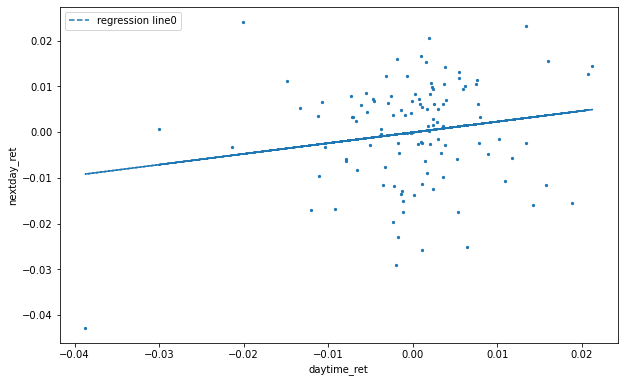

<Figure size 720x444.96 with 0 Axes>

In [2914]:
result['close']=result['close'].shift(-1)
result['hk_open']=result['hk_open'].shift(-1)
result['hk_close']=result['hk_close'].shift(-1)
result.dropna(inplace=True)
result['daytime_ret']=np.log(result['close']/result['open'])
result['overnight_ret']=np.log(result['hk_open']/result['close'])
result['nextday_ret']=np.log(result['hk_close']/result['close'])
result['nextday_daytime_ret']=np.log(result['hk_close']/result['hk_open'])
regression(result[['daytime_ret','nextday_ret']].dropna())

In [912]:
major.set_index('Dates',inplace=True)

In [1364]:
for future in future_list:
    get_price_future(future)

no HI
0
no HC
0
no HC
7
no HC
8
no HC
10
no HCT
0
no HCT
5
no HCT
6
no HCT
7
no HCT
8
no HCT
9
no HCT
10
no XU
0
no XU
7
no XU
8
no XU
9
no XU
10
no IFB
0
no IFB
5
no IFB
6
no IFB
7
no IFB
8
no IFB
9
no IFB
10
no ES
0
no NQ
0
no NQ
6
no NQ
7
no NQ
8
no NQ
9
no NQ
10


In [27]:
future_list

['HI', 'HC', 'HCT', 'XU', 'IFB', 'ES', 'NQ']

In [922]:
a=get_price_future('ES')

In [960]:
target_sub=NAV_ret

In [14]:
#HIA = HSI Index
#HCA = HSCEI Index
#HCTA = HSTECH Index
#IFBA = CSI300 Index
#XUA = XIN9I Index
#ESA = S&P 500 Index
#NQA = NDX Index
pair_dic={'HI':'','HC','HCT','XU','IFB'}

SyntaxError: invalid syntax (<ipython-input-14-2b492eacf54c>, line 8)

In [2916]:
target='FLCH'
sub=get_price_ETF(target)
sub.index=sub.index.tz_convert('US/Eastern')

In [2918]:
sub_ret=dailyfy(sub,target)

In [2919]:
SP=get_price_future('ES')
SP.index=SP.index.tz_convert('US/Eastern')
temp=pd.merge(SP,sub['close'].rename('close_ETF'),left_index=True,right_index=True)
SP=temp.groupby(temp.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
SP.columns=['open','close','high','low']
sub_ret=pd.merge(np.log(SP['close']/SP['close'].shift(1)).rename('SP'),sub_ret,left_index=True,right_index=True)

In [2920]:
a=sub_ret[['NAV ret','SP']]

In [2921]:
a['NAV ret']=a['NAV ret'].shift(-1)

In [2925]:
a=a[['SP','NAV ret']]

params: -0.0020362575654893247   0.1629800459481754
p-value: 0.1555318095615538   0.3180366946645758


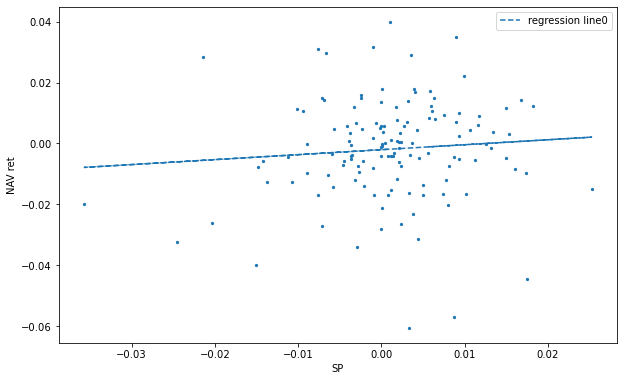

<Figure size 720x444.96 with 0 Axes>

SpearmanrResult(correlation=0.10269582783411388, pvalue=0.23769108682854537)

In [2926]:
regression(a.dropna(),summary=False)
display(spearmanr(a.dropna()['SP'],a.dropna()['NAV ret']))

In [ ]:
#copy of dailyfy
#def dailyfy(sub,target=''):
    sub_daily=sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
    sub_daily.columns=['open','close','high','low']
    sub_dayret=np.log(sub_daily['close']/sub_daily['open'])
    sub_overnightret=np.log(sub_daily['open']/sub_daily['close'].shift(1))
    sub_closetocloseret=np.log(sub_daily['close'].pct_change()+1)
    sub_opentoopenret=np.log(sub_daily['open'].pct_change()+1)
    sub_ret=pd.concat([sub_dayret,sub_overnightret,sub_closetocloseret],axis=1)
    sub_ret.columns=['daytime ret','closetoclose ret','day to day ret']
    sub_ret.index=pd.Series(sub_ret.index).apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d'))
    if target!='':
        sub_ret=pd.merge(sub_ret,NAV_ret[target],left_index=True,right_index=True).rename(columns={target:'NAV ret'})
    return sub_ret

In [27]:
def dailyfy(sub,target=''):
    sub_daily=sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
    sub_daily.columns=['open','close','high','low']
    sub_dayret=np.log(sub_daily['close']/sub_daily['open'])
    sub_overnightret=np.log(sub_daily['open']/sub_daily['close'].shift(1))
    sub_closetocloseret=np.log(sub_daily['close'].pct_change()+1)
    sub_opentoopenret=np.log(sub_daily['open'].pct_change()+1)
    sub_ret=pd.concat([sub_dayret,sub_overnightret,sub_closetocloseret,sub_opentoopenret],axis=1)
    sub_ret.columns=['daytime ret','overnight ret','closetoclose ret','opentoopen ret']
    sub_ret.index=pd.Series(sub_ret.index).apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d'))
    if target!='':
        sub_ret=pd.merge(sub_ret,NAV_ret[target],left_index=True,right_index=True).rename(columns={target:'NAV ret'})
    return sub_ret

In [13]:
proxy_dic={'IFB':['ASHR','KBA','CNYA'],'HI':['FXI','YINN','MCHI','FLCH'],'HC':['FXI','YINN','MCHI','FLCH'],'HCT':['GXC','FLCH','CXSE','MCHI'],'XU':['CHAU']}

In [147]:
#finding proxies for IFB
ETF_list=list(config['name'])
target_future='IFB'
df_future=get_price_future(target_future)
df_future_dailyfy=dailyfy(df_future)
df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
df_merge=df_future_dailyfy['closetoclose ret_future_'+target_future]
for target_ETF in ETF_list:
    try:
        df_ETF=get_price_ETF(target_ETF)
        df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
        df_ETF_dailyfy=dailyfy(df_ETF)
        df_ETF_dailyfy.columns=pd.Series(df_ETF_dailyfy.columns).apply(lambda x:x+'_ETF'+'_'+target_ETF)
        df_merge=pd.merge(df_merge,df_ETF_dailyfy['opentoopen ret_ETF_'+target_ETF],left_index=True,right_index=True)
    except:
        print('no '+target_ETF)
result=pd.DataFrame()
for ETF in df_merge.columns:
    if ETF!='closetoclose ret_future_'+target_future:
        res=regression(df_merge.dropna()[['closetoclose ret_future_'+target_future,ETF]],target2='closetoclose ret_future_'+target_future,target1=ETF,summary=False,mute=True)
        result=pd.concat([result,pd.DataFrame([res.params[1],res.pvalues[1]],columns=[ETF]).T],axis=0)
result.columns=['corr','pvalue']

In [150]:
result.sort_values('corr',ascending=False)

,corr,pvalue
opentoopen ret_ETF_CNYA,0.836014,4.201039e-39
opentoopen ret_ETF_KBA,0.832842,1.778537e-41
opentoopen ret_ETF_ASHR,0.827654,7.496358e-41
opentoopen ret_ETF_EWH,0.587724,1.244751e-07
opentoopen ret_ETF_GXC,0.544935,3.541999e-17
opentoopen ret_ETF_FXI,0.529443,5.355454e-16
opentoopen ret_ETF_FLCH,0.512639,2.698933e-15
opentoopen ret_ETF_MCHI,0.481855,6.107519e-15
opentoopen ret_ETF_CXSE,0.445631,2.017720e-16
opentoopen ret_ETF_KSTR,0.433176,7.987018e-10


In [2952]:
#find proxies for other simultaneously trading future
target_future='HI'
df_future=get_price_future(target_future)
df_future.index=df_future.index.tz_convert('US/Eastern')
#df_future_dailyfy=dailyfy(df_future)
#df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
#df_merge=df_future_dailyfy['overnight ret_future_'+target_future]

In [2953]:
result=pd.DataFrame()
for target_ETF in ETF_list:
    df_ETF=get_price_ETF(target_ETF)
    df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
    df_ETF_dailyfy=dailyfy(df_ETF)
    df_ETF_dailyfy.columns=pd.Series(df_ETF_dailyfy.columns).apply(lambda x:x+'_ETF'+'_'+target_ETF)
    #df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
    a=pd.merge(df_future['close'],df_ETF['close'].rename('close_ETF'),left_index=True,right_index=True)
    temp=a.groupby(a.index.date).apply(lambda x:x.apply(lambda y:np.log(y.tail(1).iloc[0]/y.head(1).iloc[0])))
    result=pd.concat([result,pd.DataFrame([target_ETF,temp.corr()['close_ETF'].iloc[0],pearsonr(temp['close'],temp['close_ETF'])[1]]).T],axis=0)
result.columns=['ETF','corr','pvalue']
result=result.sort_values('corr',ascending=False).set_index('ETF')

In [2955]:
result['corr']

ETF
FXI      0.91382
YINN    0.910944
MCHI    0.841123
FLCH    0.820605
ASHR    0.814379
GXC     0.811395
CHAU    0.800456
KBA     0.800238
CXSE    0.799278
CNYA    0.736539
CHIQ    0.699878
CQQQ    0.696323
KWEB    0.686277
CWEB    0.664818
KURE    0.653746
EWH     0.607133
PGJ     0.602623
KGRN    0.498405
KFVG    0.456357
KSTR    0.433389
CHAD   -0.657753
Name: corr, dtype: object

In [2119]:
a=a.dropna(subset=['close_ETF_FXI','close_ETF_MCHI','close_ETF_YINN','close_ETF_FLCH'])

In [2124]:
a.dropna(subset=['open'],inplace=True)

In [2100]:
pd.Series((np.log(a.dropna().tail(1).values)-np.log(a.dropna().head(1).values))[0])

0   -0.120310
1   -0.121367
2   -0.273041
3   -0.922065
4   -0.284564
5   -0.281927
dtype: float64

In [2128]:
a=a.groupby(a.index.date).apply(lambda x:pd.Series((np.log(x.dropna().tail(1).values)-np.log(x.dropna().head(1).values))[0]))

In [2142]:
res=regression(temp.dropna(),target2='close',target1=[i for i in a.columns if (i!='close')&(i!='open')],summary=False,mute=True)

In [2150]:
a=a.drop(columns={'open','close'}).dropna()

In [2247]:
future_overnight[['predict_close','close']].corr()

,predict_close,close
predict_close,1.000000,0.987143
close,0.987143,1.000000


In [2250]:
future_overnight[['open_nextday_lag0','ret']].corr()

,open_nextday_lag0,ret
open_nextday_lag0,1.000000,-0.801277
ret,-0.801277,1.000000


In [2600]:
np.log(future_overnight['close']/future_overnight['open']).corr(np.log(future_overnight['open_next']/future_overnight['open']))

0.4188622477778768

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   real   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     227.8
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           4.08e-30
Time:                        08:43:22   Log-Likelihood:                 578.69
No. Observations:                 129   AIC:                            -1153.
Df Residuals:                     127   BIC:                            -1148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.904e-05      0.000      0.160      0.873      -0.000       0.001
predict        0.7759      0.051     15.093      0.000       0.674       0.878
==============================================================================
Omnibus:                        2.420   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.298   Jarque-Bera (JB):                2.091
Skew:                           0.125   Prob(JB):                        0.351
Kurtosis:                       3.571   Cond. No.                         213.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 3.9038397358621e-05   0.7759423882240948
p-value: 0.872760723476947   4.081568215123062e-30


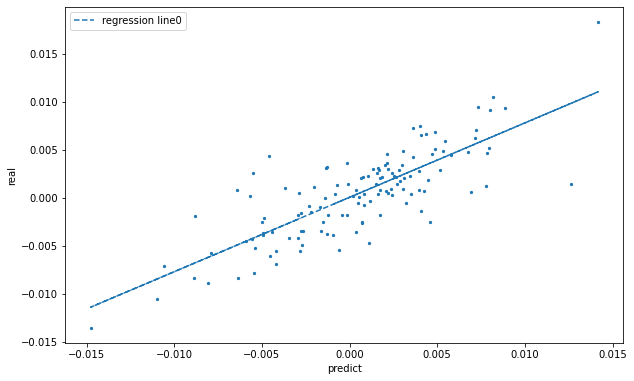

<Figure size 720x444.96 with 0 Axes>

In [2678]:
regression(pd.merge(np.log(future_overnight['predict_close']/future_overnight['open']).rename('predict'),np.log(future_overnight['close']/future_overnight['open']).rename('real'),left_index=True,right_index=True))

In [2938]:
sub=pd.merge(get_price_ETF('MCHI'),fx.rename(columns={'close':'fx'}),left_index=True,right_index=True)

In [ ]:
df_ETF

In [3380]:
target_futre='HI'
include_SP=True
df_future=get_price_future(target_future)
df_future.index=df_future.index.tz_convert('US/Eastern')
df_future.sort_index(inplace=True)
#df_future_dailyfy=dailyfy(df_future)
#df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
#df_merge=df_future_dailyfy['overnight ret_future_'+target_future]
a=pd.DataFrame()
if target_future!='IFB':
    for target_ETF in proxy_dic[target_future]:
        df_ETF=pd.merge(get_price_ETF(target_ETF),fx.rename(columns={'close':'fx'}),left_index=True,right_index=True)
        df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
        df_ETF['open'],df_ETF['close']=df_ETF['open']*df_ETF['fx'],df_ETF['close']*df_ETF['fx']
        df_ETF.sort_index(inplace=True)
        df_ETF=df_ETF.loc[df_ETF['volume']!=0]
        df_ETF_dailyfy=dailyfy(df_ETF)
        df_ETF_dailyfy.columns=pd.Series(df_ETF_dailyfy.columns).apply(lambda x:x+'_ETF'+'_'+target_ETF)
        #df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
        if len(a)==0:
            a=pd.merge(df_future[['open','close']],df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
        else:
            a=pd.merge(a,df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
    if include_SP:
        sub=get_price_future('ES')
        sub.index=sub.index.tz_convert('US/Eastern')
        a=pd.merge(a,sub['close'].rename('SP'),left_index=True,right_index=True,how='outer')
    a.sort_index(inplace=True)
    temp=a.dropna()
    temp=temp.groupby(temp.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
    #temp=temp.groupby(temp.index.date).apply(lambda x:pd.Series((x.tail(1).values/x.head(1).values-1)[0]))
    temp.columns=a.columns
    res=regression(temp.dropna(),target2='close',target1=[i for i in a.columns if (i!='close')&(i!='open')&(i!='SP')],summary=False,mute=True)
    #print(res.pvalues)
    #print(res.params)
    df_predict_X=a.drop(columns={'open','close','SP'}).dropna()
    df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
    #df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:x.tail(1))
    #df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:pd.Series((x.tail(1).values/x.head(1).values-1)[0]))
    future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)[['open','SP']].rename(columns={'SP':'SP_open'})).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close'),left_index=True,right_index=True)

In [3381]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     177.5
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           3.23e-34
Time:                        14:50:38   Log-Likelihood:                 333.21
No. Observations:                  70   AIC:                            -656.4
Df Residuals:                      65   BIC:                            -645.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0002      0.000      0.789      0.433      -0.000       0.001
close_ETF_GXC      0.7192      0.313      2.301      0.025       0.095       1.344
close_ETF_FLCH    -0.4656      0.268     -1.739      0.087      -1.000       0.069
close_ETF_CXSE     0.8449      0.228      3.701      0.000       0.389       1.301
close_ETF_MCHI    -0.0970      0.331     -0.293      0.770      -0.758       0.564
==============================================================================
Omnibus:                        5.639   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.059
Skew:                           0.475   Prob(JB):                       0.0797
Kurtosis:                       3.913   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
lookup_time(a[['open','close']],1,27,13,59)

In [3727]:
lookup_time(a[['open','close']],2,25,14,59)

,open,close
Dates,,
2021-02-25 14:59:00-05:00,NaN,NaN


In [3681]:
a.index=a.index.tz_convert('Hongkong')

In [4336]:
target_future='HI'
include_SP=True
df_future=get_price_future(target_future)
df_future.index=df_future.index.tz_convert('US/Eastern')
df_future.sort_index(inplace=True)
#df_future_dailyfy=dailyfy(df_future)
#df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
#df_merge=df_future_dailyfy['overnight ret_future_'+target_future]
a=pd.DataFrame()
if target_future!='IFB':
    for target_ETF in proxy_dic[target_future]:
        df_ETF=pd.merge(get_price_ETF(target_ETF),fx.rename(columns={'close':'fx'}),left_index=True,right_index=True)
        df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
        df_ETF['open'],df_ETF['close']=df_ETF['open']*df_ETF['fx'],df_ETF['close']*df_ETF['fx']
        df_ETF.sort_index(inplace=True)
        df_ETF=df_ETF.loc[df_ETF['volume']!=0]
        #df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
        if len(a)==0:
            a=pd.merge(df_future[['open','close']],df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
        else:
            a=pd.merge(a,df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
    if include_SP:
        sub=get_price_future('ES')
        sub.index=sub.index.tz_convert('US/Eastern')
        a=pd.merge(a,sub['close'].rename('SP'),left_index=True,right_index=True,how='outer')
    a.sort_index(inplace=True)
    temp=a.dropna()
    temp=temp.groupby(temp.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
    #temp=temp.groupby(temp.index.date).apply(lambda x:pd.Series((x.tail(1).values/x.head(1).values-1)[0]))
    temp.columns=a.columns
    res=regression(temp.dropna(),target2='close',target1=[i for i in a.columns if (i!='close')&(i!='open')&(i!='SP')],summary=False,mute=True)
    #print(res.pvalues)
    #print(res.params)
    df_predict_X=a.drop(columns={'open','close','SP'}).dropna()
    df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
    #df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:x.tail(1))
    #df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:pd.Series((x.tail(1).values/x.head(1).values-1)[0]))
    future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)[['open','SP']].rename(columns={'SP':'SP_open'})).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close'),left_index=True,right_index=True)
    #future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)['open']).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close'),left_index=True,right_index=True)
    #future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)['open']).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close').droplevel(1),left_index=True,right_index=True)
    #future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.tail(1)['close']).droplevel(1),future_overnight,left_index=True,right_index=True)
    future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.tail(1)[['close']]).droplevel(1),future_overnight,left_index=True,right_index=True)
    future_overnight=pd.merge(a.drop(columns={'open','close'}).dropna().groupby(a.drop(columns={'open','close','SP'}).dropna().index.date).apply(lambda x:x.tail(1)[['SP']]).rename(columns={'SP':"SP_close"}).droplevel(1),future_overnight,left_index=True,right_index=True)

In [4302]:
a.dropna().groupby(a.dropna().index.date).apply(lambda y:y.groupby(y.index.hour)[['open','close_ETF_FXI']].apply(lambda z:np.log(z.tail(1).iloc[0]/z.head(1).iloc[0]))).reset_index(drop=True).corr()

,open,close_ETF_FXI
open,1.000000,0.875097
close_ETF_FXI,0.875097,1.000000


In [4357]:
t=a.drop(columns={'open','close'}).dropna().groupby(a.drop(columns={'open','close'}).dropna().index.date).apply(lambda x:x.tail(1)[['SP']]).rename(columns={'SP':"SP_close"})

In [102]:
target_future='IFB'

In [25]:
def dailyfy(sub,target=''):
    sub_daily=sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
    sub_daily.columns=['open','close','high','low']
    sub_dayret=np.log(sub_daily['close']/sub_daily['open'])
    sub_overnightret=np.log(sub_daily['open']/sub_daily['close'].shift(1))
    sub_closetocloseret=np.log(sub_daily['close'].pct_change()+1)
    sub_opentoopenret=np.log(sub_daily['open'].pct_change()+1)
    sub_ret=pd.concat([sub_dayret,sub_overnightret,sub_closetocloseret,sub_opentoopenret],axis=1)
    sub_ret.columns=['daytime ret','overnight ret','closetoclose ret','opentoopen ret']
    sub_ret.index=pd.Series(sub_ret.index).apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d'))
    if target!='':
        sub_ret=pd.merge(sub_ret,NAV_ret[target],left_index=True,right_index=True).rename(columns={target:'NAV ret'})
    return sub_ret

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IFB   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     139.4
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           2.94e-39
Time:                        13:59:24   Log-Likelihood:                 459.40
No. Observations:                 126   AIC:                            -910.8
Df Residuals:                     122   BIC:                            -899.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.428      0.669      -0.001       0.001
ASHR           0.4322      0.221      1.955      0.053      -0.005       0.870
KBA            0.3303      0.247      1.338      0.183      -0.158       0.819
CNYA           0.0831      0.216      0.385      0.701      -0.344       0.511
==============================================================================
Omnibus:                        5.137   Durbin-Watson:                   2.696
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                7.240
Skew:                           0.080   Prob(JB):                       0.0268
Kurtosis:                       4.163   Cond. No.                         530.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.0002470476898721447   0.43222302197452034
p-value: 0.66910108288424   0.05283001761352243


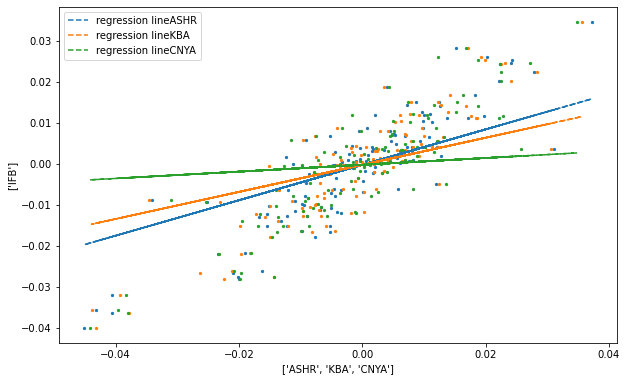

<Figure size 720x444.96 with 0 Axes>

In [ ]:
df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
df_merge=df_future_dailyfy['overnight ret_future_'+target_future]

for target_ETF in ETF_list:
    try:
        df_ETF=get_price_ETF(target_ETF)
        df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
        df_ETF_dailyfy=dailyfy(df_ETF)
        df_ETF_dailyfy.columns=pd.Series(df_ETF_dailyfy.columns).apply(lambda x:x+'_ETF'+'_'+target_ETF)
        df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
    except:
        print('no '+target_ETF)

if include_SP:
    sub=get_price_future('ES')
    sub.index=sub.index.tz_convert('US/Eastern')
    a=pd.merge(a,sub['close'].rename('SP'),left_index=True,right_index=True,how='outer')
    temp=a.groupby(a.index.date).apply(lambda x:x.apply(lambda y:np.log(y.dropna().tail(1).iloc[0]/y.dropna().head(1).iloc[0])))
future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)[['open','SP']].rename(columns={'SP':'SP_open'})).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close'),left_index=True,right_index=True)
future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.tail(3).head(1)[['close']]).droplevel(1),future_overnight,left_index=True,right_index=True)
future_overnight=pd.merge(a.drop(columns={'open','close'}).dropna().groupby(a.drop(columns={'open','close','SP'}).dropna().index.date).apply(lambda x:x.tail(3).head(1)[['SP']]).rename(columns={'SP':"SP_close"}).droplevel(1),future_overnight,left_index=True,right_index=True)
future_overnight['predict_close']=np.exp(future_overnight['predict_close'])*future_overnight['open']
#future_overnight['predict_close']=(future_overnight['predict_close']+1)*future_overnight['open']
future_overnight['predict_close']=future_overnight['close']
future_overnight['ret']=np.log(future_overnight['predict_close']/future_overnight['open'])
future_overnight['ret_real']=np.log(future_overnight['close']/future_overnight['open'])
future_overnight['open_next']=future_overnight['open'].shift(-1)
future_overnight['overnight_ret']=np.log(future_overnight['open_next']/future_overnight['predict_close'])
future_overnight['overnight_ret_real']=np.log(future_overnight['open_next']/future_overnight['close'])

In [33]:
future_overnight=main('HI')

no ES
0


In [31]:
fx=pd.read_csv(path_data+'/USDHKD Curncy_TRADE.csv').set_index('Dates')['close']
fx.index=pd.Series(fx.index).apply(lambda x:pd.to_datetime(x,format="%Y-%m-%d %H:%M:%S"))
fx.index=fx.index.tz_localize('Hongkong')

In [32]:
future_overnight_dic={}
corr_dic={}

In [20]:
#find proxies for other simultaneously trading future
def main(target_future,include_SP=True):
    if target_future in future_overnight_dic.keys():
        return future_overnight_dic[target_future].copy()
    include_SP=True
    df_future=get_price_future(target_future)
    df_future.index=df_future.index.tz_convert('US/Eastern')
    df_future.sort_index(inplace=True)
    #df_future_dailyfy=dailyfy(df_future)
    #df_future_dailyfy.columns=pd.Series(df_future_dailyfy.columns).apply(lambda x:x+'_future'+'_'+target_future)
    #df_merge=df_future_dailyfy['overnight ret_future_'+target_future]
    a=pd.DataFrame()
    if target_future!='IFB':
        for target_ETF in proxy_dic[target_future]:
            df_ETF=pd.merge(get_price_ETF(target_ETF),fx.rename('fx'),left_index=True,right_index=True)
            df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
            df_ETF['open'],df_ETF['close']=df_ETF['open']*df_ETF['fx'],df_ETF['close']*df_ETF['fx']
            df_ETF.sort_index(inplace=True)
            df_ETF=df_ETF.loc[df_ETF['volume']!=0]
            #df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
            if len(a)==0:
                a=pd.merge(df_future[['open','close']],df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
            else:
                a=pd.merge(a,df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
        if include_SP:
            sub=get_price_future('ES')
            sub.index=sub.index.tz_convert('US/Eastern')
            a=pd.merge(a,sub['close'].rename('SP'),left_index=True,right_index=True,how='outer')
        a.sort_index(inplace=True)
        temp=a.dropna()
        temp=temp.groupby(temp.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
        temp.columns=a.columns
        res=regression(temp.dropna(),target2='close',target1=[i for i in a.columns if (i!='close')&(i!='open')&(i!='SP')],summary=False,mute=True)
        df_predict_X=a.drop(columns={'open','close','SP'}).dropna()
        df_predict_X=df_predict_X.groupby(df_predict_X.index.date).apply(lambda x:pd.Series(np.log(x.tail(1).values/x.head(1).values)[0]))
        future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.head(1)[['open','SP']].rename(columns={'SP':'SP_open'})).droplevel(1),res.predict(sm.add_constant(df_predict_X)).rename('predict_close'),left_index=True,right_index=True)
        future_overnight=pd.merge(a.dropna().groupby(a.dropna().index.date).apply(lambda x:x.tail(3).head(1)[['close']]).droplevel(1),future_overnight,left_index=True,right_index=True)
        future_overnight=pd.merge(a.drop(columns={'open','close'}).dropna().groupby(a.drop(columns={'open','close'}).dropna().index.date).apply(lambda x:x.tail(1)[['SP']]).rename(columns={'SP':"SP_close"}).droplevel(1),future_overnight,left_index=True,right_index=True)
        future_overnight['predict_close']=np.exp(future_overnight['predict_close'])*future_overnight['open']
        if target_future=='XU':
            future_overnight['predict_close']=future_overnight['close']
        #future_overnight['predict_close']=(future_overnight['predict_close']+1)*future_overnight['open']
        #future_overnight['predict_close']=future_overnight['close']
    else:
        df_future=get_price_future(target_future)
        future_overnight=df_future.groupby(df_future.index.date).apply(lambda x:pd.Series([x.head(3).tail(1)['close'].iloc[0],x.tail(1)['close'].iloc[0],x['volume'].sum()]))
        future_overnight.columns=['open_HK','close_HK','volume_HK']
        include_SP=True
        a=pd.DataFrame()
        df_regress=pd.DataFrame()
        for target_ETF in proxy_dic[target_future]:
            df_ETF=pd.merge(get_price_ETF(target_ETF),fx.rename('fx'),left_index=True,right_index=True)
            df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
            df_ETF['open'],df_ETF['close']=df_ETF['open']*df_ETF['fx'],df_ETF['close']*df_ETF['fx']
            df_ETF.sort_index(inplace=True)
            df_ETF=df_ETF.loc[df_ETF['volume']!=0]
            if len(df_regress)==0:
                df_regress=dailyfy(df_ETF)['opentoopen ret'].rename(target_ETF)
            else:
                df_regress=pd.merge(df_regress,dailyfy(df_ETF)['opentoopen ret'].rename(target_ETF),left_index=True,right_index=True)
            #df_merge=pd.merge(df_merge,df_ETF_dailyfy['daytime ret_ETF_'+target_ETF],left_index=True,right_index=True)
            if len(a)==0:
                a=pd.DataFrame(df_ETF['close'].rename('close_ETF_'+target_ETF))
                a=pd.merge(a,df_ETF['open'].rename('open_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
            else:
                a=pd.merge(a,df_ETF['close'].rename('close_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
                a=pd.merge(a,df_ETF['open'].rename('open_ETF_'+target_ETF),left_index=True,right_index=True,how='outer')
        if include_SP:
            sub=get_price_future('ES')
            sub.index=sub.index.tz_convert('US/Eastern')
            a=pd.merge(a,sub['close'].rename('SP'),left_index=True,right_index=True,how='outer')
        def func(x):
            x['SP_open']=x.head(1)['SP'].iloc[0]
            x['SP_close']=x.tail(1)['SP'].iloc[0]
            return x.apply(lambda y:y.dropna().head(1).iloc[0] if y.name.find('open')!=-1 else y.dropna().tail(1).iloc[0])
        a.dropna(subset={a.columns[0]},inplace=True)
        future_overnight=pd.merge(future_overnight,a.groupby(a.index.date).apply(lambda x:func(x)).sort_index(axis=1).drop(columns={'SP'}),left_index=True,right_index=True)
        df_regress=pd.merge(df_regress,dailyfy(df_future)['closetoclose ret'].rename(target_future),left_index=True,right_index=True)
        res=regression(df_regress,target1=proxy_dic[target_future],target2=[target_future],summary=False,mute=True)
        future_overnight['open']=future_overnight['close_HK']
        predict_X=pd.DataFrame()
        for ETF in proxy_dic[target_future]:
            if len(predict_X)==0:
                predict_X=pd.DataFrame(np.log(future_overnight['close_ETF_'+ETF]/future_overnight['open_ETF_'+ETF]).rename('intraday_ret_'+ETF))
            else:
                predict_X=pd.merge(predict_X,np.log(future_overnight['close_ETF_'+ETF]/future_overnight['open_ETF_'+ETF]).rename('intraday_ret_'+ETF),left_index=True,right_index=True)
        future_overnight['predict_close']=np.exp(res.predict(sm.add_constant(predict_X)))
        future_overnight['predict_close']*=future_overnight['open']
        future_overnight['close']=future_overnight['predict_close']
    future_overnight['ret']=np.log(future_overnight['predict_close']/future_overnight['open'])
    future_overnight['ret_real']=np.log(future_overnight['close']/future_overnight['open'])
    future_overnight['overnight_ret']=np.log(future_overnight['open'].shift(1)/future_overnight['predict_close'])
    future_overnight['overnight_ret_real']=np.log(future_overnight['open'].shift(1)/future_overnight['close'])
    #future_overnight['ret_next']=np.log(future_overnight['close']/future_overnight['open']).shift(1)
    #regression(future_overnight[['ret','overnight_ret']].dropna())
    #print('pearson daytime ret-overnight ret')
    #display(pearsonr(future_overnight[['ret','overnight_ret']].dropna()['ret'],future_overnight[['ret','overnight_ret']].dropna()['overnight_ret']))
    df_future.index=df_future.index.tz_convert('Hongkong')
    open_minute_dic={'HI':15,'HC':15,'HCT':15,'XU':0,'IFB':30}
    for lag in [0,15,30,45,60,75,90,120,180,240,360,570,780]:
        open_minute=open_minute_dic[target_future]
        df_future.index=df_future.index.tz_convert('Hongkong')
        temp=df_future.groupby(df_future.index.date).apply(lambda x:x.loc[(x.index.hour>=9)&(x.index.minute>=open_minute)].head(lag+1).tail(1))['open'].rename('open_nextday_lag'+str(lag)).droplevel(1)
        temp=temp.shift(-1)
        #temp.index=pd.Series(temp.index).apply(lambda x:x+pd.Timedelta(days=-1))
        future_overnight=pd.merge(future_overnight,temp,left_index=True,right_index=True)


    lag=0
    temp=df_future.groupby(df_future.index.date).apply(lambda x:x.loc[(x.index.hour<=16)&(x.index.minute<=30)].dropna().tail(lag+2).head(1))['close'].rename('close_nextday_lag'+str(lag)).droplevel(1)
    temp=temp.shift(-1)
    future_overnight=pd.merge(future_overnight,temp,left_index=True,right_index=True)


    for i in future_overnight.columns:
        if i.find('lag')!=-1:
            pass
            #future_overnight[i]=np.log(future_overnight[i]/future_overnight['close'])
    #future_overnight['open_nextday_lag0']=np.log(future_overnight['open_nextday_lag0']/future_overnight['predict_close'])
    result=pd.DataFrame()


    for lag in [0,15,30,45,60,75,90,120,180,240,360,570,780]:
        #print(lag)
        #regression(future_overnight[['ret','open_nextday_lag'+str(lag)]])
        #display(pearsonr(future_overnight[['ret','open_nextday_lag'+str(lag)]].dropna()['ret'],future_overnight[['ret','open_nextday_lag'+str(lag)]].dropna()['open_nextday_lag'+str(lag)]))
        #pear=spearmanr(future_overnight[['ret','open_nextday_lag'+str(lag)]].dropna()['ret'],future_overnight[['ret','open_nextday_lag'+str(lag)]].dropna()['open_nextday_lag'+str(lag)])
        #pear=spearmanr(future_overnight[['ret_real','open_nextday_lag'+str(lag)]].dropna()['ret_real'],future_overnight[['ret_real','open_nextday_lag'+str(lag)]].dropna()['open_nextday_lag'+str(lag)])
        #result=pd.concat([result,pd.DataFrame([lag,pear[0],pear[1]])],axis=1)
        pass

    #result=result.T
    #result.columns=['lag','corr','pvalue']
    #display(result)
    future_overnight=pd.merge(future_overnight,NAV[proxy_dic[target_future][0]].rename('NAV'),left_index=True,right_index=True)
    

    
    future_overnight['NAV_C_C_t']=np.log(future_overnight['NAV']/future_overnight['NAV'].shift(1))
    future_overnight['NAV_C_C_t+1']=future_overnight['NAV_C_C_t'].shift(-1)
    future_overnight['NAV_C_C_t-1']=future_overnight['NAV_C_C_t'].shift(1)
    
    future_overnight['SP_C_C_t']=np.log(future_overnight['SP_close']/future_overnight['SP_close'].shift(1))
    future_overnight['SP_C_C_t-1']=future_overnight['SP_C_C_t'].shift(1)
    future_overnight['SP_C_C_t+1']=future_overnight['SP_C_C_t'].shift(-1)
    future_overnight['SP_C_O_t']=np.log(future_overnight['SP_close']/(future_overnight['SP_open']))
    future_overnight['SP_C_O_t-1']=future_overnight['SP_C_O_t'].shift(1)
    future_overnight['SP_C_O_t+1']=future_overnight['SP_C_O_t'].shift(-1)
    future_overnight['SP_O_C_t']=np.log(future_overnight['SP_open']/(future_overnight['SP_close'].shift(1)))
    future_overnight['SP_O_C_t-1']=future_overnight['SP_O_C_t'].shift(1)
    future_overnight['SP_O_C_t+1']=future_overnight['SP_O_C_t'].shift(-1)


    future_overnight['future_O_C_t+1']=np.log(future_overnight['open_nextday_lag0']/(future_overnight['predict_close']))
    future_overnight['future_O_C_t']=future_overnight['future_O_C_t+1'].shift(1)
    future_overnight['future_O_C_t-1']=future_overnight['future_O_C_t'].shift(1)
    #notice that this close to open definition is not the same as what's reported in the paper
    future_overnight['future_C_O_t+1']=np.log(future_overnight['close_nextday_lag0']/future_overnight['open_nextday_lag0'])
    future_overnight['future_C_O_t']=future_overnight['future_C_O_t+1'].shift(1)
    future_overnight['future_C_O_t-1']=future_overnight['future_C_O_t'].shift(1)
    future_overnight['future_C_C_t']=np.log(future_overnight['close_nextday_lag0'].shift(1)/future_overnight['close_nextday_lag0'].shift(2))
    future_overnight['future_C_C_t-1']=future_overnight['future_C_C_t'].shift(1)
    future_overnight['future_C_C_t+1']=future_overnight['future_C_C_t'].shift(-1)
    future_overnight['future_C_C2_t']=np.log(future_overnight['close_nextday_lag0'].shift(1)/future_overnight['predict_close'].shift(1))
    future_overnight['future_C_C2_t+1']=future_overnight['future_C_C2_t'].shift(-1)

    future_overnight['ETF_O_C_t']=np.log(future_overnight['open']/(future_overnight['predict_close'].shift(1)))
    future_overnight['ETF_O_C_t+1']=future_overnight['ETF_O_C_t'].shift(-1)
    future_overnight['ETF_O_C_t-1']=future_overnight['ETF_O_C_t'].shift(1)
    future_overnight['ETF_C_O_t']=np.log(future_overnight['predict_close']/future_overnight['open'])
    future_overnight['ETF_C_O_t+1']=future_overnight['ETF_C_O_t'].shift(-1)
    future_overnight['ETF_C_O_t-1']=future_overnight['ETF_C_O_t'].shift(1)
    future_overnight['ETF_C_C_t']=np.log(future_overnight['predict_close']/future_overnight['predict_close'].shift(1))
    future_overnight['ETF_C_C_t+1']=future_overnight['ETF_C_C_t'].shift(-1)
    future_overnight['ETF_C_C_t-1']=future_overnight['ETF_C_C_t'].shift(1)
    future_overnight['ETF_O_C2_t']=np.log(future_overnight['open']/future_overnight['close_nextday_lag0'].shift(1))
    future_overnight['ETF_O_C2_t+1']=future_overnight['ETF_O_C2_t'].shift(-1)
    future_overnight['ETF_O_C2_t+1']=future_overnight['ETF_O_C2_t'].shift(1)
    
    future_overnight_dic.update({target_future:future_overnight})
    return future_overnight
    corr=corr_analysis(future_overnight,'SP_C_O_t')
    #corr.reset_index().loc[pd.Series(corr.index).apply(lambda x:True if (x[-3:].find('t')!=-1) else False)].set_index('index').sort_index()
def corr_analysis(sub,target):
    result=pd.DataFrame()
    for i in sub.columns:
        if i!=target:
            res=regression(sub[[i,target]].dropna(),mute=True,summary=False)
            result=pd.concat([result,pd.DataFrame([sub[i].corr(sub[target]),res.pvalues[1]],columns=[i])],axis=1)
    result=result.T
    result.columns=['corr','pvalue']
    return result.sort_values('corr',ascending=False)
def get_corr(item):
    if item not in corr_dic.keys():
        corr_result=pd.DataFrame()
        for target_future in ['HI','HC','HCT','XU','IFB']:
            print(target_future)
            future_overnight=main(target_future)
            corr=corr_analysis(future_overnight,item)
            corr=corr.reset_index().loc[pd.Series(corr.index).apply(lambda x:True if (x[-3:].find('t')!=-1) else False)].set_index('index').sort_index()
            corr.columns=pd.MultiIndex.from_product([[target_future],corr.columns])
            if len(corr_result)==0:
                corr_result=corr
            else:
                corr_result=pd.merge(corr_result,corr,left_index=True,right_index=True,how='outer')
        corr_dic.update({item:corr_result})
    return corr_dic[item].copy()

In [16]:
future_overnight_dic={}
corr_dic={}

In [17]:
from sklearn.model_selection import train_test_split

In [29]:
target_main='SCP'
def VWAP(sub,weights='',target=''):
    if target=='':
        return (sub*(weights/weights.sum())).sum()
    else:
        return (sub[target]*(sub[weights]/sub[weights].sum())).sum()
max_time=100
for times in range(max_time):
    df=gen_df_ret(target_main)
    df2=gen_df_vol(target_main)
    df=pd.merge(df,df2,left_index=True,right_index=True,how='outer')
    print(target_main)
    print(target_main)
    df['rest']=df['21_hour_ret']+df['22_hour_ret']
    target='rest'
    list1=['sig','deviation_overnight','0_15_ret','deviation_0_15','overnight_ret',target]
    list2=list(pd.Series(list1).apply(lambda x:x+'_vol'))
    for i in list2:
        if i!=target+'_vol':
            list1.append(i)
    sub=df[list1].dropna()
    for i in list1:
        for window in range(1,7,2):
            if (i!=target):
                sub[i+'_rollingmean'+str(window)]=sub[i].rolling(window).mean()
    for i in list1:
        for window in range(3):
            if (i!=target):
                sub[i+'_lagged'+str(window)]=sub[i].shift(window)
    for window in range(1,5):
        sub[target+'_lagged'+str(window)]=sub[i].shift(window)
    for i in [target]:
        for window in range(1,20):
            sub[i+'_rollingmean'+str(window)]=sub[i].rolling(window).mean().shift(1)
    X=sub.dropna()[[i for i in sub.columns if i !=target]]
    Y=sub.dropna()[[target]]
    train_X, test_X, train_y, test_y = train_test_split(X.values, Y.values, test_size=0.5)
    my_imputer = Imputer
    train_X = my_imputer.fit_transform(train_X)
    test_X = my_imputer.transform(test_X)
    train=pd.DataFrame(train_X)
    train.columns=X.columns
    my_model = lgb.LGBMRegressor(boosting_type='rf',objective='binary', num_leaves=10,learning_rate=0.01,verbose=-1,bagging_freq=1,bagging_fraction=0.7)
    my_model.fit(train, train_y, verbose=False)
    predictions = my_model.predict(test_X)
    result=pd.DataFrame([predictions,test_y.T[0]]).T.reset_index(drop=True)
    print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
    from scipy.stats import spearmanr
    #display(spearmanr(result[0],result[1]))
    #display(result)
    res=plot_scatter(result,summary=False,res_return=True)
    result.columns=['predictions','ret']
    result['predictions']=(result['predictions']-result['predictions'].rolling(15).mean())/(result['predictions'].rolling(15).std())
    result.dropna(inplace=True)
    transcost=0.0001
    #result=result.loc[abs(result['predictions'])>3*transcost]
    #plot_line((result['ret']*result['predictions']-transcost).cumsum())
    #print(result['predictions'].max())
    #print(abs(result['predictions']).mean())
    #ax = lgb.plot_importance(my_model)

NameError: name 'gen_df_ret' is not defined

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from IPython.display import clear_output
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
pd.set_option('display.max_rows',300)
from scipy.signal import lfilter,savgol_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer 
Imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [61]:
future_overnight=main('HI')

In [92]:
future_overnight=add_sentiment('HI')
future_overnight_original=future_overnight.copy()
future_overnight=future_overnight.iloc[:-30]

In [36]:
Y=future_overnight['ETF_O_C_t+1']

In [37]:
import fclib
#from fclib.common.utils import git_repo_path
from fclib.models.lightgbm import predict
from fclib.evaluation.evaluation_utils import MAPE
from fclib.common.plot import plot_predictions_with_history
#from fclib.dataset.ojdata import split_train_test
#from fclib.dataset.ojdata import FIRST_WEEK_START

In [38]:
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    combine_features,
)

In [39]:
from IPython.display import clear_output

In [96]:
X=future_overnight[[i for i in future_overnight.columns if ((i[-1:]=='t') or (i[-3:]=='t-1'))&(i not in ['ret','open_next','overnight_ret'])]]
lags = np.arange(2, 5)
window_size = 3
X =  combine_features(X,X.columns,lags, window_size,used_columns=list(X.columns))
X_original=X.copy()

In [129]:
X=X_original[list(feature_importance_original.sort_values(ascending=False).head(10).index)]

In [99]:
feature_importance_original=feature_importance.sort_values(ascending=False).copy()

In [68]:
del my_model

In [ ]:
import pandas as pd

<BarContainer object of 10 artists>

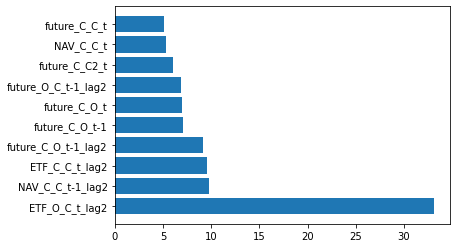

In [134]:
plt.barh(feature_importance.sort_values(ascending=False).head(10).index,feature_importance.sort_values(ascending=False).head(10))

winrate>0: 0.9833333333333333
winrate>0.5: 0.8966666666666666
0.9833333333333333
0.8966666666666666
mean


slope          1.459374
pvalue         0.138788
rank_pvalue    0.118454
dtype: float64

median


slope          1.386852
pvalue         0.054475
rank_pvalue    0.040713
dtype: float64

ETF_O_C_t_lag2         28.683333
ETF_C_C_t_lag2         10.643333
NAV_C_C_t-1_lag2        9.740000
future_C_O_t-1_lag2     7.646667
future_C_O_t-1          7.603333
future_O_C_t-1_lag2     6.106667
future_C_O_t            5.876667
NAV_C_C_t               5.863333
future_C_C2_t           5.376667
future_C_C_t            4.456667
dtype: float64

<AxesSubplot:>

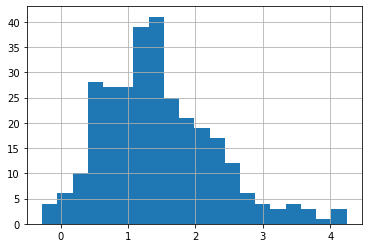

<AxesSubplot:>

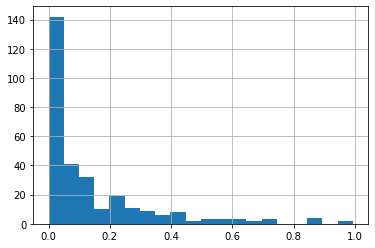

slope          1.459374
pvalue         0.138788
rank_pvalue    0.118454
dtype: float64

ETF_O_C_t_lag2         28.683333
ETF_C_C_t_lag2         10.643333
NAV_C_C_t-1_lag2        9.740000
future_C_O_t-1_lag2     7.646667
future_C_O_t-1          7.603333
future_O_C_t-1_lag2     6.106667
future_C_O_t            5.876667
NAV_C_C_t               5.863333
future_C_C2_t           5.376667
future_C_C_t            4.456667
dtype: float64

In [144]:
feature_importance=pd.DataFrame()
reg_param=pd.DataFrame()
regress_ret=pd.DataFrame()
for iteration in range(300):
    print(iteration)
    train_X, test_X, train_y, test_y = train_test_split(X.values, Y.values, test_size=0.35)
    my_imputer = Imputer
    train_X = my_imputer.fit_transform(train_X)
    test_X = my_imputer.transform(test_X)
    train=pd.DataFrame(train_X)
    train.columns=X.columns
    lgb_train=lgb.Dataset(train,train_y,feature_name=list(train.columns))
    #params={'task':'train','objective':'mape','boosting_type':'rf','verbose':1,'learning_rate':0.01,'num_leaves':10,'bagging_freq':1,'bagging_fraction':0.8}
    #my_model=lgb.train(params, lgb_train, num_boost_round=50)
    my_model = lgb.LGBMRegressor(boosting_type='rf',objective='regression', num_leaves=15,learning_rate=0.01,verbosity=-1,bagging_freq=1,bagging_fraction=0.7)
    my_model.fit(train, train_y, verbose=False)
    predictions = my_model.predict(test_X)
    result=pd.DataFrame([predictions,test_y.T]).T.reset_index(drop=True)
    #print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
    #from scipy.stats import spearmanr
    #display(spearmanr(result[0],result[1]))
    #display(result)
    result.columns=['predictions','ret']
    result['prediction_rank']=result['predictions'].rank()
    res=regression(result,summary=False,mute=True)
    res2=regression(result[['prediction_rank','ret']],summary=False,mute=True)
    #result['predictions']=(result['predictions']-result['predictions'].rolling(15).mean())/(result['predictions'].rolling(15).std())
    #result.dropna(inplace=True)
    transcost=0.0001
    #ax = lgb.plot_importance(my_model, max_num_features=20)
    #plt.show()
    try:
        feature_importance=pd.concat([feature_importance,pd.DataFrame(my_model.feature_importance(),index=my_model.feature_name(),columns=[iteration]).sort_index()],axis=1)
    except:
        feature_importance=pd.concat([feature_importance,pd.DataFrame(my_model.feature_importances_,index=my_model.feature_name_,columns=[iteration]).sort_index()],axis=1)
    reg_param=pd.concat([reg_param,pd.DataFrame([res.params['predictions'],res.pvalues['predictions'],res2.pvalues['prediction_rank']])],axis=1)
    clear_output(wait=True)
    #ax=lgb.plot_tree(my_model,precision=5)
    #plt.show()
    result2=result.copy()
    result['predictions']=zscore(result['predictions'])
    result=result.loc[abs(result['predictions'])>0.8]
    result['ret_real']=result['predictions']*result['ret']-0.0002
    regress_ret=pd.concat([regress_ret,pd.DataFrame([result['ret_real'].mean(),result['ret_real'].cumsum().iloc[-1],result['ret_real'].mean()*(len(result)/len(result2))/result['ret_real'].std()*(252**0.5)])],axis=1)
regress_ret=regress_ret.T
regress_ret.columns=['Ret per trade','Total Ret','Sharpe']
reg_param=reg_param.T
reg_param.columns=['slope','pvalue','rank_pvalue']
feature_importance=feature_importance.mean(axis=1)
print('winrate>0: '+str(len(reg_param.loc[reg_param['slope']>0])/len(reg_param['slope'])))
print('winrate>0.5: '+str(len(reg_param.loc[reg_param['slope']>0.5])/len(reg_param['slope'])))
print(len(reg_param.loc[reg_param['slope']>0])/len(reg_param['slope']))
print(len(reg_param.loc[reg_param['slope']>0.5])/len(reg_param['slope']))
print('mean')
display(reg_param.mean())
print('median')
display(reg_param.median())
display(feature_importance.sort_values(ascending=False).head(10))
display(reg_param['slope'].hist(bins=20))
plt.show()
display(reg_param['pvalue'].hist(bins=20))
plt.show()
display(reg_param.mean())
display(feature_importance.sort_values(ascending=False).head(15))

<Figure size 1440x864 with 0 Axes>

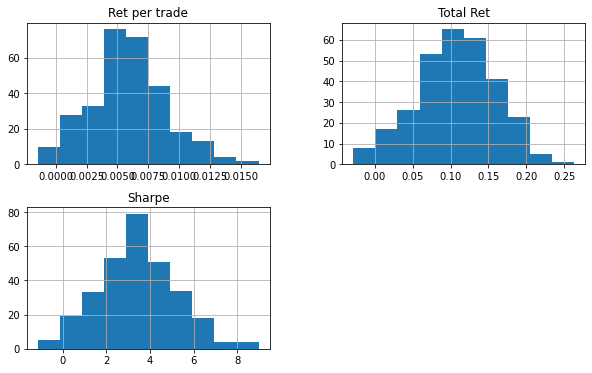

,Ret per trade,Total Ret,Sharpe
results,0.005836,0.110775,3.343073


In [145]:
plt.figure(figsize=(20,12))
regress_ret.hist(figsize=(10,6))
plt.show()
dis=pd.DataFrame(regress_ret.median()).T
dis.index=['results']
display(dis)

In [70]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold, train_test_split
from lightgbm import LGBMClassifier

In [44]:
import shap

In [125]:
shap_values=shap.TreeExplainer(my_model).shap_values(X.iloc[-30:])

In [126]:
global_importances = np.abs(shap_values).mean(0)[:-1]

In [48]:
import matplotlib.pyplot as pl

ValueError: shape mismatch: objects cannot be broadcast to a single shape

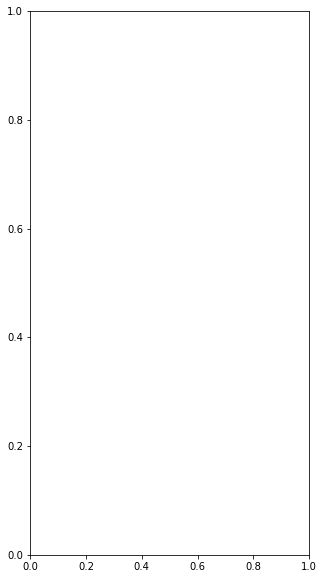

In [128]:
inds = np.argsort(-global_importances)
f = pl.figure(figsize=(5,10))
y_pos = np.arange(20)
inds2 = np.flip(inds[:20], 0)
pl.barh(y_pos, global_importances[inds2], align='center', color="#1E88E5")
pl.yticks(y_pos, fontsize=13)
pl.gca().set_yticklabels(data.columns[inds2])
pl.xlabel('mean abs. SHAP value (impact on model output)', fontsize=13)
pl.gca().xaxis.set_ticks_position('bottom')
pl.gca().yaxis.set_ticks_position('none')
pl.gca().spines['right'].set_visible(False)
pl.gca().spines['top'].set_visible(False)

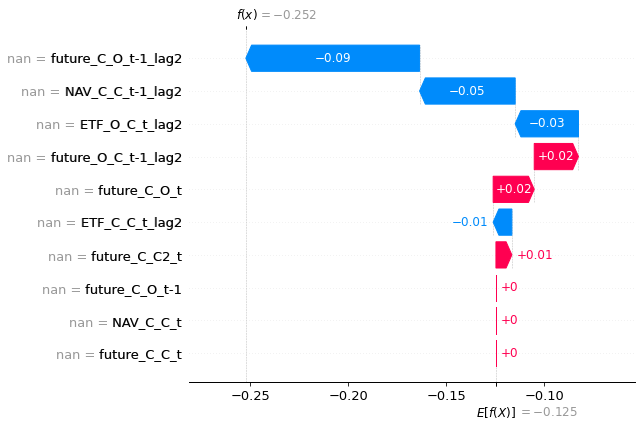

In [146]:
explainer = shap.Explainer(my_model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

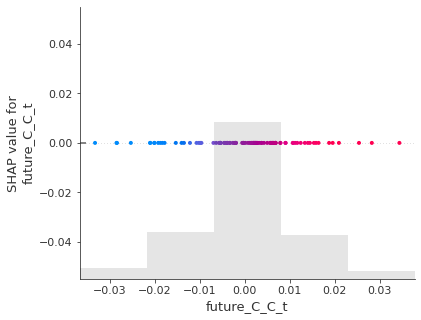

In [148]:
shap.plots.scatter(shap_values[:,"future_C_C_t"], color=shap_values)

0.009340294125721382

0.17746558838870624

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     4.581
Date:                Mon, 23 Aug 2021   Prob (F-statistic):             0.0471
Time:                        16:04:09   Log-Likelihood:                 55.249
No. Observations:                  19   AIC:                            -106.5
Df Residuals:                      17   BIC:                            -104.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0047      0.003     -1.446      0.166      -0.011       0.002
predictions     0.0053      0.002      2.140      0.047    7.58e-05       0.011
==============================================================================
Omnibus:                        0.487   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.460
Skew:                           0.318   Prob(JB):                        0.795
Kurtosis:                       2.581   Cond. No.                         1.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.004657392299633725   0.005336173026676026
p-value: 0.16645419756246693   0.04713089731381804


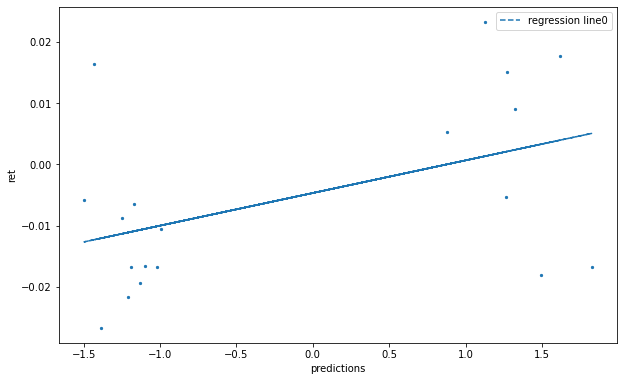

<Figure size 720x444.96 with 0 Axes>

In [113]:
regression(result[['predictions','ret']])

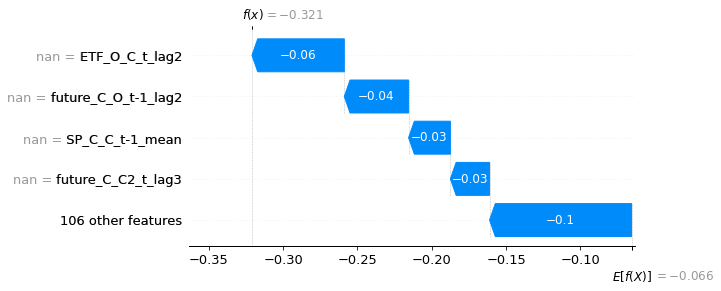

In [50]:
explainer = shap.Explainer(my_model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0],max_display=5)

In [1353]:
shap.plots.waterfall(shap_values[29], max_display=14)

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

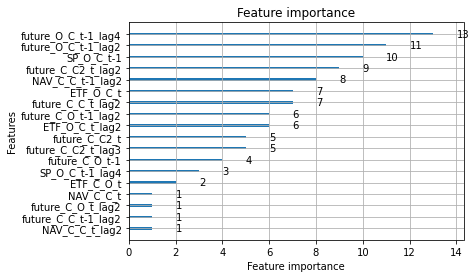

In [177]:
lgb.plot_importance(my_model)

In [92]:
my_model.booster_.save_model('mode.txt')

In [91]:
my_model._Booster.num_trees()

100

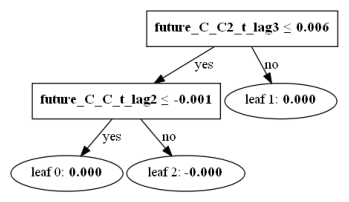

In [54]:
ax=lgb.plot_tree(my_model,tree_index=10,orientation='vertical')
plt.show()

Object `mymodel` not found.


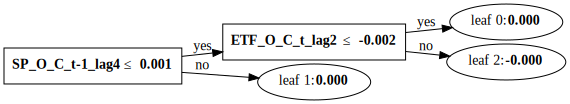

In [174]:
lgb.create_tree_digraph(my_model,10)

In [87]:
reg_param.median()

slope          1.707645
pvalue         0.029755
rank_pvalue    0.027505
dtype: float64

In [475]:
result['prediction_rank']=result['predictions'].rank()

params: -0.0006290128225804344   1.4131917494036
p-value: 0.7280061289301061   0.025585138993131418


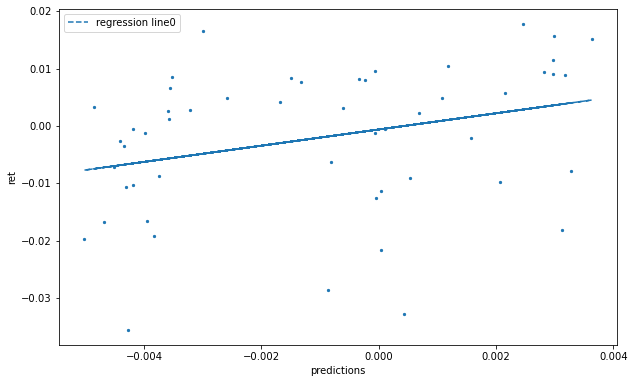

<Figure size 720x444.96 with 0 Axes>

In [55]:
res=regression(result[['predictions','ret']],summary=False)

<AxesSubplot:>

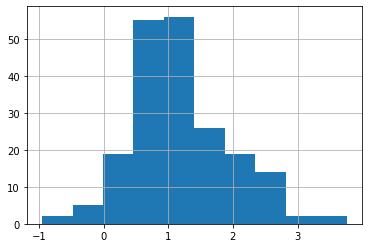

<AxesSubplot:>

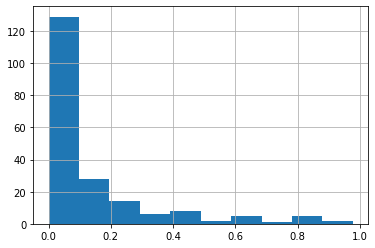

winrate>0: 0.965
winrate>0.5: 0.865


slope     1.179164
pvalue    0.141770
dtype: float64

ETF_C_O_t-1_lag4      23.25
future_C_C2_t_lag2    22.32
future_C_C2_t         21.61
NAV_C_C_t_lag2        21.30
future_C_C_t_lag2     12.85
dtype: float64

params: -0.0036412451005258034   22.730266426956995
p-value: 0.005973743250460554   0.03699397322897652


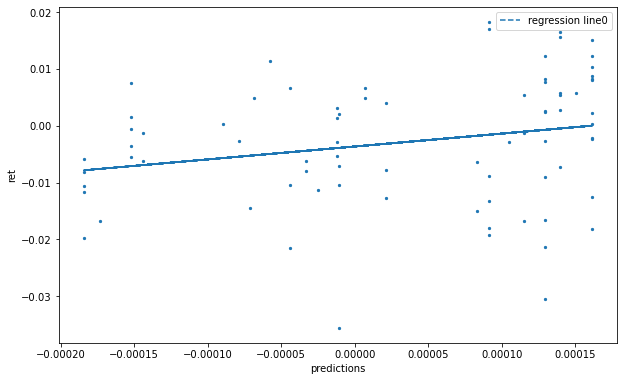

<Figure size 720x444.96 with 0 Axes>

In [367]:
res=regression(result,summary=False)

slope     0.952377
pvalue    0.316577
dtype: float64

NAV_C_C_t_lag2         6.259
future_C_C2_t_lag2     5.566
NAV_C_C_t              4.751
ETF_C_O_t-1_lag4       4.579
future_C_C_t_lag2      4.494
future_C_C2_t          4.327
SP_O_C_t-1_lag4        3.427
future_O_C_t-1_lag2    3.326
ETF_O_C_t              2.308
future_O_C_t-1_lag4    2.114
ETF_C_C_t_mean         2.031
future_C_C_t           1.957
future_C_O_t-1_lag3    1.711
SP_C_O_t_lag2          1.705
future_O_C_t-1         1.699
dtype: float64

In [285]:
len(reg_param.loc[reg_param['slope']>0])/len(reg_param['slope'])

0.883

<AxesSubplot:>

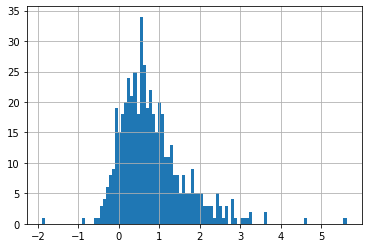

In [279]:
reg_param['slope'].hist(bins=100)

In [282]:
display(reg_param.mean())
display(feature_importance)


slope     0.782654
pvalue    0.398125
dtype: float64

ETF_C_O_t         12.219
ETF_O_C_t         11.608
NAV_C_C_t         24.997
future_C_C2_t     22.885
future_C_C_t       8.339
future_O_C_t-1    11.865
dtype: float64

In [1101]:
a=get_corr('ETF_O_C_t+1').sort_values([('HI','pvalue')]).sort_values(('HI','pvalue'))
a.reset_index().loc[pd.Series(a.index).apply(lambda x:True if x[-3:]!='t-1' else False)].set_index('index')

HI                      HC                     HCT  \
                     corr        pvalue      corr        pvalue      corr   
index                                                                       
ETF_C_C_t+1      0.932585  1.315276e-57  0.920283  3.436290e-53  0.962531   
future_C_C2_t+1  0.836428  1.049504e-34  0.811630  3.341083e-31  0.634979   
NAV_C_C_t+1      0.792042  8.782272e-29  0.841719  1.575561e-35  0.853381   
future_C_O_t+1   0.783114  9.157927e-28  0.750781  1.910002e-24  0.654551   
future_C_C_t+1   0.672992  4.454554e-18  0.633145  1.383807e-15  0.375144   
SP_O_C_t+1       0.404604  2.170862e-06  0.392813  4.511410e-06  0.199412   
SP_C_C_t+1       0.245212  5.274598e-03  0.234189  7.798722e-03  0.270861   
future_C_O_t    -0.236555  7.415240e-03 -0.285809  1.124876e-03 -0.194441   
future_O_C_t+1   0.206653  1.926325e-02  0.210010  1.734643e-02  0.074590   
future_C_C2_t   -0.192692  2.997305e-02 -0.269077  2.220851e-03 -0.148473   
future_C_C_t    -0.142251  1.120742e-01 -0.175133  4.982608e-02 -0.130262   
ETF_O_C_t       -0.125487  1.597981e-01 -0.147669  9.756350e-02 -0.072716   
future_O_C_t     0.104307  2.431939e-01  0.031578  7.245095e-01  0.078540   
ETF_C_C_t       -0.102037  2.536556e-01 -0.122171  1.712122e-01 -0.075210   
overnight_ret    0.092333  3.018578e-01  0.113276  2.047926e-01  0.046298   
ETF_O_C2_t       0.084468  3.450759e-01  0.139609  1.174803e-01  0.034282   
SP_C_O_t        -0.059895  5.018445e-01 -0.103699  2.440779e-01 -0.089450   
ETF_C_O_t        0.043951  6.222875e-01  0.026295  7.682828e-01 -0.037134   
ret              0.043951  6.222875e-01  0.026295  7.682828e-01 -0.037134   
SP_C_C_t        -0.043808  6.248086e-01 -0.089590  3.165057e-01 -0.073201   
NAV_C_C_t       -0.040551  6.508001e-01 -0.052448  5.581324e-01  0.034502   
ETF_O_C2_t+1     0.038438  6.691458e-01  0.050830  5.719040e-01 -0.101817   
SP_C_O_t+1       0.017281  8.464799e-01  0.011328  8.990127e-01  0.165622   
ETF_C_O_t+1      0.005494  9.509204e-01  0.080323  3.674317e-01  0.293920   
SP_O_C_t        -0.003420  9.695631e-01 -0.028362  7.515985e-01 -0.012196   

                                     XU                     IFB                
                       pvalue      corr        pvalue      corr        pvalue  
index                                                                          
ETF_C_C_t+1      1.073769e-39  0.978546  3.986825e-93  0.960591  8.447560e-71  
future_C_C2_t+1  4.634066e-09  0.803373  9.759552e-32  0.972284  4.018045e-80  
NAV_C_C_t+1      1.253072e-20  0.892465  8.094353e-48  0.907607  1.431264e-48  
future_C_O_t+1   1.059149e-09  0.794412  1.372302e-30  0.905572  5.182281e-48  
future_C_C_t+1   1.620753e-03  0.660746  3.727249e-18  0.899586  4.456635e-46  
SP_O_C_t+1       1.004404e-01  0.314561  2.026740e-04  0.163811  6.682462e-02  
SP_C_C_t+1       2.437952e-02  0.242384  4.619683e-03  0.178887  4.505070e-02  
future_C_O_t     1.120868e-01 -0.210116  1.481992e-02 -0.041605  6.450257e-01  
future_O_C_t+1   5.424463e-01  0.024975  7.737029e-01  0.223985  1.169242e-02  
future_C_C2_t    2.269135e-01 -0.202465  1.897121e-02 -0.049126  5.864040e-01  
future_C_C_t     2.934141e-01 -0.191990  2.683750e-02 -0.032616  7.191384e-01  
ETF_O_C_t        5.556611e-01 -0.048656  5.766504e-01 -0.047188  6.012752e-01  
future_O_C_t     5.243620e-01  0.073558  3.982958e-01 -0.022363  8.044852e-01  
ETF_C_C_t        5.421523e-01 -0.065071  4.550711e-01 -0.065363  4.689351e-01  
overnight_ret    7.077292e-01  0.048863  5.750256e-01  0.052305  5.623785e-01  
ETF_O_C2_t       7.813702e-01  0.201984  1.926285e-02  0.000070  9.993819e-01  
SP_C_O_t         4.648259e-01 -0.077090  3.741639e-01 -0.105487  2.397672e-01  
ETF_C_O_t        7.619427e-01 -0.087302  3.140057e-01 -0.082255  3.598470e-01  
ret              7.619427e-01 -0.087302  3.140057e-01 -0.082255  3.598470e-01  
SP_C_C_t         5.530254e-01 -0.083739  3.360701e-01 -0.050468  5.762068e-01  
NAV_C_C_t        7.799977e

In [1102]:
get_corr('ETF_O_C_t+1').sort_values([('HI','pvalue')]).sort_values(('HI','pvalue')).apply(lambda x:round(x,3))

HI            HC           HCT            XU         \
                  corr pvalue   corr pvalue   corr pvalue   corr pvalue   
index                                                                     
ETF_C_C_t+1      0.933  0.000  0.920  0.000  0.963  0.000  0.979  0.000   
future_C_C2_t+1  0.836  0.000  0.812  0.000  0.635  0.000  0.803  0.000   
NAV_C_C_t+1      0.792  0.000  0.842  0.000  0.853  0.000  0.892  0.000   
future_C_O_t+1   0.783  0.000  0.751  0.000  0.655  0.000  0.794  0.000   
future_C_C_t+1   0.673  0.000  0.633  0.000  0.375  0.002  0.661  0.000   
SP_O_C_t+1       0.405  0.000  0.393  0.000  0.199  0.100  0.315  0.000   
SP_C_C_t+1       0.245  0.005  0.234  0.008  0.271  0.024  0.242  0.005   
future_C_O_t    -0.237  0.007 -0.286  0.001 -0.194  0.112 -0.210  0.015   
future_O_C_t+1   0.207  0.019  0.210  0.017  0.075  0.542  0.025  0.774   
future_C_C2_t   -0.193  0.030 -0.269  0.002 -0.148  0.227 -0.202  0.019   
ETF_O_C_t-1      0.181  0.043  0.200  0.025 -0.125  0.313  0.047  0.589   
ETF_C_C_t-1      0.170  0.057  0.176  0.049 -0.082  0.507  0.061  0.486   
future_C_O_t-1   0.167  0.061  0.187  0.036 -0.032  0.799  0.133  0.128   
NAV_C_C_t-1      0.158  0.078  0.156  0.081 -0.186  0.131  0.125  0.153   
future_C_C_t    -0.142  0.112 -0.175  0.050 -0.130  0.293 -0.192  0.027   
SP_O_C_t-1       0.137  0.127  0.141  0.116  0.071  0.566  0.101  0.245   
ETF_O_C_t       -0.125  0.160 -0.148  0.098 -0.073  0.556 -0.049  0.577   
future_O_C_t     0.104  0.243  0.032  0.725  0.079  0.524  0.074  0.398   
ETF_C_C_t       -0.102  0.254 -0.122  0.171 -0.075  0.542 -0.065  0.455   
overnight_ret    0.092  0.302  0.113  0.205  0.046  0.708  0.049  0.575   
ETF_O_C2_t       0.084  0.345  0.140  0.117  0.034  0.781  0.202  0.019   
future_C_C_t-1   0.079  0.380  0.077  0.395 -0.136  0.278  0.069  0.429   
SP_C_C_t-1       0.074  0.408  0.057  0.523  0.121  0.331  0.079  0.363   
SP_C_O_t        -0.060  0.502 -0.104  0.244 -0.089  0.465 -0.077  0.374   
future_O_C_t-1   0.046  0.607  0.046  0.608 -0.103  0.405 -0.002  0.981   
ETF_C_O_t        0.044  0.622  0.026  0.768 -0.037  0.762 -0.087  0.314   
ret              0.044  0.622  0.026  0.768 -0.037  0.762 -0.087  0.314   
SP_C_C_t        -0.044  0.625 -0.090  0.317 -0.073  0.553 -0.084  0.336   
NAV_C_C_t       -0.041  0.651 -0.052  0.558  0.035  0.780 -0.041  0.639   
ETF_O_C2_t+1     0.038  0.669  0.051  0.572 -0.102  0.412 -0.107  0.218   
SP_C_O_t+1       0.017  0.846  0.011  0.899  0.166  0.174  0.079  0.361   
ETF_C_O_t-1      0.008  0.924  0.001  0.990  0.098  0.428  0.079  0.362   
SP_C_O_t-1      -0.008  0.927 -0.035  0.698  0.104  0.399  0.026  0.762   
ETF_C_O_t+1      0.005  0.951  0.080  0.367  0.294  0.014  0.111  0.200   
SP_O_C_t        -0.003  0.970 -0.028  0.752 -0.012  0.921 -0.047  0.587   

                   IFB         
                  corr pvalue  
index                          
ETF_C_C_t+1      0.961  0.000  
future_C_C2_t+1  0.972  0.000  
NAV_C_C_t+1      0.908  0.000  
future_C_O_t+1   0.906  0.000  
future_C_C_t+1   0.900  0.000  
SP_O_C_t+1       0.164  0.067  
SP_C_C_t+1       0.179  0.045  
future_C_O_t    -0.042  0.645  
future_O_C_t+1   0.224  0.012  
future_C_C2_t   -0.049  0.586  
ETF_O_C_t-1      0.084  0.353  
ETF_C_C_t-1      0.089  0.328  
future_C_O_t-1   0.054  0.550  
NAV_C_C_t-1      0.104  0.251  
future_C_C_t    -0.033  0.719  
SP_O_C_t-1       0.111  0.218  
ETF_O_C_t       -0.047  0.601  
future_O_C_t    -0.022  0.804  
ETF_C_C_t       -0.065  0.469  
overnight_ret    0.052  0.562  
ETF_O_C2_t       0.000  0.999  
future_C_C_t-1   0.053  0.561  
SP_C_C_t-1       0.051  0.576  
SP_C_O_t        -0.105  0.240  
future_O_C_t-1   0.091  0.312  
ETF_C_O_t       -0.082  0.360  
ret             -0.082  0.360  
SP_C_C_t        -0.050  0.576  
NAV_C_C_t       -0.004  0.965  
ETF_O_C2_t+1     0.003  0.973  
SP_C_O_t+1       0.113  0.207  
ETF_C_O_t-1      0.045  0.622  
SP_C_O_t-1      -0.020  0.823  
ETF_C_O_t+1      

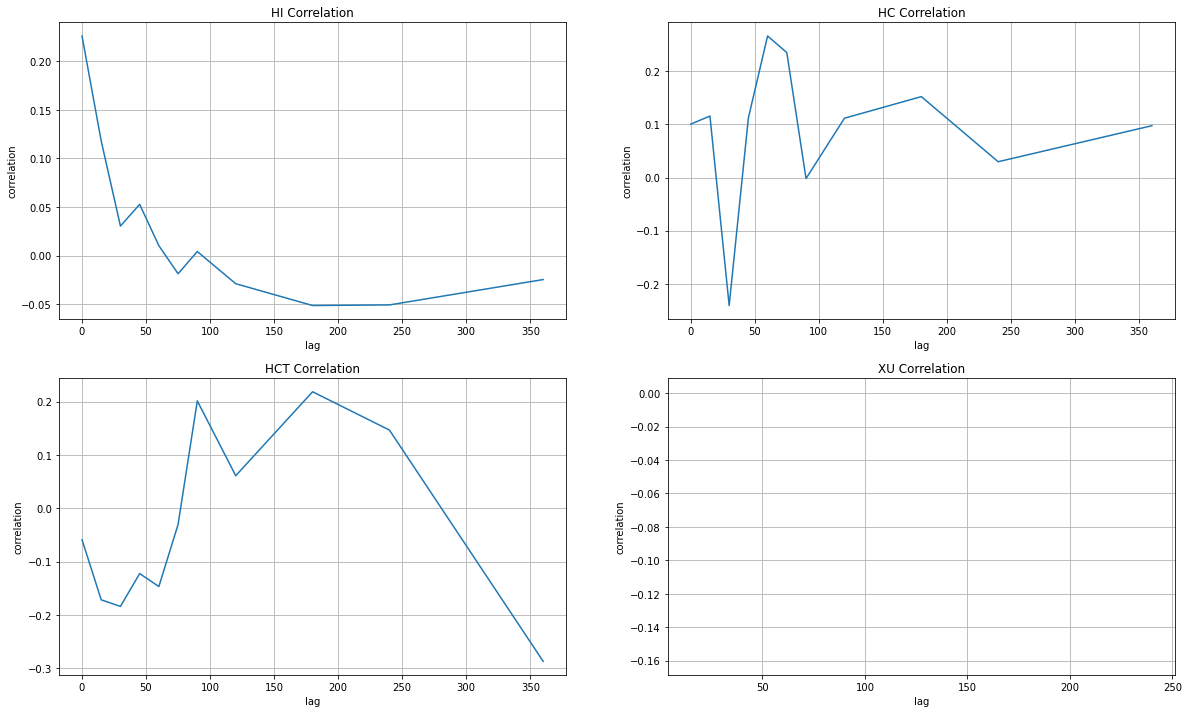

In [152]:
figure,axis=plt.subplots(2,2,figsize=(20,12))
plt.rcParams.update({'font.size':10})
count1,count2=0,0
for target1 in future_list[:4]:
    future_overnight=main(target1)
    for i in future_overnight.columns:
        if i.find('lag')!=-1:
            #pass
            future_overnight[i]=np.log(future_overnight[i]/future_overnight['predict_close'])
    #future_overnight['open_nextday_lag0']=np.log(future_overnight['open_nextday_lag0']/future_overnight['predict_close'])
    result=pd.DataFrame()
    import re
    result=pd.DataFrame()
    for i in future_overnight.columns:
        target='SP_C_C_t'
        if (i.find('next')!=-1)&(i[-1:].isdigit()):
            sub=future_overnight.copy()
            res=regression(sub[[i,target]].dropna(),mute=True,summary=False)
            result=pd.concat([result,pd.DataFrame([sub[i].corr(sub[target]),res.pvalues[1],res.rsquared],columns=[i])],axis=1)
    result=result.T
    result.columns=['corr','pvalue','Rsquare']
    result.sort_index()
    lag=pd.Series(result.index).apply(lambda x:re.match('.*?([0-9]+)$',x).group(1) if x[-1:].isdigit() else np.nan)
    lag.index=result.index
    result['lag']=lag.apply(lambda x:int(x))
    result=result.sort_values('lag').loc[[i for i in result.index if i.find('close')==-1]]
    #axis[count1,count2].rcParams.update({'font.size': 15})
    axis[count1,count2].set_title(target1+' Correlation')
    result=result.loc[result['lag']<400].set_index('lag')['corr']
    axis[count1,count2].plot(result.index,result)
    axis[count1,count2].grid()
    axis[count1,count2].set_ylabel('correlation')
    axis[count1,count2].set_xlabel('lag')
    count2+=1
    if count2>1:
        count1+=1
        count2=0

Text(0, 0.5, 'correlation')

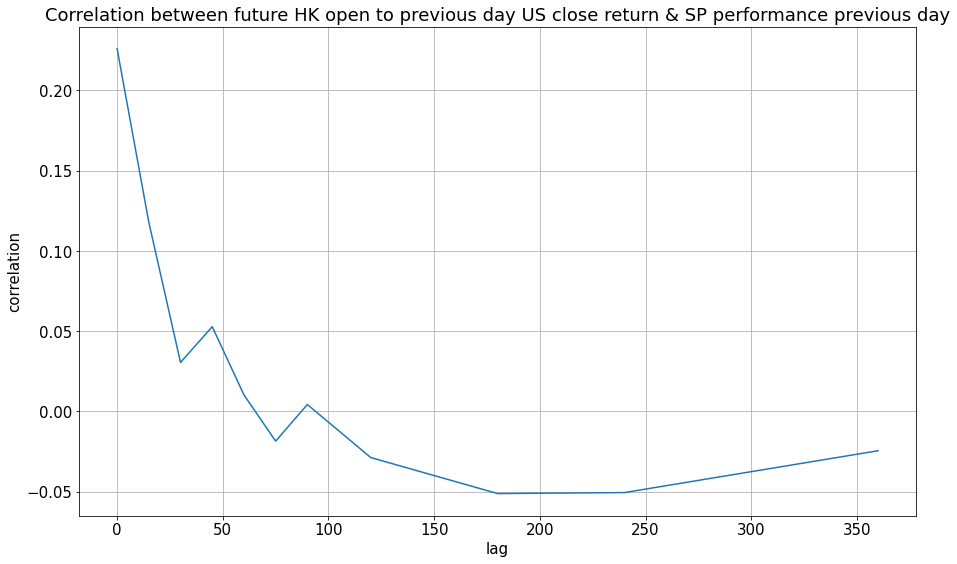

In [1249]:
plt.figure(figsize=(15,9))
plt.rcParams.update({'font.size': 15})
plt.title('Correlation between future HK open to previous day US close return & SP performance previous day')
result.loc[result['lag']<400].set_index('lag')['corr'].plot()
plt.grid()

plt.ylabel('correlation')

In [1266]:
display(pd.DataFrame(get_corr('future_O_C_t+1').loc['SP_C_O_t']).T)

HI                  HC                 HCT            \
              corr    pvalue      corr    pvalue      corr    pvalue   
SP_C_O_t  0.229415  0.008916  0.041622  0.639541  0.184077  0.127151   

                XU                 IFB            
              corr    pvalue      corr    pvalue  
SP_C_O_t  0.153809  0.073808 -0.045764  0.609423

In [1267]:
display(pd.DataFrame(get_corr('future_C_O_t+1').loc['SP_C_O_t']).T)

HI
HC
HCT
XU
IFB


HI                  HC                HCT                 XU  \
              corr    pvalue      corr    pvalue     corr    pvalue     corr   
SP_C_O_t -0.030561  0.730995  0.006877  0.938348 -0.03904  0.748305  0.00496   

                         IFB            
            pvalue      corr    pvalue  
SP_C_O_t  0.954296 -0.085761  0.337713

In [1268]:
display(pd.DataFrame(get_corr('ETF_O_C2_t+1').loc['SP_C_O_t']).T)

HI
HC
HCT
XU
IFB


HI                  HC                HCT                  XU  \
              corr    pvalue      corr    pvalue     corr    pvalue      corr   
SP_C_O_t -0.058965  0.510213 -0.069365  0.438395 -0.04368  0.723575 -0.054572   

                         IFB            
            pvalue      corr    pvalue  
SP_C_O_t  0.531138 -0.005251  0.953656

In [4517]:
result.dropna(inplace=True)

In [4518]:
result.sort_values('lag')

,corr,pvalue,Rsquare,lag
open_nextday_lag0,0.174376,0.158155,0.030407,0
close_nextday_lag0,0.092177,0.487460,0.008497,0
open_nextday_lag100,0.211509,0.110974,0.044736,100
open_nextday_lag120,0.179848,0.165462,0.032345,120
open_nextday_lag15,0.197315,0.089730,0.038933,15
open_nextday_lag240,0.021894,0.870415,0.000479,240
open_nextday_lag30,0.092681,0.488960,0.008590,30
open_nextday_lag360,-0.020677,0.874322,0.000428,360
open_nextday_lag45,0.125289,0.331906,0.015697,45
open_nextday_lag570,-0.022339,0.865467,0.000499,570


In [4506]:
import re
s=r"""99-my-name-is-John-Smith-6376827-%^-1-2-767980716"""
re.match('.*?([0-9]+)$', result.index[3]).group(1)

'30'

In [3550]:
result.loc[['open_nextday_lag0','open_nextday_lag15','open_nextday_lag30','open_nextday_lag45','open_nextday_lag60']]

,corr,pvalue,Rsquare
open_nextday_lag0,0.160106,0.071030,0.025634
open_nextday_lag15,0.023183,0.795059,0.000537
open_nextday_lag30,-0.080215,0.368078,0.006434
open_nextday_lag45,-0.027742,0.755917,0.000770
open_nextday_lag60,-0.049590,0.578292,0.002459


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         future_O_C_t+1   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     7.959
Date:                Wed, 18 Aug 2021   Prob (F-statistic):            0.00556
Time:                        10:30:57   Log-Likelihood:                 549.64
No. Observations:                 128   AIC:                            -1095.
Df Residuals:                     126   BIC:                            -1090.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.019      0.310      -0.000       0.001
SP_C_C_t       0.0961      0.034      2.821      0.006       0.029       0.163
==============================================================================
Omnibus:                        4.548   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.209
Skew:                           0.315   Prob(JB):                        0.122
Kurtosis:                       3.627   Cond. No.                         116.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00030253701985253603   0.09605521308196116
p-value: 0.30996427880294397   0.00556008359846828


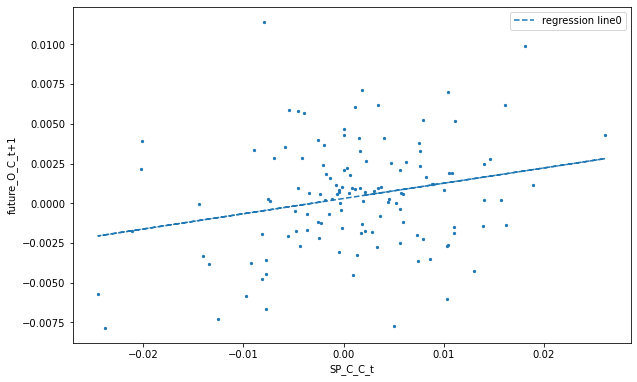

<Figure size 720x444.96 with 0 Axes>

In [3798]:
regression(future_overnight[['SP_C_C_t','future_O_C_t+1']])

In [3767]:
get_corr('future_O_C_t+1').sort_values([('HI','pvalue')]).loc[['SP_C_C_t','ETF_C_O_t','ETF_C_O_t-1','SP_C_O_t','future_C_O_t']].sort_values(('HI','pvalue'))

HI
HC
HCT
XU


HI                            HC                      \
                  corr    pvalue   Rsquare      corr    pvalue   Rsquare   
index                                                                      
SP_C_O_t      0.276008  0.001545  0.076180  0.200389  0.022788  0.040156   
SP_C_C_t      0.243754  0.005560  0.059416  0.158031  0.074815  0.024974   
ETF_C_O_t-1  -0.163795  0.064682  0.026829 -0.102730  0.248535  0.010553   
future_C_O_t  0.075889  0.394549  0.005759  0.058416  0.512479  0.003412   
ETF_C_O_t     0.069101  0.436492  0.004775 -0.038711  0.663155  0.001499   

                   HCT                            XU                      
                  corr    pvalue   Rsquare      corr    pvalue   Rsquare  
index                                                                     
SP_C_O_t      0.499106  0.000011  0.249107  0.068372  0.428997  0.004675  
SP_C_C_t      0.231584  0.055537  0.053631  0.030875  0.722228  0.000953  
ETF_C_O_t-1  -0.031002  0.800363  0.000961 -0.153677  0.075149  0.023617  
future_C_O_t  0.024910  0.839002  0.000621 -0.165609  0.054910  0.027426  
ETF_C_O_t    -0.205248  0.088286  0.042127 -0.076557  0.375696  0.005861

In [3915]:
get_corr('future_O_C_t+1').sort_values([('HI','pvalue')]).loc[['SP_C_C_t','ETF_C_O_t','ETF_C_O_t-1','SP_C_O_t','future_C_O_t']].sort_values(('HI','pvalue'))

HI
HC
HCT
XU


HI                            HC                      \
                  corr    pvalue   Rsquare      corr    pvalue   Rsquare   
index                                                                      
SP_C_O_t      0.229415  0.008916  0.052631  0.041622  0.639541  0.001732   
SP_C_C_t      0.225987  0.010319  0.051070  0.059250  0.506466  0.003511   
ETF_C_O_t-1  -0.103625  0.244418  0.010738 -0.087435  0.326398  0.007645   
future_C_O_t -0.034554  0.698600  0.001194 -0.100648  0.258304  0.010130   
ETF_C_O_t    -0.018866  0.831943  0.000356 -0.125493  0.156465  0.015748   

                   HCT                            XU                      
                  corr    pvalue   Rsquare      corr    pvalue   Rsquare  
index                                                                     
SP_C_O_t      0.184077  0.127151  0.033884  0.243093  0.004349  0.059094  
SP_C_C_t      0.103320  0.398210  0.010675  0.169897  0.048837  0.028865  
ETF_C_O_t-1  -0.066038  0.589805  0.004361 -0.107457  0.214781  0.011547  
future_C_O_t -0.029374  0.810646  0.000863 -0.166879  0.053050  0.027849  
ETF_C_O_t    -0.106972  0.378096  0.011443 -0.054068  0.531856  0.002923

In [3911]:
get_corr('future_C_O_t').sort_values([('HI','pvalue')])

HI
HC
HCT
XU


HI                                HC                \
                     corr        pvalue   Rsquare      corr        pvalue   
index                                                                       
future_C_C2_t    0.957938  3.609986e-70  0.917646  0.954559  4.226855e-68   
ETF_O_C_t        0.908797  1.148257e-49  0.825913  0.903223  4.035078e-48   
future_C_C_t     0.843538  1.509767e-35  0.711557  0.834285  4.041698e-34   
NAV_C_C_t        0.718672  1.284627e-21  0.516490  0.765592  6.712158e-26   
SP_O_C_t         0.194395  2.789399e-02  0.037789  0.184600  3.698027e-02   
open_next        0.167750  5.941196e-02  0.028140  0.129726  1.460485e-01   
NAV_C_C_t+1     -0.148625  9.538861e-02  0.022089 -0.178757  4.434626e-02   
SP_C_C_t         0.132367  1.363729e-01  0.017521  0.105505  2.359169e-01   
future_O_C_t    -0.126510  1.547432e-01  0.016005 -0.140007  1.149712e-01   
overnight_ret   -0.121638  1.731024e-01  0.014796 -0.121543  1.734403e-01   
ETF_O_C_t+1     -0.121638  1.731024e-01  0.014796 -0.121543  1.734403e-01   
SP_C_O_t+1       0.120306  1.778922e-01  0.014474  0.074346  4.061411e-01   
future_C_C_t+1  -0.118365  1.850461e-01  0.014010 -0.084867  3.427965e-01   
SP_C_O_t-1      -0.117429  1.868009e-01  0.013790 -0.107341  2.278172e-01   
ETF_C_O_t+1     -0.116176  1.933615e-01  0.013497 -0.140458  1.152456e-01   
SP_C_C_t-1      -0.095098  2.875474e-01  0.009044 -0.091308  3.072781e-01   
future_O_C_t-1   0.090093  3.137862e-01  0.008117  0.044339  6.206145e-01   
future_O_C_t+1   0.075889  3.945487e-01  0.005759  0.058416  5.124785e-01   
future_C_O_t-1  -0.073570  4.110703e-01  0.005413 -0.059197  5.085511e-01   
future_C_O_t+1  -0.073570  4.110703e-01  0.005413 -0.059197  5.085511e-01   
ETF_C_O_t       -0.069193  4.376981e-01  0.004788 -0.050792  5.691034e-01   
ret             -0.069193  4.376981e-01  0.004788 -0.050792  5.691034e-01   
ETF_O_C_t-1     -0.067527  4.506553e-01  0.004560 -0.058849  5.110483e-01   
SP_C_C_t+1       0.067502  4.508193e-01  0.004557  0.030513  7.334486e-01   
ETF_C_O_t-1      0.065063  4.656000e-01  0.004233  0.091669  3.034254e-01   
future_C_C2_t+1 -0.051118  5.681734e-01  0.002613 -0.041564  6.426676e-01   
NAV_C_C_t-1      0.050051  5.762865e-01  0.002505  0.055486  5.355295e-01   
future_C_C_t-1   0.031302  7.278791e-01  0.000980  0.014571  8.713557e-01   
SP_O_C_t+1      -0.031062  7.288394e-01  0.000965 -0.038655  6.661271e-01   
SP_C_O_t         0.028760  7.472567e-01  0.000827 -0.001073  9.904090e-01   
SP_O_C_t-1      -0.021192  8.130550e-01  0.000449 -0.026913  7.639107e-01   

                                HCT                                XU  \
                  Rsquare      corr        pvalue   Rsquare      corr   
index                                                                   
future_C_C2_t    0.911183  0.892548  7.275506e-25  0.796641  0.994449   
ETF_O_C_t        0.815812  0.651876  1.304080e-09  0.424942  0.968727   
future_C_C_t     0.696032  0.631211  7.900951e-09  0.398427  0.944478   
NAV_C_C_t        0.586131  0.634127  4.929934e-09  0.402117  0.847210   
SP_O_C_t         0.034077  0.049436  6.866587e-01  0.002444  0.193367   
open_next        0.016829  0.135402  2.709277e-01  0.018334  0.125416   
NAV_C_C_t+1      0.031954 -0.029439  8.116414e-01  0.000867 -0.038932   
SP_C_C_t         0.011131  0.080667  5.099552e-01  0.006507  0.159346   
future_O_C_t     0.019602 -0.139617  2.525510e-01  0.019493 -0.091287   
overnight_ret    0.014773 -0.152671  2.138971e-01  0.023309 -0.067921   
ETF_O_C_t+1      0.014773 -0.152671  2.138971e-01  0.023309 -0.067921   
SP_C_O_t+1       0.005527  0.157968  1.982397e-01  0.024954  0.000190   
future_C_C_t+1   0.007202 -0.110574  3.693622e-01  0.012227 -0.034769   
SP_C_O_t-1       0.011522 -0.143034  2.410110e-01  0.020459 -0.099450   
ETF_C_O_t+1      0.019728 -0.187123  1.265176e-01  0.035015 -0.154293   
SP_C_C_t-1       0.008337 -0.250447  3.940766e-02  0.062724 -0.094217   
future_O_C_t-1   

In [3787]:
get_corr('future_C_C2_t+1').sort_values([('HI','pvalue')])

HI
HC
HCT
XU


HI                                HC                \
                    corr        pvalue   Rsquare      corr        pvalue   
index                                                                      
future_C_O_t+1  0.957938  3.609986e-70  0.917646  0.954559  4.226855e-68   
ETF_O_C_t+1     0.951400  2.642839e-66  0.905162  0.948417  1.026932e-64   
overnight_ret   0.951400  2.642839e-66  0.905162  0.948417  1.026932e-64   
future_C_C_t+1  0.891909  6.599530e-45  0.795502  0.867907  8.465231e-40   
NAV_C_C_t+1     0.773928  9.130669e-27  0.598964  0.813526  1.882650e-31   
open_next       0.282668  1.225629e-03  0.079901  0.227907  9.672586e-03   
SP_O_C_t+1      0.267719  2.249421e-03  0.071674  0.247983  4.767948e-03   
NAV_C_C_t-1     0.219376  1.358368e-02  0.048126  0.244036  5.891463e-03   
ETF_O_C_t-1     0.210725  1.786190e-02  0.044405  0.229465  9.747714e-03   
SP_O_C_t-1      0.183286  3.994584e-02  0.033594  0.188807  3.423358e-02   
future_C_O_t-1  0.173160  5.249877e-02  0.029984  0.213245  1.650951e-02   
SP_C_C_t+1      0.166302  6.063901e-02  0.027656  0.136387  1.247633e-01   
future_O_C_t+1  0.163480  6.520487e-02  0.026726  0.161441  6.867637e-02   
future_C_C_t-1  0.145491  1.054635e-01  0.021168  0.195903  2.855890e-02   
SP_C_C_t-1      0.139585  1.190283e-01  0.019484  0.123328  1.688795e-01   
ETF_C_O_t       0.084574  3.425374e-01  0.007153  0.076510  3.906832e-01   
ret             0.084574  3.425374e-01  0.007153  0.076510  3.906832e-01   
future_O_C_t    0.077058  3.891851e-01  0.005938  0.029961  7.380962e-01   
NAV_C_C_t       0.070324  4.320708e-01  0.004946  0.065022  4.676613e-01   
ETF_C_O_t-1     0.057414  5.214204e-01  0.003296  0.027788  7.564703e-01   
future_C_O_t   -0.051118  5.681734e-01  0.002613 -0.041564  6.426676e-01   
SP_C_O_t-1      0.046409  6.043790e-01  0.002154  0.019288  8.295818e-01   
ETF_O_C_t      -0.043936  6.237955e-01  0.001930 -0.045993  6.076246e-01   
ETF_C_O_t+1    -0.041018  6.457296e-01  0.001682  0.000092  9.991810e-01   
future_O_C_t-1 -0.037908  6.734458e-01  0.001437 -0.072362  4.206907e-01   
SP_C_O_t       -0.036924  6.790264e-01  0.001363 -0.046357  6.033358e-01   
future_C_C2_t  -0.028569  7.498468e-01  0.000816 -0.032431  7.173781e-01   
future_C_C_t    0.027094  7.632948e-01  0.000734  0.012532  8.892360e-01   
SP_C_C_t       -0.023656  7.917891e-01  0.000560 -0.042968  6.314694e-01   
SP_C_O_t+1      0.017127  8.478364e-01  0.000293 -0.008953  9.201022e-01   
SP_O_C_t        0.002877  9.743888e-01  0.000008 -0.018329  8.379372e-01   

                                   HCT                                XU  \
                     Rsquare      corr        pvalue   Rsquare      corr   
index                                                                      
future_C_O_t+1  9.111830e-01  0.892443  3.360453e-25  0.796455  0.994449   
ETF_O_C_t+1     8.994943e-01  0.670599  2.906803e-10  0.449703  0.976657   
overnight_ret   8.994943e-01  0.670599  2.906803e-10  0.449703  0.976657   
future_C_C_t+1  7.532633e-01  0.753548  1.216519e-13  0.567835  0.949218   
NAV_C_C_t+1     6.618244e-01  0.596642  6.293738e-08  0.355982  0.859950   
open_next       5.194148e-02  0.202015  9.598986e-02  0.040810  0.143975   
SP_O_C_t+1      6.149550e-02  0.021142  8.631000e-01  0.000447  0.227615   
NAV_C_C_t-1     5.955366e-02 -0.014376  9.073698e-01  0.000207  0.175691   
ETF_O_C_t-1     5.265421e-02  0.145830  2.353837e-01  0.021266  0.105957   
SP_O_C_t-1      3.564795e-02 -0.019405  8.751957e-01  0.000377  0.131682   
future_C_O_t-1  4.547325e-02  0.055670  6.520599e-01  0.003099  0.117341   
SP_C_C_t+1      1.860130e-02 -0.020473  8.673896e-01  0.000419  0.179388   
future_O_C_t+1  2.606327e-02  0.323412  6.315276e-03  0.104595  0.014003   
future_C_C_t-1  3.837807e-02 -0.007170  9.540769e-01  0.000051  0.130736   
SP_C_C_t-1      1.520976e-02 -0.044305  7.197828e-01  0.001963  0.091545   
ETF_C_O_t       5.853774e-03  0.155300  1.992334e-01  0.024118 -0.102

In [3695]:
get_corr('future_O_C_t+1').sort_values(('HI','pvalue'))

HI                            HC                      \
                     corr    pvalue   Rsquare      corr    pvalue   Rsquare   
index                                                                         
SP_C_O_t         0.343172  0.000069  0.117767  0.192866  0.028537  0.037197   
SP_C_C_t         0.275208  0.001666  0.075739  0.143804  0.105357  0.020679   
future_C_C2_t+1  0.230161  0.008959  0.052974  0.230175  0.008955  0.052980   
future_C_C_t+1   0.224965  0.010995  0.050609  0.176114  0.047637  0.031016   
ETF_O_C_t+1      0.206653  0.019263  0.042705  0.210010  0.017346  0.044104   
overnight_ret    0.206653  0.019263  0.042705  0.210010  0.017346  0.044104   
SP_C_O_t-1      -0.201217  0.022755  0.040488 -0.228564  0.009460  0.052241   
open_next        0.192969  0.029085  0.037237  0.230781  0.008771  0.053260   
NAV_C_C_t+1      0.176698  0.046019  0.031222  0.202332  0.021997  0.040938   
SP_O_C_t+1       0.163739  0.064774  0.026811  0.111853  0.208751  0.012511   
SP_C_C_t-1      -0.124453  0.163296  0.015489 -0.096092  0.282515  0.009234   
SP_C_C_t+1       0.118384  0.183218  0.014015  0.126527  0.154685  0.016009   
future_O_C_t-1   0.111876  0.210480  0.012516  0.008867  0.921185  0.000079   
ETF_C_O_t-1     -0.103625  0.244418  0.010738 -0.087435  0.326398  0.007645   
SP_O_C_t         0.098166  0.270291  0.009637  0.038771  0.663926  0.001503   
future_C_C_t    -0.097110  0.277424  0.009430 -0.122971  0.168405  0.015122   
future_C_O_t+1  -0.087736  0.324728  0.007698 -0.080664  0.365394  0.006507   
future_O_C_t    -0.076557  0.390388  0.005861 -0.001677  0.985013  0.000003   
NAV_C_C_t-1     -0.061419  0.492739  0.003772 -0.046298  0.605247  0.002143   
future_C_C2_t   -0.057939  0.515941  0.003357 -0.098784  0.267272  0.009758   
future_C_O_t-1  -0.051739  0.563472  0.002677 -0.004137  0.963178  0.000017   
ETF_C_O_t+1     -0.042518  0.633691  0.001808  0.006649  0.940618  0.000044   
future_C_O_t    -0.034554  0.698600  0.001194 -0.100648  0.258304  0.010130   
SP_C_O_t+1       0.022948  0.797088  0.000527  0.089275  0.316282  0.007970   
ETF_O_C_t-1     -0.022747  0.799620  0.000517 -0.004867  0.956695  0.000024   
ETF_O_C_t       -0.022506  0.800918  0.000507 -0.060725  0.495927  0.003688   
ETF_C_O_t       -0.018866  0.831943  0.000356 -0.125493  0.156465  0.015748   
ret             -0.018866  0.831943  0.000356 -0.125493  0.156465  0.015748   
NAV_C_C_t       -0.011131  0.900764  0.000124 -0.065641  0.461640  0.004309   
future_C_C_t-1   0.005028  0.955437  0.000025  0.037902  0.673490  0.001437   
SP_O_C_t-1       0.001986  0.982321  0.000004  0.072776  0.416154  0.005296   

                      HCT                            XU                      
                     corr    pvalue   Rsquare      corr    pvalue   Rsquare  
index                                                                        
SP_C_O_t         0.076238  0.530476  0.005812  0.243093  0.004349  0.059094  
SP_C_C_t         0.015955  0.896473  0.000255  0.169897  0.048837  0.028865  
future_C_C2_t+1  0.319807  0.006959  0.102276 -0.079721  0.358028  0.006356  
future_C_C_t+1   0.169352  0.167398  0.028680 -0.086108  0.322532  0.007415  
ETF_O_C_t+1      0.074590  0.542446  0.005564 -0.042141  0.627467  0.001776  
overnight_ret    0.074590  0.542446  0.005564 -0.042141  0.627467  0.001776  
SP_C_O_t-1      -0.321827  0.007005  0.103573 -0.144142  0.095330  0.020777  
open_next        0.103609  0.396883  0.010735  0.085353  0.324974  0.007285  
NAV_C_C_t+1      0.013299  0.913632  0.000177 -0.046219  0.594511  0.002136  
SP_O_C_t+1       0.178284  0.142743  0.031785  0.195060  0.023382  0.038048  
SP_C_C_t-1      -0.099371  0.420104  0.009875 -0.148819  0.086137  0.022147  
SP_C_C_t+1       0.191087  0.115761  0.036514  0.057917  0.504622  0.003354  
future_O_C_t-1   0.039734  0.747671  0.001579  0.079242  0.362753  0.006279  
ETF_C_O_t-1     -0.066038  0.589805  0.004361 -0.107457  0.214781  0.011547  
SP_O_C_t  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     172.1
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           2.29e-36
Time:                        12:56:36   Log-Likelihood:                 453.99
No. Observations:                 126   AIC:                            -902.0
Df Residuals:                     123   BIC:                            -893.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.488      0.139      -0.002       0.000
SP_C_C_t-1    -0.2214      0.066     -3.376      0.001      -0.351      -0.092
NAV_C_C_t      0.6246      0.034     18.360      0.000       0.557       0.692
==============================================================================
Omnibus:                        1.865   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.370
Skew:                          -0.168   Prob(JB):                        0.504
Kurtosis:                       3.385   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.0008965387057070652   -0.2213918620308996
p-value: 0.1393820177572803   0.0009856673471365029


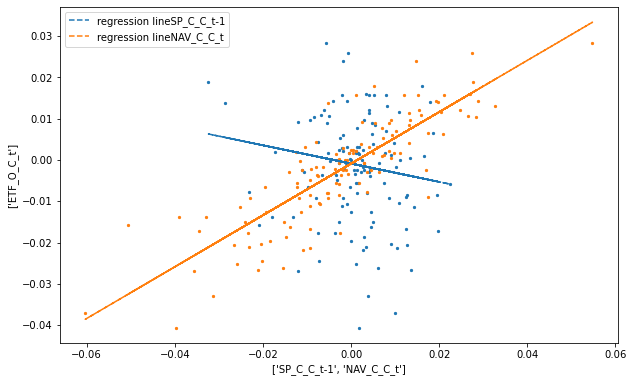

<Figure size 720x444.96 with 0 Axes>

In [3280]:
regression(future_overnight_dic['HC'],target1=['SP_C_C_t-1','NAV_C_C_t'],target2=['ETF_O_C_t'])

In [3263]:
corr_dic={}
future_overnight_dic={}

In [3165]:
corr.columns=corr.columns.droplevel(1)

In [3166]:
target='HI'


In [2648]:
future_overnight['close_next']=future_overnight['close'].shift(-1)

In [2652]:
future_overnight['close_to_close_ret']=np.log(future_overnight['close_next']/future_overnight['close'])

In [2636]:
sub=get_price_future('HI')
sub.index=sub.index.tz_convert('US/Eastern')
get_minmaxtime(sub)

,0,1
2020-12-04,2020-12-04 04:15:00-05:00,2020-12-04 13:59:00-05:00
2020-12-06,2020-12-06 20:13:00-05:00,2020-12-06 23:59:00-05:00
2020-12-07,2020-12-07 00:00:00-05:00,2020-12-07 23:59:00-05:00
2020-12-08,2020-12-08 00:00:00-05:00,2020-12-08 23:59:00-05:00
2020-12-09,2020-12-09 00:00:00-05:00,2020-12-09 23:59:00-05:00
2020-12-10,2020-12-10 00:00:00-05:00,2020-12-10 23:59:00-05:00
2020-12-11,2020-12-11 00:00:00-05:00,2020-12-11 13:59:00-05:00
2020-12-13,2020-12-13 20:13:00-05:00,2020-12-13 23:59:00-05:00
2020-12-14,2020-12-14 00:00:00-05:00,2020-12-14 23:59:00-05:00
2020-12-15,2020-12-15 00:00:00-05:00,2020-12-15 23:59:00-05:00


In [2483]:
def lookup_time(df,month='',day='',hour='',minute='',year=''):
    c0,c1,c2,c3,c4=[pd.Series() for i in range(5)]
    if month!='':
        c0=(df.index.month==month)
    if day!='':
        c1=(df.index.day==day)
    if hour!='':
        c2=(df.index.hour==hour)
    if minute!='':
        c3=(df.index.minute==minute)
    if year!='':
        c4=(df.index.year==year)
    #display(c1,c2,c3,c4)
    return df.loc[c1&c2&c3&c0]

In [2540]:
a.index=a.index.tz_convert('Hongkong')

In [2537]:
a.index=a.index.tz_convert('US/Eastern')

In [4196]:
def dailyfy(sub,target=''):
    sub_daily=sub.groupby(sub.index.date).apply(lambda x:pd.Series([x.head(1)['open'].iloc[0],x.tail(1)['close'].iloc[0],x['high'].max(),x['low'].min()]))
    sub_daily.columns=['open','close','high','low']
    sub_dayret=np.log(sub_daily['close']/sub_daily['open'])
    sub_overnightret=np.log(sub_daily['open']/sub_daily['close'].shift(1))
    sub_closetocloseret=np.log(sub_daily['close'].pct_change()+1)
    sub_ret=pd.concat([sub_dayret,sub_overnightret,sub_closetocloseret],axis=1)
    sub_ret.columns=['daytime ret','overnight ret','day to day ret']
    sub_ret.index=pd.Series(sub_ret.index).apply(lambda x:pd.to_datetime(x,format='%Y-%m-%d'))
    if target!='':
        sub_ret=pd.merge(sub_ret,NAV_ret[target],left_index=True,right_index=True).rename(columns={target:'NAV ret'})
    
    return sub_ret

In [4399]:
paper_data_dic=pd.read_excel(path_data+'/paper_data_hardcode2.xlsx',sheet_name=['Open','Close','NAV'],index_col=0)
paper_open=paper_data_dic['Open']
paper_close=paper_data_dic['Close']
paper_NAV=paper_data_dic['NAV']

In [4533]:
target='FXI'
target_name=target+' US Equity'
target_future='HI'
NAV_C_C_t=np.log(paper_NAV[target_name].pct_change()+1)
test=pd.merge(SP_C_C_t.shift(1),NAV_C_C_t,left_index=True,right_index=True)
temp=pd.merge(paper_open[target_name].rename('open'),paper_close[target_name].shift(1).rename('close_t-1'),left_index=True,right_index=True)
temp['ETF_O_C_t']=np.log(temp['open']/temp['close_t-1'])
test=pd.merge(test,temp['ETF_O_C_t'],left_index=True,right_index=True)
#test=test.loc[test.index.year<=2013]
#test=test.loc[test.index.year>2013]

FXI


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     123.4
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           2.69e-28
Time:                        08:15:37   Log-Likelihood:                 12238.
No. Observations:                4398   AIC:                        -2.447e+04
Df Residuals:                    4396   BIC:                        -2.446e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.875      0.381      -0.000       0.001
SPX Index     -0.2125      0.019    -11.109      0.000      -0.250      -0.175
==============================================================================
Omnibus:                      614.291   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6894.679
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                       9.112   Cond. No.                         84.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00019774018231069558   -0.2124508438849035
p-value: 0.3814729562140202   2.687776066078513e-28


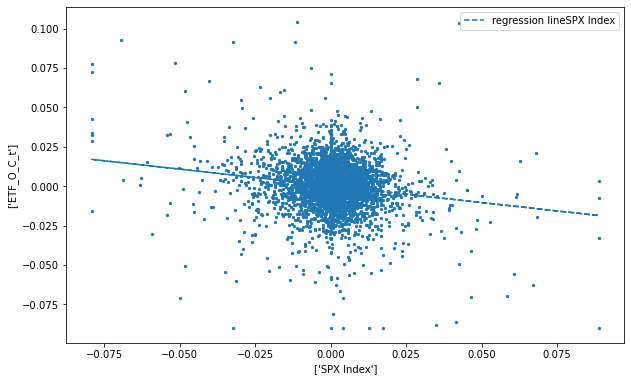

<Figure size 720x444.96 with 0 Axes>

,SPX Index,FXI US Equity,ETF_O_C_t
SPX Index,1.000000,0.358113,-0.165249
FXI US Equity,0.358113,1.000000,0.662920
ETF_O_C_t,-0.165249,0.662920,1.000000


KWEB


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     8.824
Date:                Thu, 19 Aug 2021   Prob (F-statistic):            0.00301
Time:                        08:15:38   Log-Likelihood:                 5840.7
No. Observations:                2099   AIC:                        -1.168e+04
Df Residuals:                    2097   BIC:                        -1.167e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.949      0.000       0.001       0.002
SPX Index     -0.0939      0.032     -2.971      0.003      -0.156      -0.032
==============================================================================
Omnibus:                     2103.927   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           750548.855
Skew:                           4.111   Prob(JB):                         0.00
Kurtosis:                      95.272   Cond. No.                         96.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0016198139638446442   -0.09394048974525532
p-value: 8.0707344461822e-07   0.0030064599432385077


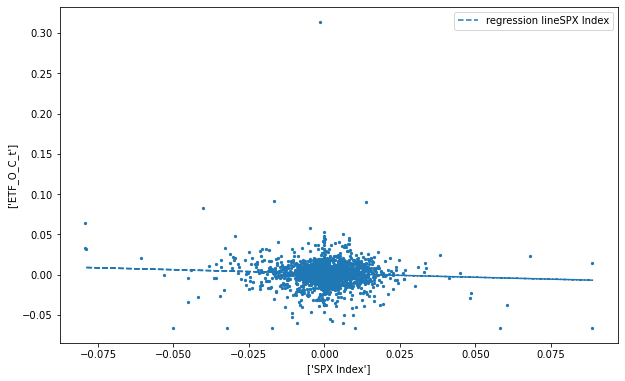

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KWEB US Equity,ETF_O_C_t
SPX Index,1.000000,0.010964,-0.064733
KWEB US Equity,0.010964,1.000000,0.608352
ETF_O_C_t,-0.064733,0.608352,1.000000


MCHI


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     15.94
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           6.71e-05
Time:                        08:15:38   Log-Likelihood:                 8005.3
No. Observations:                2709   AIC:                        -1.601e+04
Df Residuals:                    2707   BIC:                        -1.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.646      0.100   -7.62e-05       0.001
SPX Index     -0.0921      0.023     -3.993      0.000      -0.137      -0.047
==============================================================================
Omnibus:                      267.414   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.911
Skew:                          -0.234   Prob(JB):                         0.00
Kurtosis:                       6.801   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00039915016969989224   -0.09210487075689755
p-value: 0.09978138238879967   6.711803475302471e-05


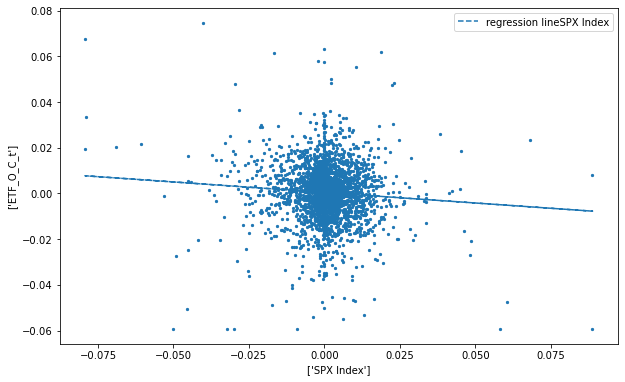

<Figure size 720x444.96 with 0 Axes>

,SPX Index,MCHI US Equity,ETF_O_C_t
SPX Index,1.000000,0.254922,-0.076511
MCHI US Equity,0.254922,1.000000,0.734563
ETF_O_C_t,-0.076511,0.734563,1.000000


ASHR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     27.95
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.38e-07
Time:                        08:15:38   Log-Likelihood:                 5528.6
No. Observations:                2030   AIC:                        -1.105e+04
Df Residuals:                    2028   BIC:                        -1.104e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.252      0.211      -0.000       0.001
SPX Index     -0.1786      0.034     -5.287      0.000      -0.245      -0.112
==============================================================================
Omnibus:                      333.936   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5033.980
Skew:                          -0.259   Prob(JB):                         0.00
Kurtosis:                      10.697   Cond. No.                         95.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0004420051234807873   -0.17857595398165105
p-value: 0.2108303796740238   1.3808788639071697e-07


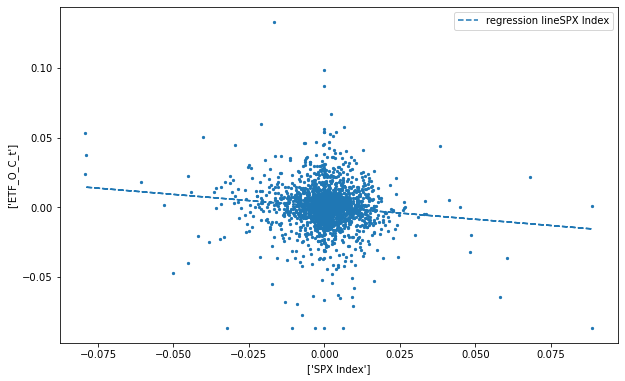

<Figure size 720x444.96 with 0 Axes>

,SPX Index,ASHR US Equity,ETF_O_C_t
SPX Index,1.000000,0.131413,-0.116590
ASHR US Equity,0.131413,1.000000,0.826226
ETF_O_C_t,-0.116590,0.826226,1.000000


EWH


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     87.11
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.45e-20
Time:                        08:15:38   Log-Likelihood:                 16699.
No. Observations:                5643   AIC:                        -3.339e+04
Df Residuals:                    5641   BIC:                        -3.338e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.585      0.113   -6.27e-05       0.001
SPX Index     -0.1285      0.014     -9.333      0.000      -0.156      -0.102
==============================================================================
Omnibus:                      607.888   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4617.507
Skew:                          -0.213   Prob(JB):                         0.00
Kurtosis:                       7.411   Cond. No.                         82.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0002648536498418312   -0.12852889889270458
p-value: 0.11301029280762198   1.4455755724089594e-20


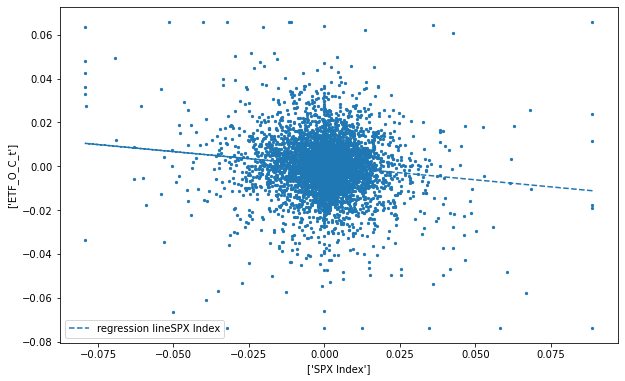

<Figure size 720x444.96 with 0 Axes>

,SPX Index,EWH US Equity,ETF_O_C_t
SPX Index,1.000000,0.369272,-0.123316
EWH US Equity,0.369272,1.000000,0.655941
ETF_O_C_t,-0.123316,0.655941,1.000000


YINN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     32.87
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.08e-08
Time:                        08:15:38   Log-Likelihood:                 5841.1
No. Observations:                3054   AIC:                        -1.168e+04
Df Residuals:                    3052   BIC:                        -1.167e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.035      0.301      -0.001       0.002
SPX Index     -0.3535      0.062     -5.733      0.000      -0.474      -0.233
==============================================================================
Omnibus:                      303.972   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1648.582
Skew:                          -0.310   Prob(JB):                         0.00
Kurtosis:                       6.546   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0006701351857508448   -0.35353375585494573
p-value: 0.3008211732265256   1.0828029233635164e-08


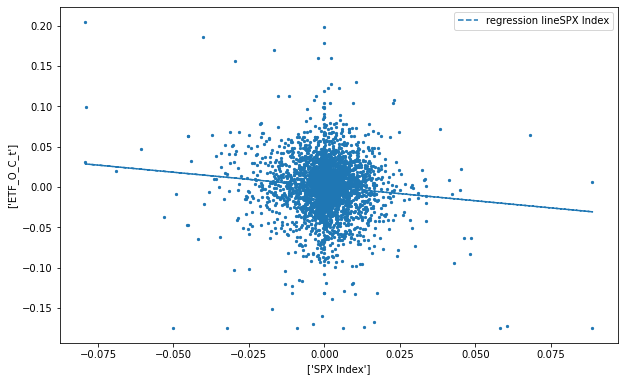

<Figure size 720x444.96 with 0 Axes>

,SPX Index,YINN US Equity,ETF_O_C_t
SPX Index,1.000000,-0.118688,-0.103221
YINN US Equity,-0.118688,1.000000,0.799769
ETF_O_C_t,-0.103221,0.799769,1.000000


CQQQ


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.737
Date:                Thu, 19 Aug 2021   Prob (F-statistic):             0.0533
Time:                        08:15:39   Log-Likelihood:                 9040.7
No. Observations:                3051   AIC:                        -1.808e+04
Df Residuals:                    3049   BIC:                        -1.807e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      4.104      0.000       0.000       0.001
SPX Index     -0.0417      0.022     -1.933      0.053      -0.084       0.001
==============================================================================
Omnibus:                      339.436   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1370.582
Skew:                          -0.490   Prob(JB):                    2.41e-298
Kurtosis:                       6.134   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.000929907986025109   -0.041700007104901814
p-value: 4.166949010443462e-05   0.05329814219343784


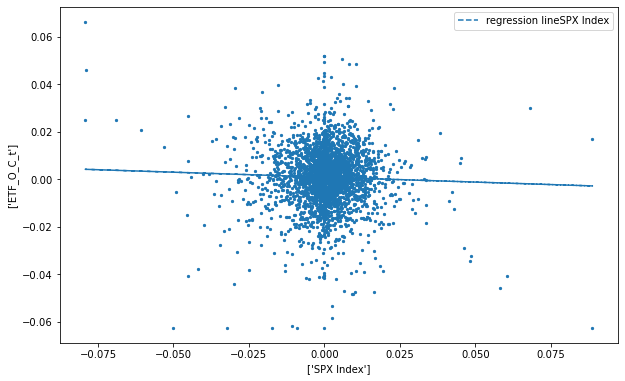

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CQQQ US Equity,ETF_O_C_t
SPX Index,1.000000,0.113994,-0.034990
CQQQ US Equity,0.113994,1.000000,0.742013
ETF_O_C_t,-0.034990,0.742013,1.000000


CXSE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.520
Date:                Thu, 19 Aug 2021   Prob (F-statistic):              0.113
Time:                        08:15:39   Log-Likelihood:                 6801.0
No. Observations:                2325   AIC:                        -1.360e+04
Df Residuals:                    2323   BIC:                        -1.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.408      0.159      -0.000       0.001
SPX Index     -0.0424      0.027     -1.588      0.113      -0.095       0.010
==============================================================================
Omnibus:                      290.330   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2589.359
Skew:                          -0.241   Prob(JB):                         0.00
Kurtosis:                       8.148   Cond. No.                         99.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.000379752187843804   -0.04240120431177473
p-value: 0.15927242972374264   0.11252217207198714


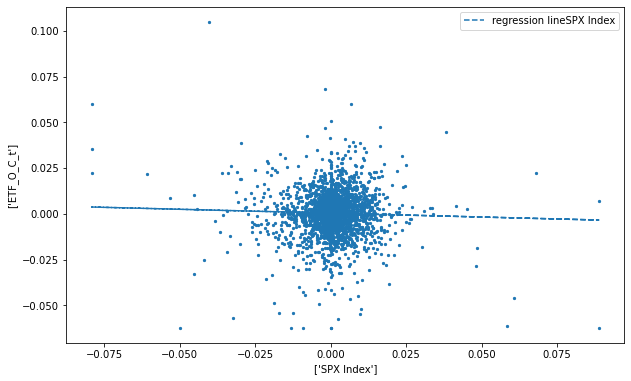

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CXSE US Equity,ETF_O_C_t
SPX Index,1.000000,0.153882,-0.032921
CXSE US Equity,0.153882,1.000000,0.727033
ETF_O_C_t,-0.032921,0.727033,1.000000


GXC


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     69.61
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.00e-16
Time:                        08:15:39   Log-Likelihood:                 10703.
No. Observations:                3758   AIC:                        -2.140e+04
Df Residuals:                    3756   BIC:                        -2.139e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      3.121      0.002       0.000       0.001
SPX Index     -0.1528      0.018     -8.343      0.000      -0.189      -0.117
==============================================================================
Omnibus:                      575.804   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7570.413
Skew:                           0.274   Prob(JB):                         0.00
Kurtosis:                       9.932   Cond. No.                         80.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.000714443552914042   -0.15276388037918642
p-value: 0.0018153012426397053   1.0046352328331135e-16


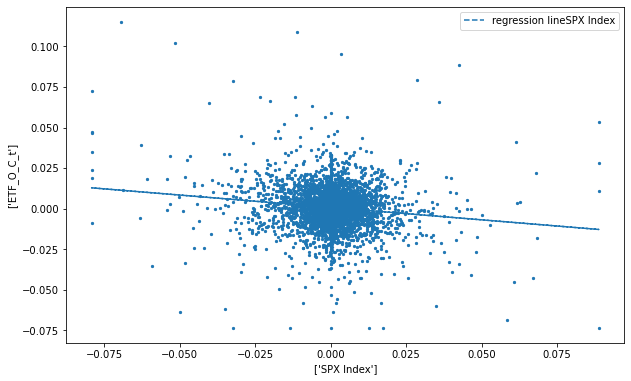

<Figure size 720x444.96 with 0 Axes>

,SPX Index,GXC US Equity,ETF_O_C_t
SPX Index,1.000000,0.328228,-0.134889
GXC US Equity,0.328228,1.000000,0.657665
ETF_O_C_t,-0.134889,0.657665,1.000000


CHIQ


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.71
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           0.000217
Time:                        08:15:39   Log-Likelihood:                 9116.5
No. Observations:                3056   AIC:                        -1.823e+04
Df Residuals:                    3054   BIC:                        -1.822e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.604      0.546      -0.000       0.001
SPX Index     -0.0783      0.021     -3.703      0.000      -0.120      -0.037
==============================================================================
Omnibus:                      352.986   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2266.654
Skew:                          -0.345   Prob(JB):                         0.00
Kurtosis:                       7.162   Cond. No.                         95.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00013414704328717835   -0.07826817882474235
p-value: 0.5455834934240373   0.00021678415998281763


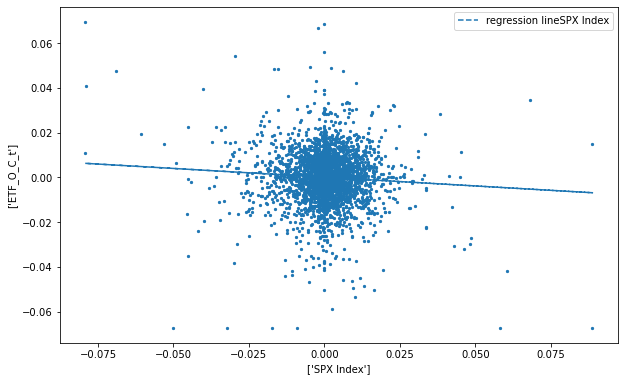

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CHIQ US Equity,ETF_O_C_t
SPX Index,1.000000,0.218355,-0.066858
CHIQ US Equity,0.218355,1.000000,0.755199
ETF_O_C_t,-0.066858,0.755199,1.000000


CWEB


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     10.24
Date:                Thu, 19 Aug 2021   Prob (F-statistic):            0.00141
Time:                        08:15:39   Log-Likelihood:                 2639.6
No. Observations:                1250   AIC:                            -5275.
Df Residuals:                    1248   BIC:                            -5265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.140      0.002       0.001       0.004
SPX Index     -0.2293      0.072     -3.200      0.001      -0.370      -0.089
==============================================================================
Omnibus:                      141.037   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.512
Skew:                          -0.522   Prob(JB):                    1.13e-107
Kurtosis:                       5.892   Cond. No.                         86.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.002607189501108158   -0.22928031980984365
p-value: 0.0017289323417018288   0.0014100845726874901


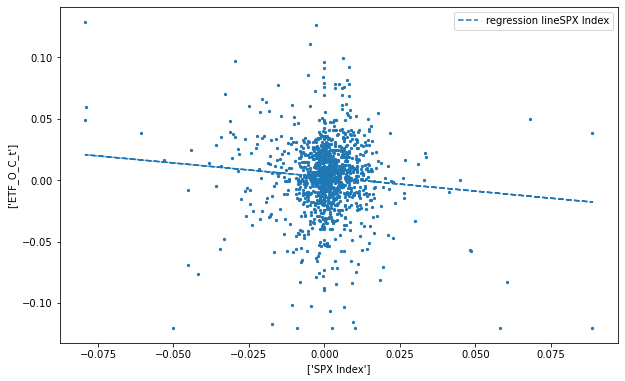

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CWEB US Equity,ETF_O_C_t
SPX Index,1.000000,-0.133695,-0.090206
CWEB US Equity,-0.133695,1.000000,0.695132
ETF_O_C_t,-0.090206,0.695132,1.000000


KBA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     18.37
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.90e-05
Time:                        08:15:40   Log-Likelihood:                 5462.6
No. Observations:                1945   AIC:                        -1.092e+04
Df Residuals:                    1943   BIC:                        -1.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.114      0.265      -0.000       0.001
SPX Index     -0.1343      0.031     -4.287      0.000      -0.196      -0.073
==============================================================================
Omnibus:                      322.177   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2483.855
Skew:                          -0.551   Prob(JB):                         0.00
Kurtosis:                       8.425   Cond. No.                         94.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00036919508621963593   -0.13426133753821073
p-value: 0.2652781431613483   1.9032940438240056e-05


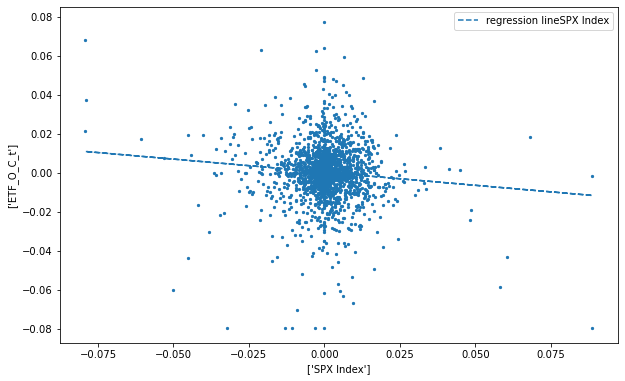

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KBA US Equity,ETF_O_C_t
SPX Index,1.000000,0.148998,-0.096790
KBA US Equity,0.148998,1.000000,0.780617
ETF_O_C_t,-0.096790,0.780617,1.000000


CNYA


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     17.02
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           3.93e-05
Time:                        08:15:40   Log-Likelihood:                 3933.2
No. Observations:                1350   AIC:                            -7862.
Df Residuals:                    1348   BIC:                            -7852.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.847      0.004       0.000       0.002
SPX Index     -0.1304      0.032     -4.125      0.000      -0.192      -0.068
==============================================================================
Omnibus:                      112.970   Durbin-Watson:                   2.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              646.548
Skew:                           0.054   Prob(JB):                    4.02e-141
Kurtosis:                       6.389   Cond. No.                         88.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.001020017050217076   -0.13042044741315112
p-value: 0.004482135822843414   3.9320791817887445e-05


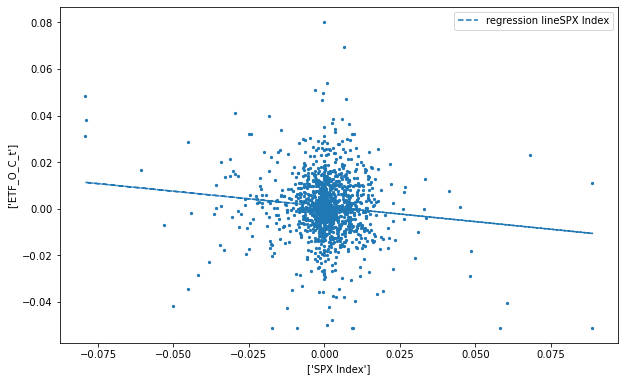

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CNYA US Equity,ETF_O_C_t
SPX Index,1.000000,0.142429,-0.111652
CNYA US Equity,0.142429,1.000000,0.772165
ETF_O_C_t,-0.111652,0.772165,1.000000


KURE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.012
Date:                Thu, 19 Aug 2021   Prob (F-statistic):             0.0830
Time:                        08:15:40   Log-Likelihood:                 2469.4
No. Observations:                 924   AIC:                            -4935.
Df Residuals:                     922   BIC:                            -4925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.497      0.013       0.000       0.002
SPX Index     -0.0724      0.042     -1.735      0.083      -0.154       0.009
==============================================================================
Omnibus:                       28.090   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.278
Skew:                          -0.126   Prob(JB):                     8.14e-14
Kurtosis:                       4.226   Cond. No.                         75.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0013760491549900723   -0.07241598844061996
p-value: 0.01268158615958891   0.08300110522097946


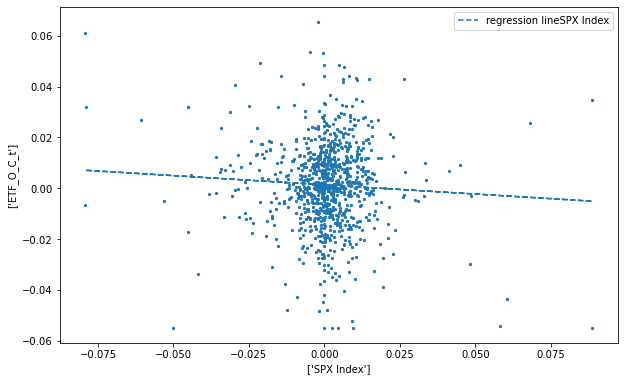

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KURE US Equity,ETF_O_C_t
SPX Index,1.000000,0.139441,-0.057060
KURE US Equity,0.139441,1.000000,0.791377
ETF_O_C_t,-0.057060,0.791377,1.000000


CHAU


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     18.20
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           2.11e-05
Time:                        08:15:40   Log-Likelihood:                 3343.5
No. Observations:                1654   AIC:                            -6683.
Df Residuals:                    1652   BIC:                            -6672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.128      0.898      -0.001       0.002
SPX Index     -0.3042      0.071     -4.266      0.000      -0.444      -0.164
==============================================================================
Omnibus:                      291.300   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4463.219
Skew:                          -0.328   Prob(JB):                         0.00
Kurtosis:                      11.021   Cond. No.                         90.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00010138587734296071   -0.30422987621900005
p-value: 0.8978149353149356   2.105935555570632e-05


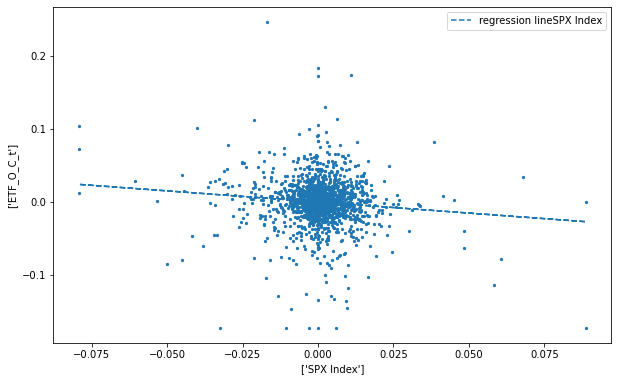

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CHAU US Equity,ETF_O_C_t
SPX Index,1.000000,-0.132784,-0.104377
CHAU US Equity,-0.132784,1.000000,0.908469
ETF_O_C_t,-0.104377,0.908469,1.000000


KGRN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02046
Date:                Thu, 19 Aug 2021   Prob (F-statistic):              0.886
Time:                        08:15:40   Log-Likelihood:                 2664.5
No. Observations:                1003   AIC:                            -5325.
Df Residuals:                    1001   BIC:                            -5315.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      2.848      0.004       0.000       0.003
SPX Index     -0.0060      0.042     -0.143      0.886      -0.089       0.077
==============================================================================
Omnibus:                      112.797   Durbin-Watson:                   1.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.844
Skew:                           0.128   Prob(JB):                    3.24e-192
Kurtosis:                       7.586   Cond. No.                         78.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0015305085202199148   -0.00603715540150139
p-value: 0.004494267668883015   0.8863004332059405


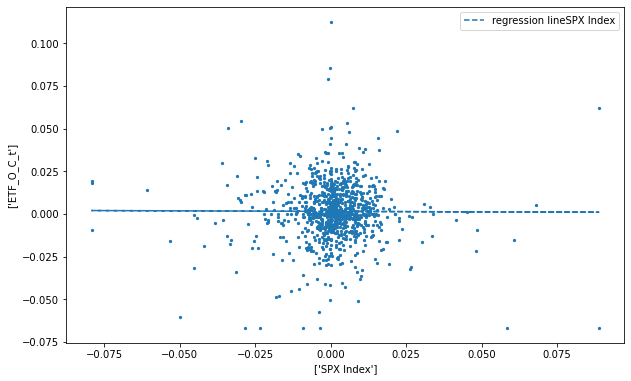

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KGRN US Equity,ETF_O_C_t
SPX Index,1.000000,0.184687,-0.004520
KGRN US Equity,0.184687,1.000000,0.657353
ETF_O_C_t,-0.004520,0.657353,1.000000


PGJ


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     8.014
Date:                Thu, 19 Aug 2021   Prob (F-statistic):            0.00466
Time:                        08:15:40   Log-Likelihood:                 12852.
No. Observations:                4354   AIC:                        -2.570e+04
Df Residuals:                    4352   BIC:                        -2.569e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      4.605      0.000       0.001       0.001
SPX Index     -0.0458      0.016     -2.831      0.005      -0.078      -0.014
==============================================================================
Omnibus:                      610.104   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6075.043
Skew:                          -0.322   Prob(JB):                         0.00
Kurtosis:                       8.751   Cond. No.                         84.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.000882804088314303   -0.04578981995649701
p-value: 4.251575390858783e-06   0.004663864261677471


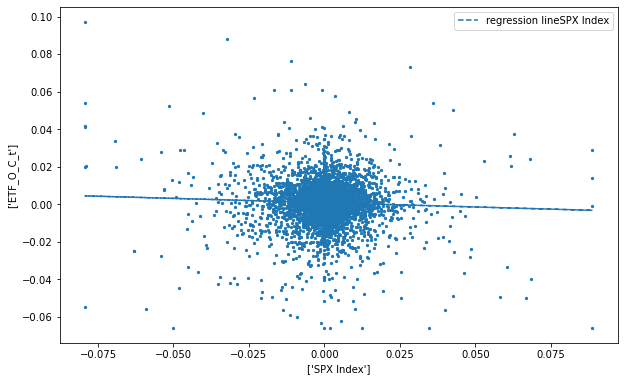

<Figure size 720x444.96 with 0 Axes>

,SPX Index,PGJ US Equity,ETF_O_C_t
SPX Index,1.000000,-0.073227,-0.042872
PGJ US Equity,-0.073227,1.000000,0.628779
ETF_O_C_t,-0.042872,0.628779,1.000000


KSTR


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1721
Date:                Thu, 19 Aug 2021   Prob (F-statistic):              0.679
Time:                        08:15:41   Log-Likelihood:                 443.61
No. Observations:                 145   AIC:                            -883.2
Df Residuals:                     143   BIC:                            -877.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.225      0.222      -0.001       0.003
SPX Index      0.0488      0.118      0.415      0.679      -0.184       0.281
==============================================================================
Omnibus:                       24.551   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.086
Skew:                           0.874   Prob(JB):                     8.85e-09
Kurtosis:                       4.756   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.0011719614842257238   0.048766552621248904
p-value: 0.22249985652983392   0.678898745220569


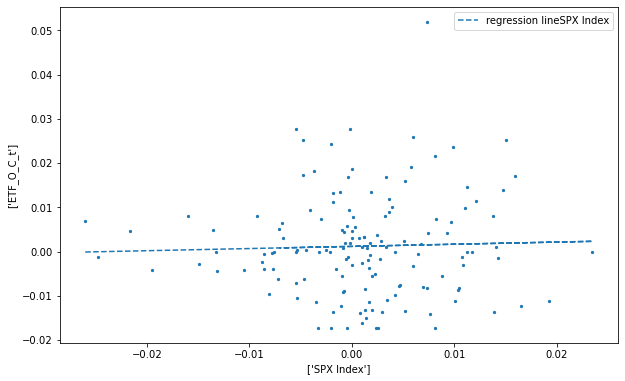

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KSTR US Equity,ETF_O_C_t
SPX Index,1.000000,0.125285,0.034668
KSTR US Equity,0.125285,1.000000,0.753952
ETF_O_C_t,0.034668,0.753952,1.000000


FLCH


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     18.54
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           1.83e-05
Time:                        08:15:41   Log-Likelihood:                 2888.9
No. Observations:                 987   AIC:                            -5774.
Df Residuals:                     985   BIC:                            -5764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.841      0.400      -0.000       0.001
SPX Index     -0.1387      0.032     -4.305      0.000      -0.202      -0.076
==============================================================================
Omnibus:                       65.963   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.841
Skew:                          -0.465   Prob(JB):                     9.48e-27
Kurtosis:                       4.432   Cond. No.                         78.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00034777439763853074   -0.1387357660578656
p-value: 0.4004115589087588   1.8332820299096735e-05


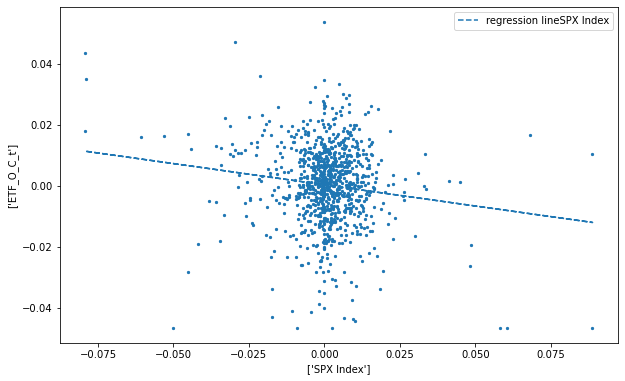

<Figure size 720x444.96 with 0 Axes>

,SPX Index,FLCH US Equity,ETF_O_C_t
SPX Index,1.000000,0.111599,-0.135909
FLCH US Equity,0.111599,1.000000,0.808845
ETF_O_C_t,-0.135909,0.808845,1.000000


KFVG


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.136
Date:                Thu, 19 Aug 2021   Prob (F-statistic):              0.288
Time:                        08:15:41   Log-Likelihood:                 537.43
No. Observations:                 191   AIC:                            -1071.
Df Residuals:                     189   BIC:                            -1064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.893      0.060   -8.45e-05       0.004
SPX Index     -0.1466      0.138     -1.066      0.288      -0.418       0.125
==============================================================================
Omnibus:                        4.091   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.657
Skew:                           0.305   Prob(JB):                        0.161
Kurtosis:                       3.294   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.002020815393011062   -0.14656169839025798
p-value: 0.05982749386325217   0.2878644819292893


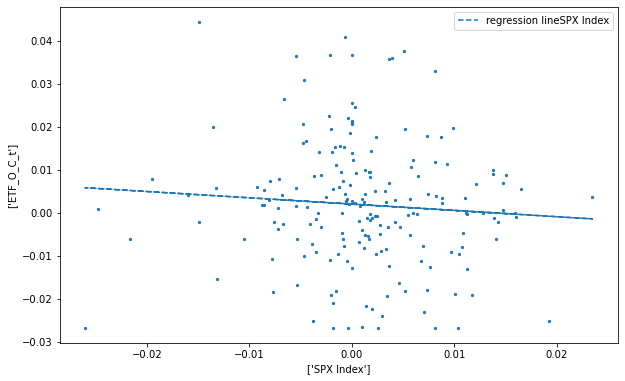

<Figure size 720x444.96 with 0 Axes>

,SPX Index,KFVG US Equity,ETF_O_C_t
SPX Index,1.000000,0.069886,-0.077295
KFVG US Equity,0.069886,1.000000,0.815217
ETF_O_C_t,-0.077295,0.815217,1.000000


CHAD


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     17.18
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           3.57e-05
Time:                        08:15:41   Log-Likelihood:                 4411.4
No. Observations:                1610   AIC:                            -8819.
Df Residuals:                    1608   BIC:                            -8808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.55e-05      0.000      0.194      0.847      -0.001       0.001
SPX Index      0.1447      0.035      4.145      0.000       0.076       0.213
==============================================================================
Omnibus:                      495.613   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7198.252
Skew:                           1.028   Prob(JB):                         0.00
Kurtosis:                      13.153   Cond. No.                         89.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 7.549745773456179e-05   0.1447137053605653
p-value: 0.846538636682524   3.5732727751658025e-05


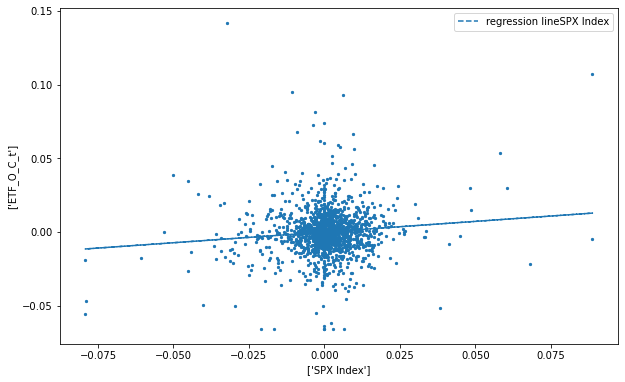

<Figure size 720x444.96 with 0 Axes>

,SPX Index,CHAD US Equity,ETF_O_C_t
SPX Index,1.000000,0.145190,0.102822
CHAD US Equity,0.145190,1.000000,0.902478
ETF_O_C_t,0.102822,0.902478,1.000000


In [4401]:
for target in ETF_list:
    print(target)
    target_name=target+' US Equity'
    SP_C_C_t=np.log(paper_close['SPX Index'].pct_change()+1)
    NAV_C_C_t=np.log(paper_NAV[target_name].pct_change()+1)
    test=pd.merge(SP_C_C_t.shift(1),NAV_C_C_t,left_index=True,right_index=True)
    temp=pd.merge(paper_open[target_name].rename('open'),paper_close[target_name].shift(1).rename('close_t-1'),left_index=True,right_index=True)
    temp['ETF_O_C_t']=np.log(temp['open']/temp['close_t-1'])
    test=pd.merge(test,temp['ETF_O_C_t'],left_index=True,right_index=True)
    #test=test.loc[test.index.year<=2013]
    #test=test.loc[test.index.year>2020]
    test=test.apply(lambda x:pd.Series(winsorize(x,limits=[0.001,0.001])))
    #regression(test,target1=['SPX Index',target_name],target2=['ETF_O_C_t'])
    regression(test,target1=['SPX Index'],target2=['ETF_O_C_t'])
    display(test.corr())
    plt.show()

In [4272]:
test.corr()

,SPX Index,CHAD US Equity,ETF_O_C_t
SPX Index,1.000000,0.145190,0.102822
CHAD US Equity,0.145190,1.000000,0.902478
ETF_O_C_t,0.102822,0.902478,1.000000


In [1219]:
paper_data_dic=pd.read_excel(path_data+'/paper_data_hardcode2.xlsx',sheet_name=['Open','Close','NAV'],index_col=0)
paper_open=paper_data_dic['Open']
paper_close=paper_data_dic['Close']
paper_NAV=paper_data_dic['NAV']

In [1237]:
target_name='HI1 PIT Index'
target_name2='HI1 ELEC Index'
SP_C_C_t=np.log(paper_close['SPX Index'].pct_change()+1)
#temp_SP=pd.merge(paper_close['SPX Index'].rename('SP Close'),paper_open['SPX Index'].rename('SP Open'),left_index=True,right_index=True)
#SP_C_C_t=np.log(temp_SP['SP Close']/temp_SP['SP Open'])
#NAV_C_C_t=np.log(paper_NAV[target_name].pct_change()+1)
test=SP_C_C_t.rename('SPX Index').shift(1)
temp=pd.merge(paper_open[target_name].rename('open'),paper_close[target_name].rename('close'),left_index=True,right_index=True)
temp=pd.merge(temp,paper_close[target_name2].rename('close_t_US'),left_index=True,right_index=True)
temp['ETF_O_C_t']=np.log(temp['open']/temp['close'].shift(1))
temp['ETF_C_O_t']=np.log(temp['close']/temp['open'])
temp['ETF_C_C_t']=np.log(temp['close']/temp['close'].shift(1))
temp['ETF_C_C_US_t']=np.log(temp['close']/temp['close_t_US'])
temp['ETF_O_C_US_t']=np.log(temp['open']/temp['close_t_US'])
test=pd.merge(test,temp[[i for i in temp.columns if (i not in ['open','close_t','close_t_US'])]],left_index=True,right_index=True)
#test=test.loc[test.index.year>2015]
test=test.loc[test.index.year>=2018]
test=test.apply(lambda x:pd.Series(winsorize(x,limits=[0.001,0.001])))
#regression(test,target1=['SPX Index',target_name],target2=['ETF_O_C_t'])
#regression(test,target1=['SPX Index'],target2=['ETF_O_C_t'])
#plt.show()
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

In [1030]:
paper_data=test.copy()

In [1238]:
test.corr(method='pearson')

,SPX Index,close,ETF_O_C_t,ETF_C_O_t,ETF_C_C_t,ETF_C_C_US_t,ETF_O_C_US_t
SPX Index,1.000000,0.032761,0.444710,-0.153474,0.187904,-0.071179,0.122205
close,0.032761,1.000000,0.065895,0.042156,0.078161,0.068474,0.062437
ETF_O_C_t,0.444710,0.065895,1.000000,-0.072357,0.634012,0.267272,0.647956
ETF_C_O_t,-0.153474,0.042156,-0.072357,1.000000,0.725421,0.860468,-0.017822
ETF_C_C_t,0.187904,0.078161,0.634012,0.725421,1.000000,0.851616,0.433345
ETF_C_C_US_t,-0.071179,0.068474,0.267272,0.860468,0.851616,1.000000,0.494089
ETF_O_C_US_t,0.122205,0.062437,0.647956,-0.017822,0.433345,0.494089,1.000000


In [4482]:
test.corr()

,SPX Index,close,ETF_O_C_t,ETF_C_O_t,ETF_C_C_t,ETF_C_C_US_t,ETF_O_C_US_t
SPX Index,1.000000,0.024377,0.511798,-0.110380,0.246349,0.015402,0.220185
close,0.024377,1.000000,0.033650,0.031490,0.046776,0.040531,0.026875
ETF_O_C_t,0.511798,0.033650,1.000000,-0.034264,0.625179,0.279440,0.605870
ETF_C_O_t,-0.110380,0.031490,-0.034264,1.000000,0.756922,0.859475,-0.014508
ETF_C_C_t,0.246349,0.046776,0.625179,0.756922,1.000000,0.854162,0.388189
ETF_C_C_US_t,0.015402,0.040531,0.279440,0.859475,0.854162,1.000000,0.496663
ETF_O_C_US_t,0.220185,0.026875,0.605870,-0.014508,0.388189,0.496663,1.000000


In [4448]:
get_corr('ETF_O_C_t+1').sort_values(('HI','pvalue'))

HI                                HC                \
                     corr        pvalue   Rsquare      corr        pvalue   
index                                                                       
overnight_ret    1.000000  0.000000e+00  1.000000  1.000000  0.000000e+00   
future_C_C2_t+1  0.953258  2.402949e-67  0.908701  0.948348  1.114188e-64   
future_C_O_t+1   0.908545  1.355746e-49  0.825454  0.903366  3.691833e-48   
future_C_C_t+1   0.860302  2.188323e-38  0.740120  0.837341  1.396472e-34   
NAV_C_C_t+1      0.792042  8.782272e-29  0.627330  0.841719  1.575561e-35   
SP_O_C_t+1       0.404604  2.170862e-06  0.163705  0.392813  4.511410e-06   
open_next        0.281660  1.278217e-03  0.079332  0.207763  1.861036e-02   
SP_C_C_t+1       0.245212  5.274598e-03  0.060129  0.234189  7.798722e-03   
future_O_C_t+1   0.206653  1.926325e-02  0.042705  0.210010  1.734643e-02   
ETF_O_C_t-1      0.180925  4.262128e-02  0.032734  0.200030  2.472312e-02   
NAV_C_C_t-1      0.157529  7.812839e-02  0.024815  0.155954  8.119161e-02   
future_C_O_t    -0.151801  8.844082e-02  0.023043 -0.161448  6.977663e-02   
SP_O_C_t-1       0.136652  1.270623e-01  0.018674  0.140598  1.163463e-01   
future_C_O_t-1   0.129809  1.474152e-01  0.016850  0.162654  6.880087e-02   
ETF_O_C_t       -0.125487  1.597981e-01  0.015747 -0.147669  9.756350e-02   
future_C_C2_t   -0.115424  1.962801e-01  0.013323 -0.148127  9.651522e-02   
future_C_C_t-1   0.105625  2.410614e-01  0.011157  0.133995  1.362809e-01   
future_O_C_t     0.104307  2.431939e-01  0.010880  0.031578  7.245095e-01   
future_C_C_t    -0.085814  3.393649e-01  0.007364 -0.116697  1.931517e-01   
SP_C_C_t-1       0.074352  4.079949e-01  0.005528  0.057464  5.227338e-01   
SP_C_O_t        -0.059895  5.018445e-01  0.003587 -0.103699  2.440779e-01   
future_O_C_t-1   0.046312  6.065897e-01  0.002145  0.046090  6.083151e-01   
ETF_C_O_t        0.043951  6.222875e-01  0.001932  0.026295  7.682828e-01   
ret              0.043951  6.222875e-01  0.001932  0.026295  7.682828e-01   
SP_C_C_t        -0.043808  6.248086e-01  0.001919 -0.089590  3.165057e-01   
NAV_C_C_t       -0.040551  6.508001e-01  0.001644 -0.052448  5.581324e-01   
SP_C_O_t+1       0.017281  8.464799e-01  0.000299  0.011328  8.990127e-01   
ETF_C_O_t-1      0.008494  9.244917e-01  0.000072  0.001143  9.898258e-01   
SP_C_O_t-1      -0.008170  9.273611e-01  0.000067 -0.034716  6.983997e-01   
ETF_C_O_t+1      0.005494  9.509204e-01  0.000030  0.080323  3.674317e-01   
SP_O_C_t        -0.003420  9.695631e-01  0.000012 -0.028362  7.515985e-01   

                                HCT                                XU  \
                  Rsquare      corr        pvalue   Rsquare      corr   
index                                                                   
overnight_ret    1.000000  1.000000  0.000000e+00  1.000000  1.000000   
future_C_C2_t+1  0.899364  0.683626  9.583012e-11  0.467345  0.976442   
future_C_O_t+1   0.816071  0.696464  3.032075e-11  0.485061  0.962765   
future_C_C_t+1   0.701140  0.465856  6.242661e-05  0.217022  0.936349   
NAV_C_C_t+1      0.708491  0.853381  1.253072e-20  0.728260  0.892973   
SP_O_C_t+1       0.154302  0.199412  1.004404e-01  0.039765  0.317717   
open_next        0.043165  0.157196  1.970667e-01  0.024711  0.151112   
SP_C_C_t+1       0.054845  0.270861  2.437952e-02  0.073366  0.234722   
future_O_C_t+1   0.044104  0.074590  5.424463e-01  0.005564 -0.042141   
ETF_O_C_t-1      0.040012 -0.125197  3.127481e-01  0.015674  0.015480   
NAV_C_C_t-1      0.024321 -0.186435  1.308921e-01  0.034758  0.099771   
future_C_O_t     0.026066 -0.172234  1.601789e-01  0.029665 -0.071252   
SP_O_C_t-1       0.019768  0.071358  5.660833e-01  0.005092  0.091451   
future_C_O_t-1   0.026456 -0.157120  2.041622e-01  0.024687  0.040273   
ETF_O_C_t        0.021806 -0.072716  5.556611e-01  0.005288 -0.067255   
future_C_C2_t    0.021942 -0.136223  2.680057e-01  0.018557 -0.072064   
future_C_C_t-1   

In [4414]:
get_corr('future_O_C_t+1').sort_values(('HI','pvalue'))

HI                            HC                      \
                     corr    pvalue   Rsquare      corr    pvalue   Rsquare   
index                                                                         
SP_O_C_t+1       0.289239  0.000929  0.083659  0.295135  0.000720  0.087105   
SP_C_O_t         0.229415  0.008916  0.052631  0.041622  0.639541  0.001732   
future_C_C2_t+1  0.228700  0.009416  0.052304  0.225288  0.010564  0.050755   
future_C_C_t+1   0.227098  0.010241  0.051573  0.172141  0.052963  0.029633   
SP_C_C_t         0.225987  0.010319  0.051070  0.059250  0.506466  0.003511   
ETF_O_C_t+1      0.206653  0.019263  0.042705  0.210010  0.017346  0.044104   
overnight_ret    0.206653  0.019263  0.042705  0.210010  0.017346  0.044104   
open_next        0.192969  0.029085  0.037237  0.230781  0.008771  0.053260   
SP_C_O_t-1      -0.178574  0.043721  0.031889 -0.213050  0.015755  0.045390   
NAV_C_C_t+1      0.176698  0.046019  0.031222  0.202332  0.021997  0.040938   
SP_C_C_t+1       0.135255  0.127952  0.018294  0.181555  0.040269  0.032962   
future_O_C_t-1   0.111876  0.210480  0.012516  0.008867  0.921185  0.000079   
SP_O_C_t         0.107353  0.227767  0.011525  0.050327  0.572644  0.002533   
ETF_C_O_t-1     -0.103625  0.244418  0.010738 -0.087435  0.326398  0.007645   
future_C_C_t    -0.099287  0.266746  0.009858 -0.122710  0.169317  0.015058   
future_C_O_t+1  -0.089109  0.317186  0.007940 -0.085850  0.335278  0.007370   
SP_O_C_t-1       0.088047  0.324945  0.007752  0.105692  0.236958  0.011171   
future_O_C_t    -0.076557  0.390388  0.005861 -0.001677  0.985013  0.000003   
SP_C_C_t-1      -0.076146  0.394837  0.005798 -0.090805  0.309963  0.008246   
future_C_C2_t   -0.061188  0.492638  0.003744 -0.098017  0.271022  0.009607   
NAV_C_C_t-1     -0.061419  0.492739  0.003772 -0.046298  0.605247  0.002143   
future_C_O_t-1  -0.052844  0.555161  0.002792 -0.004404  0.960806  0.000019   
SP_C_O_t+1      -0.043929  0.622466  0.001930  0.016382  0.854377  0.000268   
ETF_C_O_t+1     -0.042518  0.633691  0.001808  0.006649  0.940618  0.000044   
future_C_O_t    -0.037868  0.671288  0.001434 -0.099702  0.262832  0.009940   
ETF_O_C_t-1     -0.022747  0.799620  0.000517 -0.004867  0.956695  0.000024   
ETF_O_C_t       -0.022506  0.800918  0.000507 -0.060725  0.495927  0.003688   
ETF_C_O_t       -0.018866  0.831943  0.000356 -0.125493  0.156465  0.015748   
ret             -0.018866  0.831943  0.000356 -0.125493  0.156465  0.015748   
NAV_C_C_t       -0.011131  0.900764  0.000124 -0.065641  0.461640  0.004309   
future_C_C_t-1   0.007361  0.934800  0.000054  0.038434  0.669180  0.001477   

                      HCT                            XU                      
                     corr    pvalue   Rsquare      corr    pvalue   Rsquare  
index                                                                        
SP_O_C_t+1       0.108746  0.373761  0.011826  0.195060  0.023382  0.038048  
SP_C_O_t         0.184077  0.127151  0.033884  0.243093  0.004349  0.059094  
future_C_C2_t+1  0.322903  0.006807  0.104266 -0.078119  0.367802  0.006103  
future_C_C_t+1   0.174571  0.154498  0.030475 -0.087230  0.316240  0.007609  
SP_C_C_t         0.103320  0.398210  0.010675  0.169897  0.048837  0.028865  
ETF_O_C_t+1      0.074590  0.542446  0.005564 -0.042141  0.627467  0.001776  
overnight_ret    0.074590  0.542446  0.005564 -0.042141  0.627467  0.001776  
open_next        0.103609  0.396883  0.010735  0.085353  0.324974  0.007285  
SP_C_O_t-1      -0.276364  0.021523  0.076377 -0.144142  0.095330  0.020777  
NAV_C_C_t+1      0.013299  0.913632  0.000177 -0.046219  0.594511  0.002136  
SP_C_C_t+1       0.045347  0.711392  0.002056  0.057917  0.504622  0.003354  
future_O_C_t-1   0.039734  0.747671  0.001579  0.079242  0.362753  0.006279  
SP_O_C_t         0.021855  0.858529  0.000478 -0.015278  0.860393  0.000233  
ETF_C_O_t-1     -0.066038  0.589805  0.004361 -0.107457  0.214781  0.011547  
future_C_C

In [4398]:
temp_future=temp.copy()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ETF_O_C_t   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     123.4
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           2.69e-28
Time:                        10:12:55   Log-Likelihood:                 12238.
No. Observations:                4398   AIC:                        -2.447e+04
Df Residuals:                    4396   BIC:                        -2.446e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.875      0.381      -0.000       0.001
SPX Index     -0.2125      0.019    -11.109      0.000      -0.250      -0.175
==============================================================================
Omnibus:                      614.291   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6894.679
Skew:                          -0.256   Prob(JB):                         0.00
Kurtosis:                       9.112   Cond. No.                         84.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00019774018231069558   -0.2124508438849035
p-value: 0.3814729562140202   2.687776066078513e-28


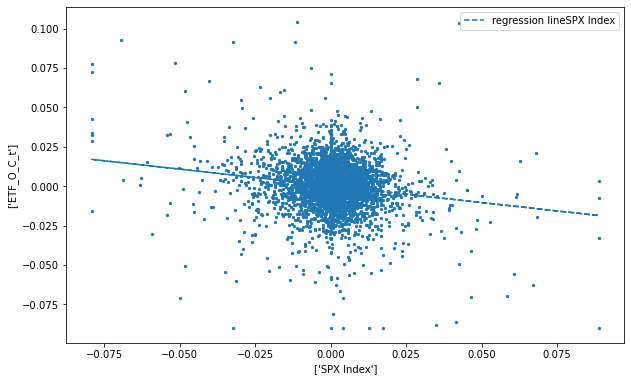

<Figure size 720x444.96 with 0 Axes>

,SPX Index,FXI US Equity,ETF_O_C_t
SPX Index,1.000000,0.358113,-0.165249
FXI US Equity,0.358113,1.000000,0.662920
ETF_O_C_t,-0.165249,0.662920,1.000000


In [4531]:
#ETF
target_name='FXI'+' US Equity'
SP_C_C_t=np.log(paper_close['SPX Index'].pct_change()+1)
NAV_C_C_t=np.log(paper_NAV[target_name].pct_change()+1)
test=pd.merge(SP_C_C_t.shift(1),NAV_C_C_t,left_index=True,right_index=True)
temp=pd.merge(paper_open[target_name].rename('open'),paper_close[target_name].shift(1).rename('close_t-1'),left_index=True,right_index=True)
temp['ETF_O_C_t']=np.log(temp['open']/temp['close_t-1'])
test=pd.merge(test,temp['ETF_O_C_t'],left_index=True,right_index=True)
#test=test.loc[test.index.year<=2013]
#test=test.loc[test.index.year>2020]
test=test.apply(lambda x:pd.Series(winsorize(x,limits=[0.001,0.001])))
#regression(test,target1=['SPX Index',target_name],target2=['ETF_O_C_t'])
regression(test,target1=['SPX Index'],target2=['ETF_O_C_t'])
display(test.corr())
plt.show()

In [4406]:
temp_future.columns=pd.Series(temp_future.columns).apply(lambda x:x+'_future')

In [4409]:
pd.merge(temp_future,temp,left_index=True,right_index=True).corr()['ETF_O_C_t']

open_future           -0.031944
close_future          -0.006362
close_t_US_future     -0.019351
ETF_O_C_t_future       0.061925
ETF_C_O_t_future       0.496365
ETF_C_C_t_future       0.416915
ETF_C_C_US_t_future    0.365593
ETF_O_C_US_t_future    0.040697
open                   0.024753
close_t-1             -0.032782
ETF_O_C_t              1.000000
Name: ETF_O_C_t, dtype: float64

In [1038]:
target_name='HI1 PIT Index'
target_name2='HI1 ELEC Index'
SP_C_C_t=np.log(paper_close['SPX Index'].pct_change()+1)
#temp_SP=pd.merge(paper_close['SPX Index'].rename('SP Close'),paper_open['SPX Index'].rename('SP Open'),left_index=True,right_index=True)
#SP_C_C_t=np.log(temp_SP['SP Close']/temp_SP['SP Open'])
#NAV_C_C_t=np.log(paper_NAV[target_name].pct_change()+1)
test=SP_C_C_t.rename('SPX Index').shift(1)
temp=pd.merge(paper_open[target_name].rename('open'),paper_close[target_name].rename('close'),left_index=True,right_index=True)
temp=pd.merge(temp,paper_close[target_name2].rename('close_t_US'),left_index=True,right_index=True)
temp['ETF_O_C_t']=np.log(temp['open']/temp['close'].shift(1))
temp['ETF_C_O_t']=np.log(temp['close']/temp['open'])
temp['ETF_C_C_t']=np.log(temp['close']/temp['close'].shift(1))
temp['ETF_C_C_US_t']=np.log(temp['close']/temp['close_t_US'])
temp['ETF_O_C_US_t']=np.log(temp['open']/temp['close_t_US'])
test=pd.merge(test,temp[[i for i in temp.columns if (i not in ['open','close_t','close_t_US'])]],left_index=True,right_index=True)
test=test.loc[test.index.year>=2013]
#test=test.loc[test.index.year>=2018]
#test=test.apply(lambda x:pd.Series(winsorize(x,limits=[0.001,0.001])))
#regression(test,target1=['SPX Index',target_name],target2=['ETF_O_C_t'])
#regression(test,target1=['SPX Index'],target2=['ETF_O_C_t'])
#plt.show()

In [1039]:
paper_data=test.copy()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ETF_O_C_US_t   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     114.6
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           3.97e-26
Time:                        10:15:23   Log-Likelihood:                 8608.9
No. Observations:                2252   AIC:                        -1.721e+04
Df Residuals:                    2250   BIC:                        -1.720e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.927      0.354      -0.000       0.000
SPX Index      0.1192      0.011     10.707      0.000       0.097       0.141
==============================================================================
Omnibus:                      564.839   Durbin-Watson:                   2.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12786.408
Skew:                          -0.630   Prob(JB):                         0.00
Kurtosis:                      14.605   Cond. No.                         99.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00010350925985077013   0.11921455597601192
p-value: 0.35419311865495773   3.9697501036970964e-26


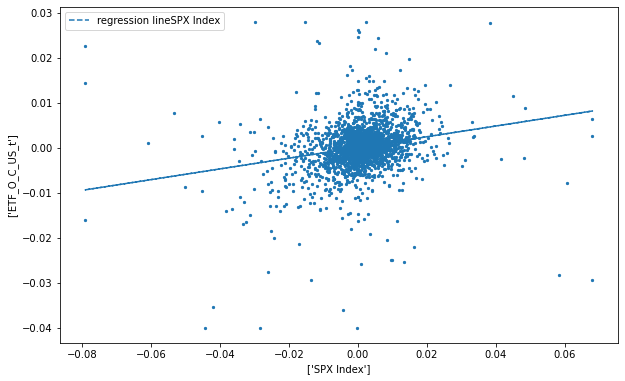

<Figure size 720x444.96 with 0 Axes>

In [4539]:
regression(test,target1=['SPX Index'],target2=['ETF_O_C_US_t'])

In [3647]:
from scipy.stats.mstats import winsorize

In [1213]:
target_future='HI'
target_ETF='FXI'
df_ETF=get_price_ETF(target_ETF)
df_future=get_price_future(target_future)
SP=get_price_future('ES')
SP.index=SP.index.tz_convert('US/Eastern')
df_ETF.index=df_ETF.index.tz_convert('US/Eastern')
df_ETF=pd.merge(df_ETF,SP['close'].rename('SP_close'),left_index=True,right_index=True)
df_future=pd.merge(df_future,SP['close'].rename('SP_close'),left_index=True,right_index=True)
temp=df_ETF.groupby(df_ETF.index.date)[['SP_close']].apply(lambda x:pd.Series(np.log(x.tail(2).head(1).values/x.head(1).values)[0]))
temp=temp.rename(columns={0:'SP_intraday'})

temp=df_ETF.groupby(df_ETF.index.date)[['SP_close']].apply(lambda x:pd.Series(np.log(x.tail(2).head(1).values/x.head(1).values)[0]))
temp=temp.rename(columns={0:'SP_intraday'})
temp['SP_intraday']=temp['SP_intraday'].shift(1)
df_ETF['prev_close']=df_ETF['close'].shift(1)
temp=pd.merge(df_ETF.groupby(df_ETF.index.date).apply(lambda x:np.log(x.head(1)['close'].iloc[0]/x.head(1)['prev_close'].iloc[0])).rename('overnight'),temp,left_index=True,right_index=True)

future_open=df_future.groupby(df_future.index.date).apply(lambda x:x.loc[(x.index.hour==9)&(x.index.minute==30)]).droplevel(1)['close']
df_future.index=df_future.index.tz_convert('US/Eastern')
future_close=df_future.groupby(df_future.index.date).apply(lambda x:x.loc[(x.index.hour<=16)].tail(1)).droplevel(1)['close']
temp_future=pd.merge(future_open.rename('open'),future_close.shift(1),left_index=True,right_index=True)
temp_future['overnight']=np.log(temp_future['open']/temp_future['close'])
temp=pd.merge(temp,temp_future['overnight'].rename('overnight_future'),left_index=True,right_index=True)
temp=pd.merge(temp,np.log(NAV[target_ETF].pct_change()+1),left_index=True,right_index=True)
temp.rename(columns={target_ETF:'NAV'},inplace=True)
future_overnight=main(target_future)
temp=pd.merge(temp,future_overnight[['close','open_nextday_lag0']],left_index=True,right_index=True)
temp['overnight_predict']=np.log(temp['open_nextday_lag0']/temp['close']).shift(1)

In [1010]:
future_overnight=main('HI')

In [932]:
temp.corr(method=pearsonr_pval)[['overnight','overnight_predict','overnight_future','NAV']]

,overnight,overnight_predict,overnight_future,NAV
overnight,1.000000e+00,0.685691,2.736775e-41,4.274217e-39
SP_intraday,5.019748e-01,0.000002,7.589312e-01,1.600395e-01
overnight_future,2.736775e-41,0.204609,1.000000e+00,1.280812e-28
NAV,4.274217e-39,0.079659,1.280812e-28,1.000000e+00
close,9.492693e-03,0.018829,1.089733e-03,3.411755e-02
open_nextday_lag0,7.555236e-03,0.029446,9.584637e-04,3.007566e-02
overnight_predict,6.856911e-01,1.000000,2.046091e-01,7.965862e-02


In [4545]:
temp.corr()[['overnight','overnight_predict','overnight_future','NAV']]

,overnight,overnight_predict,overnight_future,NAV
overnight,1.000000,-0.117554,0.540253,0.864179
SP_intraday,-0.060116,0.138296,0.192457,0.125415
overnight_future,0.540253,-0.270890,1.000000,0.546678
NAV,0.864179,-0.036633,0.546678,1.000000
close,0.229352,0.058324,0.342734,0.187442
open_nextday_lag0,0.097083,-0.038953,-0.039984,0.071309
overnight_predict,-0.117554,1.000000,-0.270890,-0.036633


In [ ]:
df_future.groupby(df_future.index.date).apply(lambda x:x.loc[(x.index.hour==9)&(x.index.minute==30)]).droplevel(1)['close']

In [4145]:
np.log(df_ETF['close'].pct_change()+1)

Dates
2021-01-25 09:30:00-05:00         NaN
2021-01-25 09:31:00-05:00   -0.000745
2021-01-25 09:32:00-05:00   -0.000107
2021-01-25 09:33:00-05:00    0.000000
2021-01-25 09:34:00-05:00    0.001597
                               ...   
2021-08-06 15:56:00-04:00   -0.000071
2021-08-06 15:57:00-04:00    0.000354
2021-08-06 15:58:00-04:00    0.000778
2021-08-06 15:59:00-04:00   -0.000566
2021-08-06 16:29:00-04:00    0.000000
Name: close, Length: 53118, dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              overnight   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     214.4
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           5.72e-41
Time:                        09:39:57   Log-Likelihood:                 454.74
No. Observations:                 127   AIC:                            -903.5
Df Residuals:                     124   BIC:                            -894.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0009      0.001     -1.523      0.130      -0.002       0.000
SP_intraday    -0.3978      0.100     -3.993      0.000      -0.595      -0.201
NAV             0.7243      0.035     20.657      0.000       0.655       0.794
==============================================================================
Omnibus:                       10.414   Durbin-Watson:                   2.458
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.957
Skew:                          -0.529   Prob(JB):                      0.00253
Kurtosis:                       4.068   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.000937253077207955   -0.39781700245409646
p-value: 0.13025561187205886   0.00011107697872404161


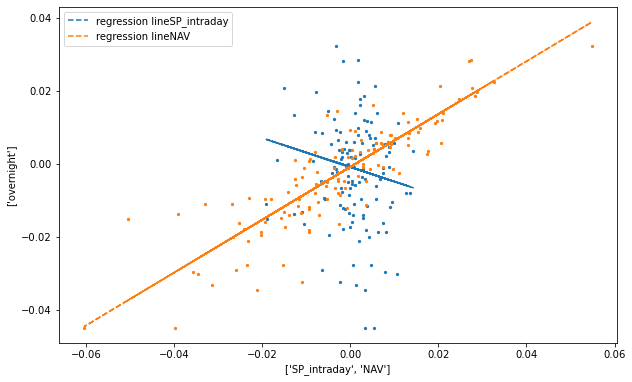

<Figure size 720x444.96 with 0 Axes>

In [934]:
regression(temp,target1=['SP_intraday','NAV'],target2=['overnight'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              overnight   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.4534
Date:                Mon, 23 Aug 2021   Prob (F-statistic):              0.502
Time:                        13:05:55   Log-Likelihood:                 360.06
No. Observations:                 127   AIC:                            -716.1
Df Residuals:                     125   BIC:                            -710.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0029      0.001     -2.233      0.027      -0.005      -0.000
SP_intraday    -0.1397      0.207     -0.673      0.502      -0.550       0.271
==============================================================================
Omnibus:                        4.187   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.610
Skew:                          -0.368   Prob(JB):                        0.165
Kurtosis:                       3.376   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.002851436762158909   -0.1397001188885905
p-value: 0.027311053931929265   0.5019747799475616


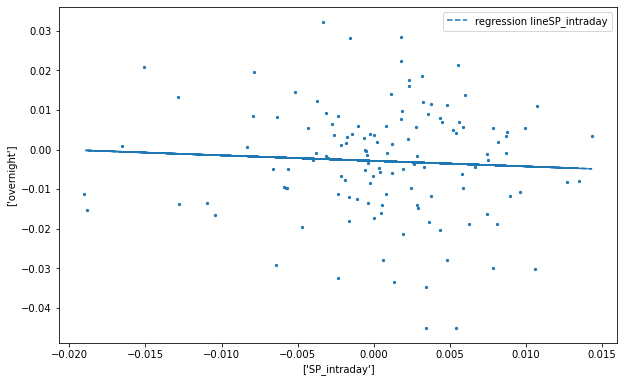

<Figure size 720x444.96 with 0 Axes>

In [1214]:
regression(temp,target1=['SP_intraday'],target2=['overnight'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              overnight   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     214.4
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           5.72e-41
Time:                        13:11:19   Log-Likelihood:                 454.74
No. Observations:                 127   AIC:                            -903.5
Df Residuals:                     124   BIC:                            -894.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0009      0.001     -1.523      0.130      -0.002       0.000
NAV             0.7243      0.035     20.657      0.000       0.655       0.794
SP_intraday    -0.3978      0.100     -3.993      0.000      -0.595      -0.201
==============================================================================
Omnibus:                       10.414   Durbin-Watson:                   2.458
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.957
Skew:                          -0.529   Prob(JB):                      0.00253
Kurtosis:                       4.068   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -0.0009372530772079533   0.7243463100158993
p-value: 0.13025561187205947   5.8035604775072e-42


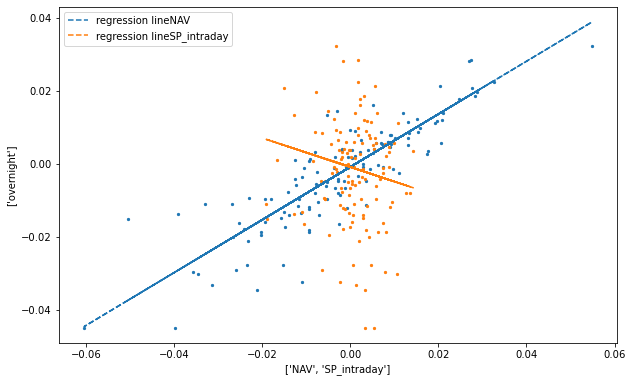

<Figure size 720x444.96 with 0 Axes>

In [1215]:
regression(temp,target1=['NAV','SP_intraday'],target2=['overnight'])

In [312]:
a=main('HI')

In [80]:
import arch

In [81]:
from arch.univariate import GARCH

In [340]:
garch=GARCH(p=1,q=1)

In [82]:
from arch import arch_model

In [327]:
model=arch_model(future_overnight['SP_C_C_t'].dropna(),vol='Garch',p=1,o=0,dist='normal')
results=model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 64902259.49328985
Iteration:      2,   Func. Count:     17,   Neg. LLF: -434.0372540871008
Optimization terminated successfully    (Exit mode 0)
            Current function value: -434.03725427337014
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


In [344]:
len(future_overnight['SP_C_C_t'])

129

In [434]:
future_overnight['SP_resid']=future_overnight['SP_C_C_t']-res.resid

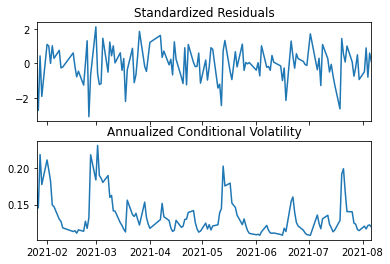

In [420]:
fig = res.plot(annualize="D")

In [ ]:
np.plyfit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ETF_O_C_t+1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 20 Aug 2021   Prob (F-statistic):                nan
Time:                        16:10:36   Log-Likelihood:                 383.67
No. Observations:                 127   AIC:                            -765.3
Df Residuals:                     126   BIC:                            -762.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.296      0.197      -0.003       0.001
SP_resid   -1.751e-06   1.35e-06     -1.296      0.197   -4.42e-06    9.23e-07
==============================================================================
Omnibus:                        3.985   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.488
Skew:                          -0.391   Prob(JB):                        0.175
Kurtosis:                       3.220   Cond. No.                     3.72e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.17e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

params: -0.0013615088105642039   -1.7507427701106553e-06
p-value: 0.1974852083325691   0.1974852083325684


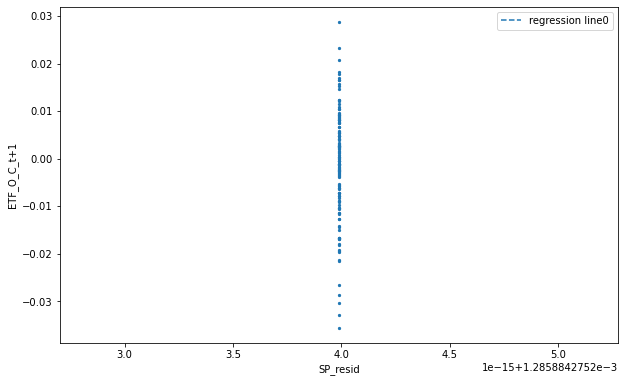

<Figure size 720x444.96 with 0 Axes>

In [436]:
regression(future_overnight[['SP_resid','ETF_O_C_t+1']].dropna())

In [79]:
from arch.univariate import ConstantMean, GARCH

In [358]:
from arch.univariate import ConstantMean, GARCH
cm=ConstantMean()
cm.volatility=GARCH()
cm_params=np.array([1])
garch_params=np.array([0.01,0.07,0.92])
params=np.concatenate((cm_params,garch_params))

In [370]:
model.distribution.cdf()

array([0.84134475, 0.97724987, 0.9986501 ])

In [337]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               SP_C_C_t   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                434.037
Distribution:                  Normal   AIC:                          -860.075
Method:            Maximum Likelihood   BIC:                          -848.666
                                        No. Observations:                  128
Date:                Fri, Aug 20 2021   Df Residuals:                      127
Time:                        15:06:26   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2859e-03  6.067e-04      2.120  3.404e-02 [9.

In [78]:
from arch import arch_model
import datetime as dt
import pandas_datareader.data as web
start = dt.datetime(2000,1,1)
end = dt.datetime(2014,1,1)
sp500 = web.get_data_yahoo('^GSPC', start=start, end=end)
returns = 100 * sp500['Adj Close'].pct_change().dropna()
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [459]:
split_date = dt.datetime(2010,1,1)
res = am.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5487345657.107608
Iteration:      2,   Func. Count:     15,   Neg. LLF: 709955645.7953504
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3828.8870037974266
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3805.241601555089
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3812.7772868869197
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3851.3639864960223
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3789.088711360313
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3816.9156796325733
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3787.106992448501
Iteration:     10,   Func. Count:     64,   Neg. LLF: 3786.3208158583907
Iteration:     11,   Func. Count:     70,   Neg. LLF: 3786.2968327176636
Iteration:     12,   Func. Count:     75,   Neg. LLF: 3786.296788038492
Iteration:     13,   Func. Count:     79,   Neg. LLF: 3786.296788038242
Optimization terminated successfully    (Exit mode 0)
    

<AxesSubplot:xlabel='Date'>

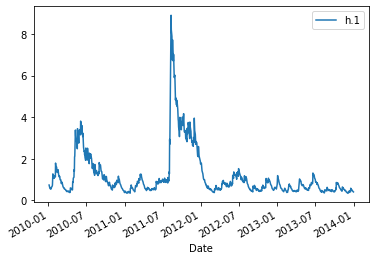

In [462]:
forecasts = res.forecast(horizon=1, start=split_date)
forecasts.variance[split_date:].plot()

In [469]:
returns=future_overnight['SP_C_C_t'].dropna()

In [543]:
from arch.univariate import ARX
ar = ARX(returns, lags=[1])
print(ar.fit().summary())
ar.volatility=GARCH(p=1,q=1,o=0)
res=ar.fit(update_freq=1,disp='off')
print(res.summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:               SP_C_C_t   R-squared:                       0.013
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:          Constant Variance   Log-Likelihood:                423.583
Distribution:                  Normal   AIC:                          -841.167
Method:            Maximum Likelihood   BIC:                          -832.634
                                        No. Observations:                  127
Date:                Fri, Aug 20 2021   Df Residuals:                      125
Time:                        18:39:21   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const       1.2917e-03  8.012e-04      1.612      0.

In [550]:
temp

,h.1,h.2,h.3


Empty DataFrame
Columns: [h.1]
Index: []


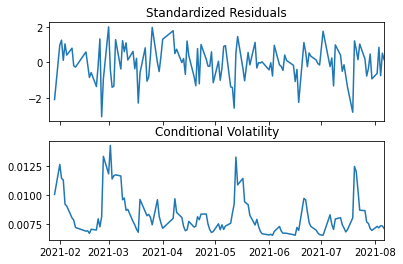

In [555]:
forecasts = res.forecast(horizon=1, reindex=False)
print(forecasts.variance.dropna().head())
fig=res.plot()

In [90]:
def add_sentiment(target):
    future_overnight=main(target)
    returns=future_overnight['SP_C_C_t'].dropna()
    am = arch_model(returns, lags=[1],mean='ARX',vol="Garch", p=1, o=0, q=1, dist="Normal")
    res = am.fit(update_freq=0,disp=False)
    split_date = returns.index[20]
    res = am.fit(last_obs=split_date,disp=False)
    forecasts=res.forecast(horizon=1,start=split_date)
    check=pd.merge(returns,forecasts.mean.shift(1),left_index=True,right_index=True).dropna()
    check=check.iloc[:,0]-check.iloc[:,1]
    check=pd.merge(check.rename('resid'),forecasts.residual_variance.shift(1),left_index=True,right_index=True).rename(columns={'h.1':'std'})
    check['std']=check['std'].apply(lambda x:x**0.5)
    check['signal']=abs(check['resid'])-check['std']*0.85
    check['signal2']=abs(check['resid'])-check['std']*0.15
    check=check.loc[(check['signal']>0)+(check['signal2']<0)]
    check['signal']=check['signal'].apply(lambda x:1 if x>0 else 0)
    check['signal2']=check['signal2'].apply(lambda x:-1 if x<0 else 0)
    check['signal']=check['signal']+check['signal2']
    check.drop(columns={'signal2'},inplace=True)
    future_overnight=pd.merge(future_overnight,check['signal'].rename('market sentiment'),left_index=True,right_index=True,how='outer')
    future_overnight['market sentiment']=future_overnight['market sentiment'].replace(np.nan,0)
    future_overnight['market_sentiment_with direction']=future_overnight['SP_C_O_t'].apply(lambda x:np.sign(x))*future_overnight['market sentiment']
    return future_overnight

,SP_close,close,open,SP_open,predict_close,ret,ret_real,overnight_ret,overnight_ret_real,open_nextday_lag0,...,ETF_C_O_t,ETF_C_O_t+1,ETF_C_O_t-1,ETF_C_C_t,ETF_C_C_t+1,ETF_C_C_t-1,ETF_O_C2_t,ETF_O_C2_t+1,market sentiment,market_sentiment_with direction
2021-01-25,3856.584992,29893.488679,30015.470270,3851.826868,29977.965781,-0.001250,-0.004072,NaN,NaN,29908.486416,...,-0.001250,0.000746,NaN,NaN,-0.012500,NaN,NaN,NaN,0.0,0.0
2021-01-26,3848.070454,29610.502523,29583.511180,3867.854234,29605.574355,0.000746,0.000912,0.013750,0.013584,29584.510860,...,0.000746,-0.003285,-0.001250,-0.012500,-0.022550,NaN,0.005048,NaN,0.0,-0.0
2021-01-27,3757.415664,29127.657394,29040.685290,3802.743059,28945.448227,-0.003285,0.002990,0.021804,0.015529,28887.734349,...,-0.003285,0.009591,0.000746,-0.022550,0.000762,-0.012500,-0.008023,0.005048,0.0,-0.0
2021-01-28,3785.463555,28980.388051,28691.024723,3775.696879,28967.520810,0.009591,0.010035,0.002523,0.002078,28889.273646,...,0.009591,-0.003667,-0.003285,0.000762,-0.021669,-0.022550,0.005248,-0.008023,0.0,0.0
2021-01-29,3709.583993,28223.437616,28450.722998,3764.427637,28346.583345,-0.003667,-0.008021,0.012078,0.016432,28275.502990,...,-0.003667,0.002827,0.009591,-0.021669,0.019848,0.000762,0.003843,0.005248,0.0,-0.0
2021-02-01,3769.937044,28838.209530,28833.203244,3752.657540,28914.819518,0.002827,0.000174,-0.016181,-0.013528,29022.440852,...,0.002827,0.002680,-0.003667,0.019848,0.011008,-0.021669,0.019355,0.003843,0.0,0.0
2021-02-02,3823.278122,29179.638231,29156.609316,3806.749901,29234.860661,0.002680,0.000790,-0.013834,-0.011944,29256.735034,...,0.002680,-0.002342,0.002827,0.011008,-0.005263,0.019848,-0.003873,0.019355,0.0,0.0
2021-02-03,3828.286674,29169.625659,29149.600515,3832.543943,29081.401862,-0.002342,0.000687,0.002583,-0.000446,29086.521312,...,-0.002342,0.001333,0.002680,-0.005263,0.001475,0.011008,-0.003737,-0.003873,0.0,-0.0
2021-02-04,3870.859365,29109.550228,29085.520055,3839.055061,29124.321662,0.001333,0.000826,0.000868,0.001375,29101.540170,...,0.001333,0.002964,-0.002342,0.001475,0.011531,-0.005263,-0.001273,-0.003737,0.0,0.0
2021-02-05,3886.636304,29391.904755,29374.883383,3891.644856,29462.090206,0.002964,0.000579,-0.012864,-0.010479,29516.060646,...,0.002964,-0.000078,0.001333,0.011531,-0.006217,0.001475,0.002252,-0.001273,0.0,-0.0


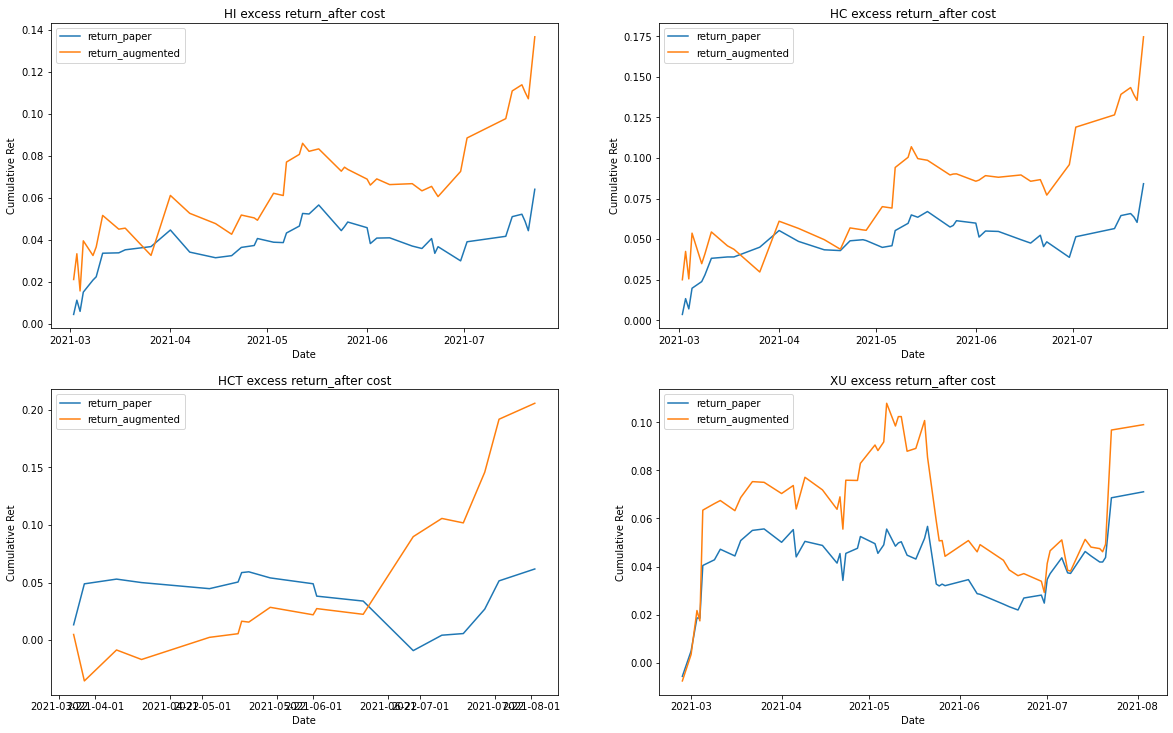

,Sharpe_Aug,Sharpe,Annualized Ret_Aug,Annualized Ret
HI,1.627196,0.763295,0.273294,0.128198
HC,1.692468,0.815282,0.348974,0.168105
HCT,2.145877,0.644173,0.823133,0.247097
XU,0.964199,0.692183,0.186717,0.134041


In [1316]:
figure,axis=plt.subplots(2,2,figsize=(20,20*0.618))
result=pd.DataFrame()
count1,count2=0,0
for target in future_list[:4]:
    future_overnight=main(target)
    returns=future_overnight['SP_C_C_t'].dropna()
    am = arch_model(returns, lags=[1],mean='ARX',vol="Garch", p=1, o=0, q=1, dist="Normal")
    res = am.fit(update_freq=0,disp=False)
    split_date = returns.index[20]
    res = am.fit(last_obs=split_date,disp=False)
    forecasts=res.forecast(horizon=1,start=split_date)
    check=pd.merge(returns,forecasts.mean.shift(1),left_index=True,right_index=True).dropna()
    check=check.iloc[:,0]-check.iloc[:,1]
    check=pd.merge(check.rename('resid'),forecasts.residual_variance.shift(1),left_index=True,right_index=True).rename(columns={'h.1':'std'})
    check['std']=check['std'].apply(lambda x:x**0.5)
    check['signal']=abs(check['resid'])-check['std']*0.85
    check['signal2']=abs(check['resid'])-check['std']*0.15
    check=check.loc[(check['signal']>0)+(check['signal2']<0)]
    check['signal']=check['signal'].apply(lambda x:1 if x>0 else 0)
    check['signal2']=check['signal2'].apply(lambda x:-1 if x<0 else 0)
    check['signal']=check['signal']+check['signal2']
    check.drop(columns={'signal2'},inplace=True)

    sub=pd.merge(future_overnight,check['signal'],left_index=True,right_index=True)
    sub['return']=sub['ETF_C_C_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)
    sub['return_augmented']=sub['future_C_O_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)+sub['future_O_C_t+1']*sub['signal'].apply(lambda x:1.5 if x==1 else 0.5 if x==-1 else 1)
    #sub['return']=sub['future_O_C_t+1']*sub['signal'].apply(lambda x:1.5 if x==1 else 0.5 if x==-1 else 1)
    #sub['return']=sub['future_C_O_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)
    sub['return']=sub['return']-sub['ETF_C_C_t+1']
    sub['return_augmented']=sub['return_augmented']-sub['ETF_C_C_t+1']
    sub['return']-=abs(sub['signal']-sub['signal'].shift(1))*0.0004
    sub['return_augmented']-=abs(sub['signal']-sub['signal'].shift(1))*0.0004
    axis[count1,count2].plot(sub['return'].cumsum().index,sub['return'].cumsum(),label='return_paper')
    axis[count1,count2].plot(sub['return_augmented'].cumsum().index,sub['return_augmented'].cumsum(),label='return_augmented')
    axis[count1,count2].set_title(target+' excess return_after cost')
    axis[count1,count2].set_xlabel('Date')
    axis[count1,count2].set_ylabel('Cumulative Ret')
    axis[count1,count2].legend()
    result=pd.concat([result,pd.DataFrame([sub['return_augmented'].mean()*(len(sub)/len(future_overnight))*(252**0.5)/sub['return_augmented'].std(),sub['return'].mean()*(len(sub)/len(future_overnight))*(252**0.5)/sub['return_augmented'].std(),sub['return_augmented'].mean()*252*(len(sub)/len(future_overnight)),sub['return'].mean()*252*(len(sub)/(len(future_overnight)))],columns=[target],index=['Sharpe_Aug','Sharpe','Annualized Ret_Aug','Annualized Ret'])],axis=1)
    #result=pd.concat([result,pd.DataFrame([],columns=[target1],index=['Annualized Ret_Aug','Annualized Ret'])],axis=0)
    count2+=1
    if count2>1:
        count1+=1
        count2=0
plt.show()
result=result.T
display(result)

136

In [1244]:
pd.DataFrame(get_corr('SP_C_O_t').loc['future_O_C_t+1']).T

HI                  HC                 HCT            \
                    corr    pvalue      corr    pvalue      corr    pvalue   
future_O_C_t+1  0.229415  0.008916  0.041622  0.639541  0.184077  0.127151   

                      XU                 IFB            
                    corr    pvalue      corr    pvalue  
future_O_C_t+1  0.153809  0.073808 -0.045764  0.609423

In [1344]:
get_corr('ETF_O_C_t+1').loc[[i for i in get_corr('ETF_C_O_t+1').index if i.find('t+1')==-1]].sort_values(('HI','pvalue')).iloc[2:].iloc[:1].iloc[:,:4]

HI                 HC          
                 corr    pvalue     corr    pvalue
index                                             
ETF_O_C_t-1  0.180925  0.042621  0.20003  0.024723

In [1153]:
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

In [1154]:
display(pd.merge(future_overnight['ETF_C_C_t+1'],check,left_index=True,right_index=True).corr(method='spearman'))
display(pd.merge(future_overnight['ETF_C_C_t+1'],check,left_index=True,right_index=True).corr(method=spearmanr_pval))

,ETF_C_C_t+1,resid,std,signal
ETF_C_C_t+1,1.000000,-0.110804,0.251120,-0.296691
resid,-0.110804,1.000000,0.209354,0.314564
std,0.251120,0.209354,1.000000,0.171580
signal,-0.296691,0.314564,0.171580,1.000000


,ETF_C_C_t+1,resid,std,signal
ETF_C_C_t+1,1.000000,0.468689,0.096124,0.047808
resid,0.468689,1.000000,0.167518,0.035332
std,0.096124,0.167518,1.000000,0.259747
signal,0.047808,0.035332,0.259747,1.000000


<AxesSubplot:>

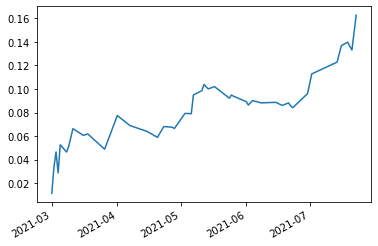

In [1094]:
display(sub.corr(method='spearman')['signal'].loc['ETF_O_C_t+1'])
display(sub.corr(method='spearman')['signal'].loc['future_C_O_t+1'])
display(sub.corr(method='spearman')['signal'].loc['future_O_C_t+1'])
display(sub.corr(method='spearman')['signal'].loc['ETF_O_C2_t+1'])

-0.3074148409257849

-0.13583446459511425

-0.12511069107444733

-0.27524352036378413

In [1046]:
paper_data_original=paper_data.copy()

In [1041]:
returns=paper_data['SPX Index'].shift(1).dropna()
am = arch_model(returns, lags=[1],mean='ARX',vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=0,disp=False)
split_date = returns.index[20]
res = am.fit(last_obs=split_date,disp=False)
forecasts=res.forecast(horizon=1,start=split_date)
check=pd.merge(returns,forecasts.mean.shift(1),left_index=True,right_index=True).dropna()
check=check.iloc[:,0]-check.iloc[:,1]
check=pd.merge(check.rename('resid'),forecasts.residual_variance.shift(1),left_index=True,right_index=True).rename(columns={'h.1':'std'})
check['std']=check['std'].apply(lambda x:x**0.5)
check['signal']=abs(check['resid'])-check['std']*0.85
check['signal2']=abs(check['resid'])-check['std']*0.15
check=check.loc[(check['signal']>0)+(check['signal2']<0)]
check['signal']=check['signal'].apply(lambda x:1 if x>0 else 0)
check['signal2']=check['signal2'].apply(lambda x:-1 if x<0 else 0)
check['signal']=check['signal']+check['signal2']
check.drop(columns={'signal2'},inplace=True)

In [1060]:
sub

,SPX Index,close,ETF_O_C_t,ETF_C_O_t,ETF_C_C_t,ETF_C_C_US_t,ETF_O_C_US_t,signal,return
2013-02-01,-0.002567,23756,-0.000673,-0.000168,-0.000842,0.000000,0.000168,NaN,NaN
2013-02-04,0.010002,23638,0.005374,-0.010353,-0.004980,0.000000,0.010353,1.0,-0.5
2013-02-05,-0.011606,23085,-0.011402,-0.012270,-0.023673,0.000000,0.012270,1.0,-0.5
2013-02-06,0.010363,23246,0.007165,-0.000215,0.006950,0.000000,0.000215,1.0,-0.5
2013-02-08,-0.001807,23242,-0.001639,0.003405,0.001766,0.000000,-0.003405,1.0,-0.5
...,...,...,...,...,...,...,...,...,...
2021-08-06,0.005987,26129,0.003134,-0.002981,0.000153,-0.004582,-0.001601,1.0,-0.5
2021-08-10,-0.000940,26466,0.006956,0.002497,0.009453,0.005608,0.003111,1.0,-0.5
2021-08-13,0.002948,26310,-0.007379,0.004419,-0.002960,0.002245,-0.002174,-1.0,-0.5
2021-08-16,0.001606,26088,0.001937,-0.010410,-0.008474,-0.009917,0.000493,-1.0,-0.5


SPX Index


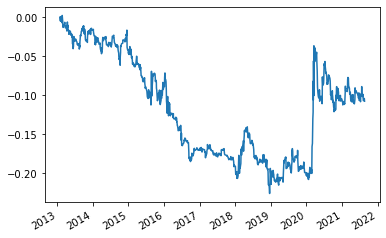

close


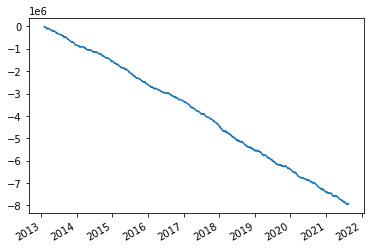

ETF_O_C_t


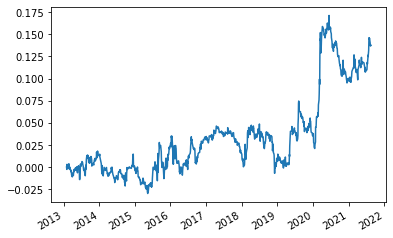

ETF_C_O_t


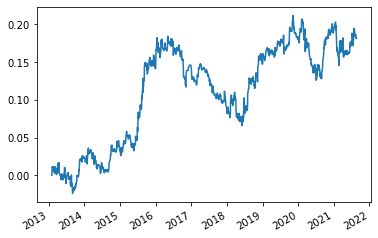

ETF_C_C_t


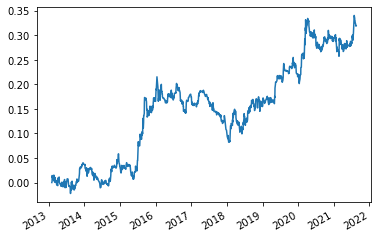

ETF_C_C_US_t


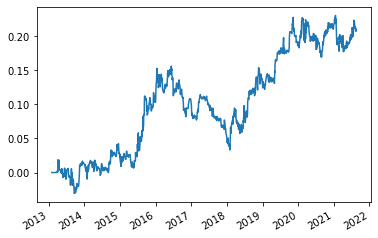

ETF_O_C_US_t


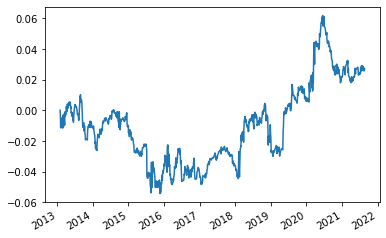

signal


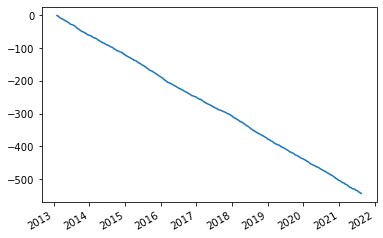

In [1059]:
paper_data=paper_data_original.copy()
sub=pd.merge(paper_data,check['signal'].shift(1),left_index=True,right_index=True)
#sub['return']=sub['ETF_C_C_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)
#sub['return']=sub['future_C_O_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)+sub['future_O_C_t+1']*sub['signal'].apply(lambda x:1.5 if x==1 else 0.5 if x==-1 else 1)
for target_col in sub.columns:
    print(target_col)
    sub['return']=sub[target_col]*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)
    #sub['return']=sub['ETF_C_C_t+1']*sub['signal'].apply(lambda x:0.5 if x==1 else 1.5 if x==-1 else 1)
    sub['return']=sub['return']-sub[target_col]
    sub['return'].cumsum().plot()
    plt.show()

,SPX Index,close,ETF_O_C_t,ETF_C_O_t,ETF_C_C_t,ETF_C_C_US_t,ETF_O_C_US_t,signal
SPX Index,1.000000,0.019853,0.447995,-0.218259,0.125860,-0.113524,0.149894,-0.140968
close,0.019853,1.000000,0.028278,0.033524,0.045831,0.037799,0.017269,0.005161
ETF_O_C_t,0.447995,0.028278,1.000000,-0.085602,0.602606,0.236741,0.615336,-0.086224
ETF_C_O_t,-0.218259,0.033524,-0.085602,1.000000,0.743526,0.862911,-0.008505,-0.000567
ETF_C_C_t,0.125860,0.045831,0.602606,0.743526,1.000000,0.850067,0.406184,-0.058326
ETF_C_C_US_t,-0.113524,0.037799,0.236741,0.862911,0.850067,1.000000,0.498000,-0.030468
ETF_O_C_US_t,0.149894,0.017269,0.615336,-0.008505,0.406184,0.498000,1.000000,-0.059315
signal,-0.140968,0.005161,-0.086224,-0.000567,-0.058326,-0.030468,-0.059315,1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         future_C_O_t+1   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     30.81
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           1.47e-11
Time:                        09:58:40   Log-Likelihood:                 421.42
No. Observations:                 125   AIC:                            -836.8
Df Residuals:                     122   BIC:                            -828.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.947e-05      0.001     -0.092      0.927      -0.002       0.001
NAV_C_C_t+1     0.3391      0.043      7.815      0.000       0.253       0.425
SP_C_O_t       -0.1048      0.123     -0.850      0.397      -0.349       0.139
==============================================================================
Omnibus:                        6.835   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                8.082
Skew:                          -0.332   Prob(JB):                       0.0176
Kurtosis:                       4.054   Cond. No.                         164.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: -6.947256967150908e-05   0.3391372072462303
p-value: 0.9270227928320761   2.1696257358490483e-12


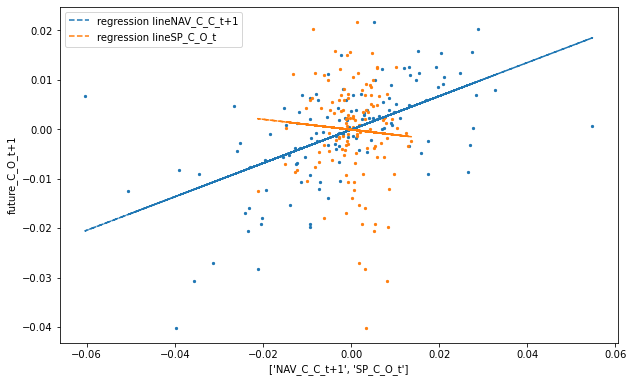

<Figure size 720x444.96 with 0 Axes>

In [986]:
regression(future_overnight,target1=['NAV_C_C_t+1','SP_C_O_t'],target2='future_C_O_t+1')

In [971]:
future_overnight.corr()['ETF_O_C_t+1'].sort_values()

future_C_O_t          -0.236555
future_C_C2_t         -0.192692
future_C_C_t          -0.142251
ETF_O_C_t             -0.125487
open                  -0.104887
ETF_C_C_t             -0.102037
predict_close         -0.101511
close                 -0.085316
SP_close              -0.080528
SP_open               -0.074580
open_nextday_lag0     -0.074350
SP_C_O_t              -0.059895
open_nextday_lag15    -0.047058
SP_C_C_t              -0.043808
NAV_C_C_t             -0.040551
NAV                   -0.025937
SP_C_O_t-1            -0.008170
open_nextday_lag30    -0.003978
SP_O_C_t              -0.003420
ETF_C_O_t+1            0.005494
ETF_C_O_t-1            0.008494
SP_C_O_t+1             0.017281
ETF_C_O_t              0.043951
ret                    0.043951
future_O_C_t-1         0.046312
open_nextday_lag45     0.047089
overnight_ret_real     0.060476
SP_C_C_t-1             0.074352
open_nextday_lag60     0.077473
future_C_C_t-1         0.079182
overnight_ret          0.092333
open_nex

In [912]:
sub.dropna(inplace=True)

In [ ]:
#graph making area

<BarContainer object of 4 artists>

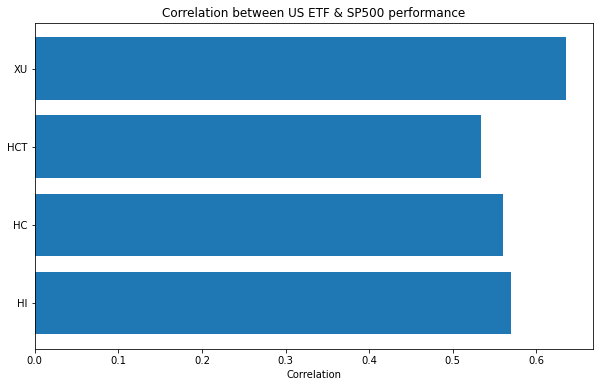

In [1204]:
list1=[]
for target in future_list[:4]:
    future_overnight=main(target)
    list1.append(future_overnight[['ETF_C_O_t','SP_C_O_t']].corr().iloc[0][1])
plt.figure(figsize=(10,6))
plt.title('Correlation between US ETF & SP500 performance')
plt.xlabel('Correlation')
plt.barh(future_list[:4],pd.Series(list1,index=future_list[:4]),)

In [ ]:
figure,axis=plt.subplots(2,2,figsize=(20,20*0.618))
count1,count2=0,0
for target in future_list[:4]:
    future_overnight=main(target)
    
    
    axis[count1,count2].plot(sub['return'].cumsum().index,sub['return'].cumsum())
    axis[count1,count2].set_title(target+' backtest_result')
    axis[count1,count2].set_xlabel('Date')
    axis[count1,count2].set_ylabel('Cumulative Ret')
    count2+=1
    if count2>1:
        count1=1
        count2=0
plt.show()

In [673]:
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
pd.merge(check,forecasts.residual_variance.shift(1),left_index=True,right_index=True).corr(method=pearsonr_pval)

,SP_C_C_t,h.1
SP_C_C_t,1.000000,0.159595
h.1,0.159595,1.000000


In [903]:
from scipy.stats import ttest_1samp
ttest_1samp(sub['return']-sub['ETF_C_C_t+1'],0)a

Ttest_1sampResult(statistic=2.1373505674667417, pvalue=0.03816501183302731)

<AxesSubplot:>

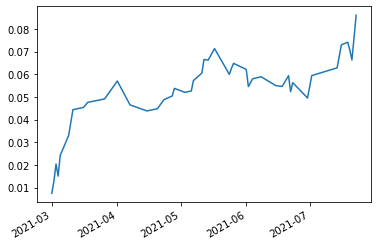

In [909]:
np.cumsum(sub['return']-sub['ETF_C_C_t+1']).plot()

In [672]:
from statsmodels.tsa.arima.model import ARIMA

In [653]:
res.params

Const          0.000054
SP_C_C_t[1]   -0.268772
omega          0.000038
alpha[1]       0.200000
beta[1]        0.500000
Name: params, dtype: float64

In [675]:
check=(returns-res.params[0])-(res.params[1]*returns.shift(1))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    h.1   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.443
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.121
Time:                        19:03:14   Log-Likelihood:                 881.79
No. Observations:                 109   AIC:                            -1760.
Df Residuals:                     107   BIC:                            -1754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   7.24e-06     14.557      0.000    9.11e-05       0.000
SP_C_C_t       0.0013      0.001      1.563      0.121      -0.000       0.003
==============================================================================
Omnibus:                       64.528   Durbin-Watson:                   0.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.671
Skew:                           2.199   Prob(JB):                     3.28e-48
Kurtosis:                       8.368   Cond. No.                         119.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

params: 0.00010543203197391335   0.0013386792714599508
p-value: 3.970040416507493e-27   0.12103257955688837


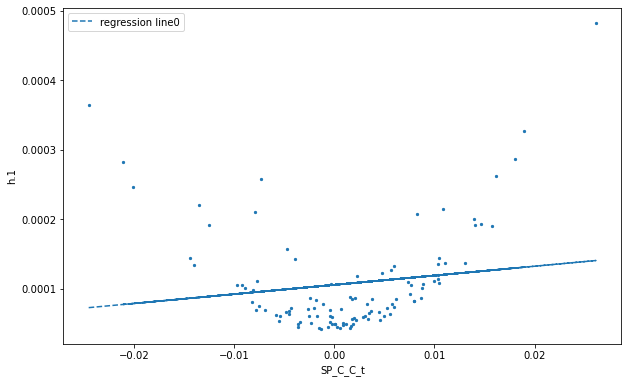

<Figure size 720x444.96 with 0 Axes>

In [633]:
regression(pd.merge(returns,forecasts.residual_variance,left_index=True,right_index=True).dropna())